# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy

class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2

# Rescale parameters
#found_parameters = list(found_parameters)
#found_parameters[0] = found_parameters[0] / 50
#found_parameters[1] = found_parameters[1] * 500

# Show score of true solution
#print('Score at true solution: ')
#print(score(true_parameters))

# Compare parameters with original
#print('Found solution:          True parameters:' )
#for k, x in enumerate(found_parameters):
    #print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))
    
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]
start_parameters = [1.0, 1.0]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 5
values = org_values + np.random.normal(0, noise, org_values.shape)

Using matplotlib, I look at the noisy time series I just simulated:

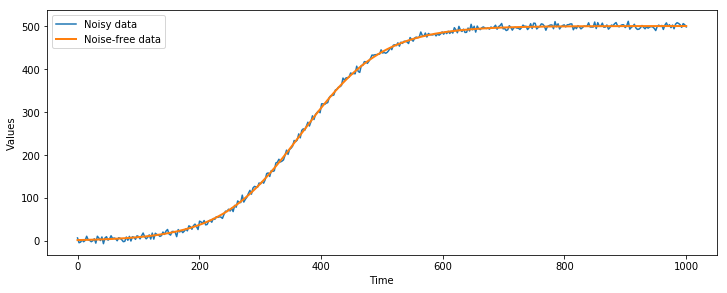

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
model = RescaledModel()
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
#bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
bounds = pints.RectangularBoundaries([0.5, 0.5], [1.5, 1.5])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05,
    np.array(start_parameters) * 1.15,
]

And this gives us everything we need to run an MCMC routine:

In [13]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
[0.92360981 1.02438947]
-32347.654680577587


[0.9381325 1.0728262]
-49944.709628815894
accepted


[1.16322298 1.09371883]
-143635.72897862896
accepted


1     6      0         0.5       0.5        0:01.1
[0.87803712 0.91871151]
-15748.420436734916
accepted


[1.03432256 1.01596056]
-63801.60707080099


[1.17096927 1.0231785 ]
-110595.42932518554
accepted


2     9      0.333     0.333     0.667      0:01.1
[0.89956921 0.92692336]
-18819.421771683123


[0.74614873 0.8888543 ]
-14213.585810600918
accepted


[1.14028932 0.9885351 ]
-88608.88872902835
accepted


3     12     0.25      0.5       0.75       0:01.1
[0.80462577 0.98174619]
-4060.9815578878806
accepted


[0.41529198 1.04227507]
-inf


[1.10656827 1.17517917]
-174864.1445149831


[0.82766646 1.01204772]
-8614.858076877697


[0.707225

-28305.188105614172


[0.85213794 1.12854609]
-41491.97371307124


[0.71258618 1.05442828]
-4285.369231495259


[0.89569396 0.99948287]
-21043.21795833571


[0.80181255 0.96930898]
-3897.5238377570413


[0.8866723  1.08437174]
-37112.9110240831


[0.70230329 1.12093249]
-13575.427186497784


[0.80939449 1.08746055]
-17738.21925445009


[0.90384862 1.25461482]
-131581.56128641998


[0.7380327  0.96335312]
-3092.9529629553635


[0.79769759 1.07821487]
-13437.87198939363


[0.85647799 0.94770881]
-10994.671954306094


[0.6246035  0.98217039]
-28440.93330333307


[0.62081141 1.00002627]
-28199.760231120654


[0.7199844  0.93974943]
-7455.716109335821


[0.72202242 0.8392041 ]
-31744.126339169103


[0.76602418 0.91804673]
-7421.829005515093


[0.9348822 1.157898 ]
-85634.25594126881


[0.76982398 1.0422795 ]
-4216.898216994998


[0.74923924 1.01863173]
-1530.8530058896067
accepted


[0.75879372 0.92113973]
-7154.84385359378


[0.54117107 1.04365177]
-78831.84293350075


[0.82444289 0.896872

[0.78677513 1.143913  ]
-28953.59462087637


[0.63702266 0.91430705]
-35155.6429871432


[0.72172477 0.854934  ]
-26600.918483306228


[0.76960247 0.98831651]
-1607.9683796575864


[0.73336828 1.15137168]
-22150.12831860735


[0.66825645 1.00840532]
-10534.97275051741


[0.67017812 0.73620246]
-92827.85259218857


[0.84653296 1.14453356]
-45891.29501345452


[0.79809687 1.10587507]
-20037.27075889565


[0.73098071 1.16520285]
-25983.860604466452


[0.72434359 1.07858367]
-6471.511528613062


[0.75135725 0.98494143]
-1410.3922357715676


[0.81521638 0.95100223]
-5779.893925660732


[0.86038592 0.9901019 ]
-12615.239518962431


[0.64169475 1.04639652]
-17346.44552643004


[0.8809727  0.91589712]
-16417.394236989676


[0.59432896 0.99751142]
-42864.817503075654


[0.78429344 0.95369696]
-3511.8306480854562


[0.70610838 0.95238851]
-7713.347659913518


[0.85251989 0.92640727]
-11565.377224954458


[0.74315668 1.1684955 ]
-28692.001189532304


[0.67532805 0.97105748]
-11775.390494731497




-1284.604678579474


[0.7560423  0.99739444]
-1231.2815239149636


[0.76141571 0.99913612]
-1344.5420638287305


[0.75981219 0.99841106]
-1300.2946796173278


[0.76021149 0.99418222]
-1306.4364430241878


[0.7488512  1.00314721]
-1199.3447471912696
accepted


[0.750786   0.99679535]
-1200.8433506946744


[0.74558671 0.99687825]
-1236.786203017879


[0.75613875 1.00172636]
-1250.1444127262446


[0.74899152 0.99224998]
-1260.956492738226


[0.74775362 0.99747142]
-1208.7142844629293
accepted


[0.75513567 0.99849081]
-1220.5729672353243


[0.75358443 0.99811655]
-1205.8597545314024


[0.7424059  0.99279078]
-1361.9554863529427


[0.7493263  1.00520436]
-1215.65192716853


[0.75420013 0.99891433]
-1211.152806851859


[0.74868942 0.99672621]
-1208.0174116410385
accepted


220   663    0.0452    0.0407    0.0679     0:01.6
[0.74692317 1.00301625]
-1203.8233493800744


[0.75725198 0.99826082]
-1249.7654115904609


[0.75605714 1.00380915]
-1270.832698550981


[0.74717544 1.00196803]
-1199.886

[0.74930248 0.99922066]
-1192.8429541954815
accepted


[0.75163584 0.99984273]
-1194.5481955021246


[0.75351555 1.00027168]
-1207.8062038527937


280   843    0.146     0.135     0.13879    0:01.8
[0.74969952 0.99872402]
-1193.3728719341173


[0.7498214  1.00019091]
-1191.1606727539222
accepted


[0.75049181 1.00091052]
-1192.6296054692934
accepted


[0.74822397 0.99932633]
-1196.4118946765207


[0.75040141 0.99967442]
-1191.4580311061209


[0.74858152 1.00195004]
-1194.8199181092377


[0.74868829 0.99961117]
-1193.7631787176708


[0.75033419 1.00067258]
-1191.9070545138838


[0.74915448 1.00097234]
-1192.0980898157095
accepted


[0.74992262 0.99955266]
-1191.4475207385442
accepted


[0.74991479 1.00015447]
-1191.1517714919307
accepted


[0.74923137 0.99944403]
-1192.5350752465058
accepted


[0.7504381  0.99968803]
-1191.4859207443546
accepted


[0.75034321 1.00124263]
-1193.1234193681069


[0.74827784 0.99998666]
-1194.6653440054577


[0.74905906 0.99943081]
-1192.9869375584146


[0.

[0.74970535 1.00011459]
-1191.1998084227066
accepted


[0.74870965 1.00261583]
-1196.9070428252232


[0.74900518 1.0000481 ]
-1192.2207061374556
accepted


[0.74936526 0.99979573]
-1191.7542149955016
accepted


[0.75011782 1.00060129]
-1191.5443988282811
accepted


[0.74956551 1.00049461]
-1191.345582419234
accepted


[0.74916672 0.99957205]
-1192.4526702614726
accepted


[0.74971302 1.00032634]
-1191.2137392166205
accepted


[0.74906125 1.00110836]
-1192.383783790183
accepted


[0.75011331 0.99995972]
-1191.1951553628876
accepted


[0.74985513 1.00046875]
-1191.2748872822485
accepted


[0.74926077 1.00122423]
-1192.3644399955456
accepted


[0.75002887 1.00032652]
-1191.2403386799
accepted


[0.74923226 1.00092217]
-1191.9556996396025


[0.74646044 1.00211321]
-1204.5222875814145


[0.75129615 1.00067232]
-1194.5283513489721


[0.74898112 1.00087927]
-1192.2547016509054


[0.75062189 1.00199604]
-1196.5650175610913


[0.75035419 1.00095952]
-1192.4631772540909


[0.75047647 1.00200922]



[0.75418506 0.99719441]
-1212.1125448412376


[0.75422856 0.99468048]
-1224.900621249761


[0.74910444 1.00119861]
-1192.4636433226588


[0.75015578 0.99866987]
-1193.0150518754197
accepted


[0.74813911 1.00446307]
-1208.066376993055


[0.75032847 0.99985241]
-1191.3410673098938


[0.74910733 1.00101335]
-1192.2037268539357
accepted


[0.75016704 1.001356  ]
-1193.1071099946148


[0.75036348 1.00034501]
-1191.5562289685017
accepted


[0.74763507 1.00116236]
-1196.8104015141498


[0.74805606 1.00282031]
-1198.8287085635163


[0.75147162 1.00006227]
-1194.1309361426559


[0.74750432 1.00142203]
-1197.5795143650785


[0.7466081  1.00395062]
-1209.4328803425346


[0.7502812  1.00079923]
-1192.032962930578


[0.74970532 1.00167737]
-1193.4723365114285


[0.74937241 1.00000837]
-1191.5625405296357
accepted


[0.75170508 1.00067625]
-1196.349190291566


[0.74959896 0.99853967]
-1194.1524290633051


[0.74671765 1.00207417]
-1202.7374407333964


[0.7511176  1.00048633]
-1193.499516302991


4

[0.74757243 1.00275708]
-1200.0666578798955


[0.75023463 0.99814597]
-1194.644230018017


[0.7501965 0.9973965]
-1198.0583444136453


[0.74937827 0.99887443]
-1193.573813550221


[0.75008215 0.99842415]
-1193.807005132233


480   1443   0.237     0.249     0.235      0:02.4
[0.74853836 1.00064374]
-1193.1993104283406
accepted


[0.75026938 0.99769551]
-1196.4854967016936


[0.74805872 1.00142328]
-1195.2153309738883


[0.74598439 1.00381638]
-1212.545108884612


[0.74915067 1.00157898]
-1193.1746866344215


[0.75199936 0.99983759]
-1196.1862191489818


[0.74913982 1.00117529]
-1192.389019746282
accepted


[0.75169073 0.99995914]
-1194.9001741368738


[0.74918713 1.00009886]
-1191.8076131254174
accepted


[0.74844989 0.99925586]
-1195.5744999492408


[0.74917557 1.00266698]
-1196.9811234137653


[0.74706242 1.00044992]
-1200.6608289273115


[0.75180357 1.00456248]
-1222.9505437501612


[0.74709198 1.00199025]
-1200.3752576889915


[0.75020134 1.00001151]
-1191.2392884961878
accepted






[0.74828834 1.00028364]
-1194.244385499835


[0.74880496 1.00072965]
-1192.513375010157
accepted


[0.74979261 0.99931362]
-1191.872124114699


[0.74955584 0.99971717]
-1191.568590133713
accepted


[0.74719514 1.00160942]
-1199.355936210672


[0.74906378 1.00147338]
-1193.0105623705404


[0.75161218 0.99832473]
-1195.4600487212692


[0.74784217 1.00175921]
-1196.490938062514


[0.75045777 0.99830003]
-1194.0056905039291


[0.75082366 1.0005429 ]
-1192.7208164820804


[0.74903104 0.99924618]
-1193.4838922235026
accepted


[0.75020789 0.99813915]
-1194.692318934208


[0.75122284 0.99834359]
-1194.5259644676546


[0.74943482 1.00202039]
-1194.4377099198844
accepted


[0.74884684 1.00180687]
-1194.0368098311785


[0.74949248 0.99924929]
-1192.3994832601643
accepted


[0.74824482 1.00340186]
-1201.18077948709


[0.7492816  1.00243355]
-1195.981699869661


[0.7511505  0.99521892]
-1212.3633119131935


[0.74921101 1.00218968]
-1195.005002275931


[0.75006523 1.0004088 ]
-1191.3150018909876



[0.75228576 0.99728322]
-1200.7151460068685


[0.75016751 0.99992155]
-1191.2239499227492
accepted


[0.749622   1.00204388]
-1194.643128368029


[0.74900688 0.9999988 ]
-1192.2612530809886
accepted


[0.74907489 0.9979399 ]
-1198.2702687644544


[0.75139032 0.99819037]
-1195.249390632249


[0.74600615 1.00296412]
-1209.4560413138029


[0.74974442 1.00110261]
-1192.0720542599477


[0.75099202 0.99866595]
-1193.4137745276557
accepted


[0.75051406 0.99851233]
-1193.3753079770156


[0.75001291 0.99703517]
-1200.4740659088916


[0.74991264 0.99766659]
-1197.1771748998915


[0.7497641  1.00193942]
-1194.404295109889


[0.75107435 0.99681342]
-1200.6842530245883


[0.7514259  0.99824427]
-1195.1861538919086


[0.74960311 1.00175466]
-1193.6395326882234


[0.75018834 0.99864037]
-1193.0777934089217
accepted


[0.75088218 0.99908634]
-1192.5525932488624
accepted


[0.74736108 1.00214534]
-1199.268476125065


[0.75022926 0.99989924]
-1191.2616369757654
accepted


[0.74865975 0.9999675 ]
-1193

[0.74953055 0.99873085]
-1193.6695326922845


[0.748741   1.00211406]
-1195.050510342597


[0.75031294 0.99781934]
-1195.8899233423112


[0.7477229  1.00082702]
-1196.3902041845442


[0.75051062 1.00068932]
-1192.2436669145604


[0.74971988 1.00004346]
-1191.206869853977
accepted


[0.75184717 0.99977207]
-1195.3929451041486


[0.75105999 1.00112199]
-1194.8325076612791


680   2043   0.233     0.233     0.242      0:02.9
[0.74780708 0.99894505]
-1200.0777152591563


[0.75111712 1.00113368]
-1195.0846740406055


[0.75304393 0.99820161]
-1202.0810514913996


[0.74873241 1.00009092]
-1192.902039994792


[0.75157597 1.00088496]
-1196.311086789427


[0.75123744 0.9984706 ]
-1194.253470657607


[0.75002598 0.99900445]
-1192.2815874104022


[0.75059241 1.00058563]
-1192.241641511374
accepted


[0.75136621 0.99712233]
-1199.239842621004


[0.74855592 1.0012962 ]
-1193.5719810804785


[0.75039277 1.00281684]
-1200.054107157945


[0.74999458 0.99921288]
-1191.8958991357067
accepted


[0.7496631

accepted


[0.75086293 1.00226359]
-1198.7636093702642


[0.74898722 0.99973259]
-1192.6380855657094
accepted


[0.75121442 0.9985069 ]
-1194.1290556980175
accepted


[0.75052451 0.99911038]
-1192.1101979178575
accepted


[0.74829317 0.99863903]
-1198.5620137499782


[0.75027027 0.99486898]
-1217.655116264992


[0.75136226 0.99690439]
-1200.346769704993


[0.75089537 0.99887472]
-1192.8841076370484
accepted


[0.74966242 1.00029416]
-1191.2254548761198
accepted


[0.75106714 0.99989056]
-1192.655280755048
accepted


[0.7515036  0.99937573]
-1193.8817412029832
accepted


[0.74906527 0.99783747]
-1198.8407149704103


[0.75328868 0.99562051]
-1213.2792882921653


[0.75439775 0.99778689]
-1212.938290091417


[0.75236163 1.00059216]
-1199.8599835870443


[0.75099958 1.00072228]
-1193.5808558516512


[0.75232028 0.99834668]
-1197.9977790707837


[0.7496083  0.99837366]
-1194.730514339317


[0.75364758 0.99665015]
-1209.9424996651787


[0.7482366  0.99917567]
-1196.819252203778


[0.747513   

[0.74941049 0.99998219]
-1191.526367353606
accepted


[0.75460672 0.9962337 ]
-1218.6832208263463


[0.74931026 0.99519217]
-1218.578642047747


[0.75158237 1.0034087 ]
-1210.3926659744557


[0.75387509 0.99697351]
-1210.3438820431695


[0.74676632 1.00289156]
-1204.2594066460515


[0.74945993 1.00367075]
-1203.0666454702541


[0.74999263 1.00016341]
-1191.165028054992
accepted


[0.74870628 1.00169485]
-1193.973331984266
accepted


[0.7481619  0.99991022]
-1195.303388215103


[0.75257045 0.99799078]
-1199.8269198296287


[0.75239062 1.00099697]
-1201.4571204682877


[0.75066649 1.00325604]
-1204.001130975795


[0.75006945 0.99879509]
-1192.741435584816


[0.74998153 1.00325053]
-1201.4625108687171


[0.74916396 0.99887161]
-1194.1439436298924


[0.74893126 1.0034554 ]
-1201.1018155147665


[0.75065143 0.99872924]
-1192.9034603557943
accepted


[0.75199175 1.00069108]
-1197.9092894072428


[0.75076821 1.00076172]
-1192.9807990365496


[0.74914666 1.00131838]
-1192.6259302476265
accepte



[0.74827795 1.00401722]
-1204.8225348762148


[0.75562032 0.99644178]
-1227.7959071914393


[0.75347811 1.00129248]
-1211.9170381907127


[0.75072605 1.00034244]
-1192.1990265996988
accepted


[0.75112537 0.99676667]
-1200.965637991103


[0.74997677 1.00132686]
-1192.7575211341036


[0.75377591 0.99572675]
-1215.2164226432044


[0.75100333 1.00084323]
-1193.8712736822424


[0.75093286 0.99745111]
-1197.3608086010047


[0.74809597 1.00218166]
-1196.5733103799107


[0.74986289 1.00119353]
-1192.3291792621915
accepted


[0.75077683 0.997609  ]
-1196.620921031135


[0.755103   0.99988091]
-1223.5869512369088


[0.749452   1.00249257]
-1196.3409612477158


[0.74878715 0.99759995]
-1201.4201451205795


[0.74972915 1.00084626]
-1191.6472217087621
accepted


[0.75126947 1.00118141]
-1195.8583981174497


[0.75086007 0.99938048]
-1192.229992729779


[0.74773688 1.00214026]
-1197.6571461994295


[0.75052995 1.00085229]
-1192.5893854627702


[0.75129174 0.99935684]
-1193.2322691490576


[0.74722

-1203.2433869010226


[0.74964912 1.00075407]
-1191.530655087035
accepted


[0.74815224 1.00154357]
-1195.0568244141434


[0.74922535 0.99856663]
-1195.0018091367997


[0.75143403 0.99838342]
-1194.8726869252043


[0.75053656 0.99918721]
-1192.0097962540037


[0.74928935 1.00178243]
-1193.6550788483062


[0.74801497 1.00072923]
-1195.0828606696728


[0.75094457 0.99841123]
-1193.9383914623686


[0.74978792 1.00063137]
-1191.4025898212972
accepted


[0.75030862 1.00142097]
-1193.5620659256203


[0.75045962 1.00135061]
-1193.6888275250055


[0.7488531  0.99856128]
-1196.3094835976003


[0.75154119 0.99715381]
-1199.3327586243065


[0.74886782 0.99996093]
-1192.6547777034243
accepted


[0.75043628 1.00005825]
-1191.4747503282879


[0.75201406 0.9995303 ]
-1195.9842745240976


[0.74882145 1.00061608]
-1192.4462296897939
accepted


[0.74909493 1.00088338]
-1192.0825153954975
accepted


[0.74744549 1.00252199]
-1199.8206654532362


[0.74870566 1.00174551]
-1194.0910459239553


[0.74965498 0.

[0.74875869 1.0004503 ]
-1192.6076894802732


[0.75361477 0.99846143]
-1205.8682697505733


[0.7505261  0.99857009]
-1193.2235962452894


[0.75089551 1.00119316]
-1194.4680905868597


[0.75118435 0.9997845 ]
-1192.9339223418413
accepted


[0.74960739 0.99861534]
-1193.8812934336383


[0.75040182 0.99991256]
-1191.4068434227947
accepted


[0.74828812 1.00226302]
-1196.3165626490922


[0.75021135 1.00236451]
-1197.0570149593768


[0.74968589 0.99833344]
-1194.7189593716996


[0.75099793 0.99972349]
-1192.4231909588157
accepted


[0.75100865 1.00053199]
-1193.2319668549212


[0.75246551 0.99986332]
-1198.8113481746238


[0.75150443 1.00059421]
-1195.2102476418906


[0.74836069 1.00291416]
-1198.6203247093088


[0.74993674 0.99792436]
-1195.9241176399446


[0.74971249 1.00402789]
-1206.2813404388667


[0.7505654  0.99703769]
-1199.582225331695


[0.74991086 1.00000936]
-1191.1566400294614
accepted


[0.75380833 0.99858222]
-1207.4235091952862


[0.74684393 0.99802601]
-1212.6189372193123



-1194.917219022299


[0.74976679 0.99990469]
-1191.2367364545087
accepted


[0.75154026 1.00217299]
-1201.6426701450107


[0.75097742 0.99856408]
-1193.610641322707


[0.74995842 0.9969403 ]
-1201.2000837112755


[0.75275319 1.00131841]
-1205.5727492510043


[0.75009308 0.99965512]
-1191.3229866249555
accepted


[0.75098746 0.99757041]
-1196.8599235037086


[0.74986827 1.00246341]
-1196.7653310725455


[0.74994444 1.00026935]
-1191.1840319897146
accepted


[0.74935927 0.99936339]
-1192.4190575487767
accepted


[0.75119608 1.00351802]
-1208.774851035905


[0.74902672 0.99980779]
-1192.4310145585407
accepted


[0.75078864 1.00055843]
-1192.655512231591
accepted


[0.74855992 1.00131736]
-1193.5906920723692
accepted


[0.74804312 1.00031906]
-1195.2434812372148


[0.75178895 0.99918736]
-1194.9624058556678


[0.74879233 1.00032922]
-1192.5619251067521
accepted


[0.75070898 1.00359623]
-1206.7288363778566


[0.74938117 0.9999161 ]
-1191.6163164079608
accepted


[0.7497198  0.99740454]
-11

[0.74846188 1.00203025]
-1195.2665772273212


[0.75027183 0.99630155]
-1204.8837314126758


[0.7484434  1.00299055]
-1198.850649732444


[0.74957794 0.99992701]
-1191.3661947551252
accepted


[0.75254867 0.99475872]
-1217.2734677282845


[0.75292541 0.99935726]
-1201.1350922028696


[0.74978871 0.99709485]
-1200.67206997112


[0.74895797 0.99679326]
-1206.0286870402892


[0.75164668 1.00043459]
-1195.4920859370845


1160  3483   0.23      0.241     0.254      0:04.3
[0.74848929 1.00042785]
-1193.4116089590286


[0.75101969 0.99750069]
-1197.1810644728441


[0.75070404 0.99977321]
-1191.8242190327512
accepted


[0.75160659 1.00041949]
-1195.278638076231


[0.75053663 0.99729536]
-1198.200674776836


[0.7513893  0.99827856]
-1195.0194667737214


[0.75202786 0.99951324]
-1196.0402398332708


[0.75260677 0.99247425]
-1242.5959426229497


[0.75080715 0.99884831]
-1192.814151839118


[0.75159147 1.00081626]
-1196.1844384192018


[0.75165327 0.99675377]
-1201.5228065515482


[0.74906267 0.999

[0.7522635  0.99605442]
-1206.858010048208


[0.75039168 1.00020499]
-1191.4886669136383
accepted


[0.74987091 1.00216768]
-1195.4439490267766


[0.74697627 1.00044093]
-1201.279924300742


[0.7503735  0.99900982]
-1192.2061760566585
accepted


[0.74813398 0.99909558]
-1197.6178151221309


[0.74731203 1.00253183]
-1200.431946374512


[0.7486184  1.00116986]
-1193.2695908568517


[0.7525776  0.99721974]
-1202.089055544228


[0.74950589 1.00278791]
-1197.8196666319313


[0.74977901 0.9974281 ]
-1198.7346948948964


[0.74998575 0.99962063]
-1191.3587304696669
accepted


[0.74633606 1.0015718 ]
-1205.103365629955


[0.74796797 1.00115988]
-1195.3337406916316


[0.75028539 1.00121475]
-1192.937676280586


[0.74755993 1.00079037]
-1197.2422487986462


[0.75034193 0.9979989 ]
-1195.1272148848768
accepted


[0.75200297 0.99888782]
-1195.9858657475258


[0.74803823 1.00219059]
-1196.7655969559996


[0.748456   1.00305521]
-1199.141478595348


[0.74921285 0.99828999]
-1196.140943897006


[0.749



[0.74791129 1.00181951]
-1196.3395472828831


[0.75115014 1.00059924]
-1193.8272367178306


[0.75000995 1.00199578]
-1194.9835672054937


[0.74796614 0.99940811]
-1197.5011905790548


[0.75026853 1.00009774]
-1191.30624979896
accepted


[0.75032458 0.9998111 ]
-1191.3461971041697
accepted


[0.74842546 1.00364145]
-1202.334648194731


[0.7481262  0.99892684]
-1198.2818940402778


[0.75158803 1.00037557]
-1195.1081151898964


[0.75019008 1.00194272]
-1195.1370205654496


[0.75031384 1.00082964]
-1192.1378131450842
accepted


[0.74958719 0.9997288 ]
-1191.5198754865596
accepted


[0.74936705 0.99981769]
-1191.7283487845673


[0.75032323 0.99906131]
-1192.102678018367
accepted


[0.74922595 0.99977868]
-1192.02500825865


[0.74789258 1.00055684]
-1195.7191811958392


[0.75070521 0.99739569]
-1197.6104347132139


1300  3903   0.229     0.232     0.255957   0:04.6
[0.74964208 1.00070126]
-1191.4756248754848
accepted


[0.74937824 1.00224045]
-1195.2328189019124


[0.75096673 0.99664634]
-

-1221.8014099662453


[0.75040432 0.99897524]
-1192.2789554529388
accepted


[0.74988542 1.00194554]
-1194.5858735155925
accepted


[0.74890461 1.00049613]
-1192.2511874896504
accepted


[0.74999273 0.99980436]
-1191.2249676997983
accepted


[0.74857377 1.00372871]
-1202.7853818861408


[0.74874797 0.9994806 ]
-1193.8329902139353


[0.74876965 0.99924922]
-1194.323654012508


[0.74784029 1.00375616]
-1203.8731304299542


[0.74958679 0.99835745]
-1194.8397709628264


[0.75132809 1.0009302 ]
-1195.32752693778
accepted


[0.75244498 1.00280356]
-1212.2837441316315


[0.74983769 1.00258603]
-1197.3086032455772


[0.75252333 0.9999408 ]
-1199.3070304268886


[0.74756646 0.99878828]
-1202.3520469206323


[0.75330818 1.0016324 ]
-1212.1912376654798


[0.75292837 1.0009781 ]
-1205.4396908865542


[0.75209648 1.00225226]
-1205.723453209891


[0.74920706 0.99776548]
-1198.6791447477835


[0.74987042 1.0012238 ]
-1192.402596968669
accepted


[0.75140449 1.00251804]
-1202.8912849432797


[0.748349


[0.74696277 1.00167274]
-1200.7696981053894


[0.7498435  0.99794816]
-1195.9905366651863


[0.74938907 0.99851755]
-1194.723184601904


[0.74914501 0.99974235]
-1192.2420538732442
accepted


[0.7528455  0.99837304]
-1200.6841994163497


[0.75052824 0.9982727 ]
-1194.090057141557


[0.75263214 0.99620844]
-1207.0433589616462


[0.74931447 0.99924341]
-1192.7646869946802


[0.75058646 1.0013951 ]
-1194.154350630104


[0.75265461 0.9977892 ]
-1200.6956323912207


[0.74879028 1.00000814]
-1192.8196087056947
accepted


[0.75170952 0.99517012]
-1212.6428950658947


[0.75058517 0.99778467]
-1195.8848127045371


[0.7518655 0.9969215]
-1201.0646772799796


[0.75001304 0.9995913 ]
-1191.3808377996688
accepted


[0.74945902 0.99891034]
-1193.2904323284902
accepted


[0.74998819 0.9993951 ]
-1191.6156107318914
accepted


[0.74908026 0.99994248]
-1192.1487437291353


[0.7496547  0.99624259]
-1207.2096493392894


[0.74826264 1.00152178]
-1194.6820350704818


[0.75042272 0.99743643]
-1197.576204071



[0.75119583 0.99692746]
-1200.0941764785853


[0.75041083 0.99757837]
-1196.8955991508788


[0.74807742 0.99849349]
-1200.4334385098218


[0.74813282 0.99944439]
-1196.5221990812954


[0.74970893 0.99817134]
-1195.3102981694492
accepted


[0.74883774 1.00181675]
-1194.0740122461693


[0.75075647 0.99729063]
-1198.117976955069


[0.75066524 0.99898939]
-1192.4179828650515
accepted


[0.74897383 0.99824987]
-1197.1694465481094


[0.75477153 0.99540213]
-1224.0409992992738


[0.75012168 0.99778488]
-1196.2599524656473


[0.74929662 0.99960028]
-1192.1305677199327
accepted


[0.75152786 0.99938086]
-1193.963304781285


1500  4503   0.229     0.239     0.256      0:05.2
[0.75082066 0.99757342]
-1196.7829229463878


[0.74926783 1.00232469]
-1195.529408928672


[0.7486164  0.99938404]
-1194.5410709308214


[0.74910305 0.99499764]
-1221.8951978164223


[0.7468993  1.00051017]
-1201.7163289437287


[0.7496045  1.00309159]
-1199.6325031664128


[0.74956043 1.0007694 ]
-1191.5671005932952
accep

[0.75007686 1.00193411]
-1194.8677404415205


[0.75024767 1.00162279]
-1194.081489213188


1560  4683   0.231262  0.234     0.258      0:05.4
[0.74989595 1.00040138]
-1191.2382748737118
accepted


[0.75143899 1.00039105]
-1194.5088312071255


[0.74899171 1.00295898]
-1198.3624432119034


[0.74958296 1.00055868]
-1191.3749606625197
accepted


[0.7475007  1.00134969]
-1197.5525433889047


[0.74971587 1.00094104]
-1191.7835234503768
accepted


[0.75061746 0.9970972 ]
-1199.205477076383


[0.749063   0.99994439]
-1192.1854452483626


[0.75242999 1.00102184]
-1201.8287265194153


[0.75014274 1.00082729]
-1191.8953050409216


[0.74993323 1.0020379 ]
-1195.0168509718774


[0.7496881  1.00238917]
-1196.1335973413538


[0.74995148 0.99943834]
-1191.573055672014
accepted


[0.75066559 1.00229498]
-1198.1486614352868


[0.7496193  1.00429723]
-1208.1988464985875


[0.74987159 0.99837532]
-1194.2354893368852


[0.75049571 1.00083136]
-1192.4748491825685


[0.74549371 1.00237075]
-1212.715732958216

-1192.4841564993258
accepted


[0.75092646 1.00309441]
-1204.1066979053417


[0.74952738 1.00507198]
-1214.946458625427


[0.75328441 0.99796139]
-1203.958701235477


[0.74751901 0.99954474]
-1199.7549140582266


[0.74859436 0.9975002 ]
-1203.0350632909635


[0.75043246 1.00239121]
-1197.8348997028404


[0.75236385 1.00024213]
-1198.9347025221084


[0.74623411 1.00086966]
-1206.4496943724473


[0.7519826 1.0024962]
-1206.4705642932372


[0.74928344 0.99860463]
-1194.6955441424002


[0.74934084 0.99553008]
-1214.987217433772


[0.75169537 0.99696659]
-1200.497286837946


[0.74868635 1.00178685]
-1194.2220452038755


[0.7461874  1.00288428]
-1207.9252952062338


[0.75209693 1.00139456]
-1201.1498908136577


[0.75046797 1.00099978]
-1192.7768864844306


[0.74992888 1.00148961]
-1193.1407482929412
accepted


[0.75062559 0.99911877]
-1192.1826635997124
accepted


[0.74902929 1.00267453]
-1197.0001921285832


[0.74805009 1.00001982]
-1195.6299779473836


[0.74988441 1.0004096 ]
-1191.2409940

[0.75193811 1.00225912]
-1204.653281593563


[0.7519177  1.00006331]
-1196.0957988639138


[0.74841797 1.00351286]
-1201.5894933689117


[0.7509785  1.00096503]
-1194.0971645461364


[0.74979922 0.9974203 ]
-1198.7271429745094


[0.74711654 1.00235559]
-1200.934979527349


[0.74913493 1.00023571]
-1191.8370582012078
accepted


[0.74993746 0.99838064]
-1194.1217609830187


[0.74688629 1.00213936]
-1201.792213074


[0.75070202 0.99861014]
-1193.211889787495


[0.75050429 0.99690577]
-1200.4187879488215


[0.74863618 0.99868572]
-1196.715429671239


[0.74791339 1.00147903]
-1195.8212040609221


[0.75188754 0.99999862]
-1195.8505210509543


[0.74997612 0.99853697]
-1193.5566933340358


[0.74931271 1.00156203]
-1193.0547083856873


[0.7499865 1.0008206]
-1191.7313283242624
accepted


[0.74896743 0.99975329]
-1192.6593377319919


1700  5103   0.23398   0.232     0.252      0:05.8
[0.74973328 1.00047903]
-1191.2800151753977
accepted


[0.74967854 1.00120812]
-1192.257256739922
accepted


[0.7

[0.74770515 1.00310014]
-1200.947219253256


[0.7520585  0.99900017]
-1196.1571690646015


[0.75211086 0.99917992]
-1196.34920395776


1760  5283   0.236     0.233958  0.249      0:05.9
[0.74917743 0.99963959]
-1192.319252077545
accepted


[0.7523259  0.99749352]
-1200.1156507658716


[0.74748158 1.00148061]
-1197.7364701182055


[0.74886438 1.00244362]
-1196.0903933454724


[0.74817242 1.00116337]
-1194.568822797041


[0.75015697 0.9985146 ]
-1193.459896417746


[0.75149481 0.99830193]
-1195.2064940363468


[0.75402069 0.99853012]
-1209.2426785173575


[0.74867185 1.00080643]
-1192.8618900340266


[0.75172679 0.9973159 ]
-1198.971049878908


[0.75187517 1.00023542]
-1196.185332518055


[0.75008174 0.99888635]
-1192.5119165883766


[0.74954905 0.99911483]
-1192.5957948540458
accepted


[0.75193108 0.99968119]
-1195.6993261084997


[0.74984806 1.00178359]
-1193.9584820403336


[0.75009845 1.00077387]
-1191.7608175922285
accepted


[0.74995007 1.00006642]
-1191.15021541798
accepted


[0.

-1202.2036184666363


[0.74783894 1.00278324]
-1199.2712943553013


[0.74987623 1.00014717]
-1191.1510941930426
accepted


[0.75130499 1.00171576]
-1198.1016792308849


[0.7533746  1.00310735]
-1223.9310424872192


[0.74919579 1.00098329]
-1192.064764178059
accepted


[0.74955872 1.00020532]
-1191.2857153196016
accepted


[0.74825871 1.00523473]
-1214.3859756875966


[0.74795757 1.00200584]
-1196.5614827923414


[0.74870465 1.00139707]
-1193.3963061651812


[0.74923386 0.9984324 ]
-1195.4891777762737


[0.75055597 1.0000522 ]
-1191.6422972492546
accepted


[0.74851841 1.00059965]
-1193.2635531801675


[0.74828898 1.00130142]
-1194.312000579711


[0.75288296 1.00069504]
-1203.9449149218453


[0.74997371 0.99972875]
-1191.2735657266137
accepted


[0.74990442 1.00114852]
-1192.2657335012316
accepted


[0.75204929 1.0014114 ]
-1200.9176033944202


[0.74855307 0.999463  ]
-1194.5922638018778


[0.74909427 0.99972332]
-1192.384928763374
accepted


[0.74968211 1.00003451]
-1191.2314013717867


[0.74732007 1.00062684]
-1198.7468759553067


[0.75038818 0.99662372]
-1202.3775593565697


[0.75127147 0.99755524]
-1197.1888130276002


[0.74619481 1.00295625]
-1208.0636331822684


[0.74870232 0.99975914]
-1193.4419437238282
accepted


[0.75162696 1.00076683]
-1196.2151432703688


[0.75020792 0.99783143]
-1195.9433580997606


[0.74950938 1.00153318]
-1192.9707902552577
accepted


[0.75184621 0.99969071]
-1195.3191447363065


[0.74574134 0.99966894]
-1214.7531527415676


[0.75098938 1.00045832]
-1193.0474548459215
accepted


[0.75031155 0.99841618]
-1193.6768984103594


[0.747065   1.00007235]
-1201.4075118843193


[0.75416893 0.99933382]
-1211.4989971568928


[0.74789273 0.99972683]
-1197.0323409244052


1900  5703   0.235     0.235     0.252      0:06.3
[0.75024112 0.99669959]
-1202.1401101845713


[0.75042934 1.00028312]
-1191.5954668114566
accepted


[0.75312263 0.99683571]
-1206.1492936853333


[0.7485922  0.99789754]
-1200.6711313266278


[0.75025466 0.99935608]
-1191.645790043

[0.75079158 0.99682632]
-1200.6550577301139


[0.75088975 0.99718711]
-1198.6319418176831


[0.74739815 0.99919771]
-1201.7922903511017


[0.75281204 1.00259667]
-1213.9850270653778


[0.74986331 1.00046878]
-1191.2763214198
accepted


[0.75052199 1.00323969]
-1203.2623482617787


[0.7510658  1.00242381]
-1200.5478568103617


[0.74675273 0.99857193]
-1210.068677431158


[0.75031535 0.99950251]
-1191.5139302443251


[0.74786604 0.99961353]
-1197.4676237488202


[0.74909174 0.99947006]
-1192.8218096628252


[0.74808327 1.00023906]
-1195.1557857090684


[0.75217193 1.00092084]
-1199.731473497968


[0.74768564 1.00112168]
-1196.5568250923945


[0.74848789 1.00019754]
-1193.587327345401


[0.75071481 0.99882545]
-1192.7580331575125


[0.75032629 1.00158798]
-1194.135527564696


[0.74904883 1.00054713]
-1191.967649890793


[0.75158228 1.00047089]
-1195.2780563529075


[0.75456831 0.99824024]
-1214.3485523465745


[0.75044319 0.99942465]
-1191.6663086843057


[0.74995792 1.00099755]
-1192.009

[0.74786003 0.99835716]
-1202.4797716390099


[0.74863284 0.99902458]
-1195.5133027006739
accepted


[0.75251528 0.99360797]
-1228.6449304569064


[0.75596949 0.99793232]
-1230.3729192645242


[0.74640811 0.99797293]
-1217.3600023961155


[0.75073115 0.99840868]
-1193.7510782243744


[0.75108869 0.99963387]
-1192.6400372173205
accepted


[0.75044259 0.99860248]
-1193.124337312027
accepted


[0.75054236 0.9977297 ]
-1196.1310598589523


[0.75030363 1.00043324]
-1191.562048226238
accepted


[0.75217831 0.99820176]
-1197.6483196891918


[0.74994995 0.99889268]
-1192.5947076496568
accepted


[0.74944947 1.00243316]
-1196.0754544015797


[0.75056989 1.00090363]
-1192.7874888535857
accepted


[0.75173189 0.9956984 ]
-1208.4135589702141


[0.74981484 1.00296737]
-1199.3171153409098


[0.74999039 1.00050064]
-1191.3469132880866
accepted


[0.7509508 0.9961267]
-1205.1773427147023


[0.75353009 0.99882036]
-1205.2231715190474


[0.75486531 0.99426948]
-1232.378374355521


[0.74709959 0.9997397 

-1200.8034112138628


[0.74858767 1.00124539]
-1193.431070673323


[0.75115688 1.00215823]
-1199.53345325168


[0.74864433 1.00099721]
-1193.044177872549


[0.74990766 0.99768229]
-1197.1094969634337


[0.7485934  0.99979362]
-1193.758044048886


[0.75160575 0.99801801]
-1196.2193291598333


[0.75411215 0.99572857]
-1217.339905673593


2100  6303   0.235     0.235     0.252      0:06.9
[0.74788751 1.00196125]
-1196.7051646857274


[0.74950125 0.99778971]
-1197.5781830041947


[0.7495282  1.00094511]
-1191.794738730648
accepted


[0.74735797 0.9986634 ]
-1204.4767012361501


[0.74986619 1.00044932]
-1191.2632984479733
accepted


[0.74927219 1.0014875 ]
-1192.8914438037195


[0.74768384 0.99966687]
-1198.3727794846463


[0.75343457 0.9984249 ]
-1204.5201176990304


[0.75189166 0.99721377]
-1199.7930205538853


[0.74968601 0.99704282]
-1201.302731200965


[0.75047176 0.99619384]
-1205.283523638516


[0.74617854 1.00263255]
-1207.4064536345713


[0.74881319 0.99999719]
-1192.7661366421003


[0.75192932 1.00179537]
-1201.9904115087236


[0.75051552 0.99917853]
-1192.0053365050208


[0.75137658 0.99980216]
-1193.5489199316528


[0.75175152 0.99754883]
-1198.1126726630343


[0.74908682 1.00131012]
-1192.6699791629353


[0.7523548  0.99987792]
-1198.169609979739


[0.74961239 0.99761378]
-1198.170597014759


[0.74756548 1.00144809]
-1197.3005574688189


[0.75030338 1.00060475]
-1191.764442478581
accepted


[0.75055971 0.99914237]
-1192.0903998343485
accepted


[0.75003816 1.00249245]
-1197.2602217586712


[0.75251611 1.00019809]
-1199.8015990753495


[0.74964946 0.99950716]
-1191.7202099615972
accepted


[0.75386723 0.99917892]
-1208.3906809863377


[0.75080802 0.99896846]
-1192.612547018474
accepted


[0.75027081 0.99496943]
-1216.621415854764


[0.75184212 0.9991788 ]
-1195.1760986315978


[0.75251506 1.00014068]
-1199.6625036981864


[0.7482212  0.99628173]
-1214.9059804284275


[0.74898531 0.99663065]
-1207.136434534389


[0.75070134 1.00035508]
-1192.1593945104973
accept

[0.7480105  0.99831019]
-1201.7577999921868


[0.75068038 1.00230727]
-1198.2667425366744


[0.7522737  0.99904147]
-1197.1553717106115


[0.74721193 1.00105162]
-1199.1116024268185


[0.75260481 0.99790184]
-1200.1877780330155


[0.75131867 1.00232877]
-1201.2899792215205


[0.74845285 1.00184771]
-1194.821885562114


[0.75029303 1.00118078]
-1192.8650401700695


[0.75144679 0.9987337 ]
-1194.2468950025582


[0.74874747 1.00041527]
-1192.6469799333902
accepted


[0.75055819 0.99915123]
-1192.0766943175936


[0.7505129  0.99854733]
-1193.2804882536943
accepted


[0.74991489 0.99926183]
-1191.8601230622176
accepted


[0.75128786 0.99969034]
-1193.210123978081


[0.74929015 0.99880477]
-1194.0052485935964


[0.7491154  0.99969429]
-1192.3777627281997
accepted


[0.75074556 0.99913981]
-1192.2895141114072


[0.74969089 0.99711136]
-1200.8529310110198


[0.74973635 0.9995978 ]
-1191.5157912138748
accepted


[0.75002173 0.99781176]
-1196.2875615777275


[0.75104807 0.9989889 ]
-1192.9679270

[0.74900633 1.00073429]
-1192.1125057566626
accepted


[0.75124579 0.9998502 ]
-1193.1520726263036


2300  6903   0.238     0.236     0.246      0:07.4
[0.74899023 1.00390525]
-1204.0628425707578


[0.75196359 0.99918575]
-1195.6830697688702


[0.74712175 1.00006041]
-1201.031176688818


[0.74899375 1.0009842 ]
-1192.3318482783197
accepted


[0.75065872 0.99864988]
-1193.0877906103447
accepted


[0.75091469 0.99914629]
-1192.5348435512067
accepted


[0.7524053  1.00108688]
-1201.917871951789


[0.75059258 0.99686073]
-1200.5963918299933


[0.75195933 0.99774064]
-1198.0415511012243


[0.75031114 1.0005489 ]
-1191.702384539713
accepted


[0.74878681 1.0015429 ]
-1193.5154993848143
accepted


[0.74879721 0.99810962]
-1198.5715839036616


[0.75057677 1.00092087]
-1192.8415346664865
accepted


[0.74949464 1.00423364]
-1207.356260510521


[0.75065238 0.99905578]
-1192.300812389414
accepted


[0.74974521 1.0014827 ]
-1192.9449769651137
accepted


[0.74947511 0.99945936]
-1192.035737250332
ac

[0.7501365  1.00103105]
-1192.2710261335394
accepted


[0.75031526 1.00286958]
-1200.1063216566267


[0.75036243 1.00005308]
-1191.3860408126573
accepted


[0.74934443 0.99992725]
-1191.6632125136866
accepted


[0.74857379 0.99821688]
-1199.0848963155934


[0.75190022 0.99869867]
-1195.7611039090355


[0.75140047 0.99849211]
-1194.5600634856721


[0.7467942 0.9995453]
-1205.1207939284045


[0.75076944 0.99823671]
-1194.2786755591635
accepted


[0.75019516 0.99705464]
-1199.9837689019864


[0.74911656 0.99864903]
-1195.0372047581914
accepted


[0.75259737 0.997763  ]
-1200.486007759562


[0.74821652 0.99980552]
-1195.2564822534457


[0.74654307 0.99813866]
-1214.8023993788465


[0.7522676  0.99980948]
-1197.5684395894446


[0.74790498 0.9993221 ]
-1198.1114520309834


[0.74946962 0.99691911]
-1202.8609154176202


[0.75103233 0.99473931]
-1217.0606645893354


[0.75017554 0.99753315]
-1197.3864960782678


[0.74700313 1.00082584]
-1200.5816656927793


[0.74975923 0.99868909]
-1193.38118400



[0.74798155 1.00069279]
-1195.2391395630768


[0.74962462 1.00065072]
-1191.4316677292788
accepted


[0.74810029 0.99971169]
-1196.002787578816


[0.75014818 1.00213443]
-1195.8418533549477


[0.75309773 1.00032188]
-1204.3897719649776


[0.74906016 1.00310335]
-1199.1332611812318


[0.74624956 1.0000865 ]
-1208.0846106310664


[0.75068245 1.00343908]
-1205.4033952971165


[0.7496162  0.99971722]
-1191.5001083880652
accepted


2440  7323   0.238     0.235     0.248      0:07.8
[0.74892831 1.00210426]
-1194.825076767494


[0.75111553 0.9999007 ]
-1192.7949350170504


[0.75060607 0.99908615]
-1192.211789888989
accepted


[0.7487978  1.00065025]
-1192.5072308777994
accepted


[0.74951116 0.99812897]
-1195.9572798047489


[0.74886581 0.9990381 ]
-1194.5854143214303
accepted


[0.74715245 1.00189744]
-1199.9083821673248


[0.75037727 1.00251725]
-1198.3160520883682


[0.7473742  0.99912523]
-1202.2528894324357


[0.74965724 1.00029884]
-1191.2287992633092
accepted


[0.75192246 1.00213119

[0.74999462 0.99776877]
-1196.531739742618


[0.75214256 0.99861949]
-1196.8361989137238


[0.75029949 0.99837659]
-1193.8066114347068


[0.75099607 0.99975699]
-1192.4243373253169
accepted


[0.75078833 0.99932108]
-1192.1571518942114


[0.75149692 0.99680346]
-1201.0363329570196


[0.75357718 1.00161526]
-1214.7781462670662


[0.74818756 0.998321  ]
-1200.6346032918254


[0.74915232 1.00097289]
-1192.1012655839722
accepted


[0.7532406  0.99774659]
-1204.066691946988


[0.75157593 1.0021632 ]
-1201.795302218135


[0.75268788 0.99776338]
-1200.9228095903513


[0.74882998 0.99978323]
-1193.0012049714026


[0.75035768 0.99667939]
-1202.058911932172


[0.74809323 1.00226774]
-1196.823871510044


[0.75099101 1.00194284]
-1197.7188855958511


[0.74756586 1.00517321]
-1214.3904938902679


[0.74624462 1.00091745]
-1206.291007852372


[0.75229105 0.99987671]
-1197.7980944547244


[0.74720161 0.99764149]
-1212.0340056867328


[0.74882534 1.00277024]
-1197.4930907230553
accepted


[0.74943568 1

[0.75139448 1.00149861]
-1197.6063932685652


[0.74886423 0.99972336]
-1192.9947310553916


[0.74860932 1.00238421]
-1196.1305678785611


[0.74988693 1.00126   ]
-1192.5002371199466
accepted


[0.74998647 0.99553779]
-1212.0858147754307


[0.74809748 0.99665507]
-1212.5204644445112


[0.74857107 0.99911573]
-1195.4793541547417


[0.74723608 1.00298981]
-1202.247681887348


[0.75252141 1.00654449]
-1256.0197928614366


[0.75168014 1.00090862]
-1196.896829398712


[0.74828447 0.99882676]
-1197.8333133504914


[0.75035873 1.00421252]
-1210.1766321837863


[0.75025608 1.00227325]
-1196.7379029352765


[0.75129987 1.00102266]
-1195.4816913615275


[0.74710064 1.00020562]
-1200.853400591609


[0.7503736  1.00442079]
-1212.1153183665576


[0.74983066 1.00124423]
-1192.41759675719


[0.74928248 1.0006685 ]
-1191.6796465103266
accepted


[0.74987332 1.00298998]
-1199.5785509710852


[0.74781394 1.00271418]
-1199.0945382254342


[0.74627814 1.00110066]
-1205.7924258498238


[0.74943504 1.0014612

[0.75191189 0.99977344]
-1195.6931729704127


[0.74924947 0.99850704]
-1195.152780228171
accepted


[0.74738618 1.00298142]
-1201.5920210216457


2640  7923   0.236     0.233245  0.246      0:08.4
[0.7495388  1.00047903]
-1191.3534194835265
accepted


[0.74979311 1.00047422]
-1191.273246134546
accepted


[0.74453388 1.0036273 ]
-1224.642612926045


[0.74811486 1.00109051]
-1194.7299631565963


[0.75299771 0.99992668]
-1202.5622816503528


[0.74901101 1.00027423]
-1192.0673935249008
accepted


[0.74896519 1.00127989]
-1192.768273615019


[0.75316136 1.00176248]
-1211.5724919842446


[0.74691243 1.00107525]
-1201.0161291070153


[0.7498001  1.00150606]
-1193.0530643084958
accepted


[0.75002045 1.00141061]
-1193.035827164373


[0.74934494 0.9994159 ]
-1192.347400658921
accepted


[0.75140672 1.00005112]
-1193.8734760184075
accepted


[0.74947649 1.0002017 ]
-1191.3603315716298
accepted


[0.75014918 0.99677214]
-1201.8495683997558


[0.75117279 1.00131422]
-1195.9068095191742


[0.748638

[0.74811554 0.99704098]
-1209.2602969628233


[0.75445915 0.99990311]
-1216.054845743864


[0.74843972 1.00176514]
-1194.6648263439272


[0.74700837 0.99620597]
-1226.5060026936226


[0.74942979 0.99974411]
-1191.7099662787346
accepted


[0.75081251 1.00042471]
-1192.5104228221992


[0.75023225 0.99935047]
-1191.6480988377675
accepted


[0.74753939 1.00108838]
-1197.277160797659


[0.74805091 0.99703115]
-1209.796727232416


[0.75159178 0.99876838]
-1194.6154428816453


[0.74901332 0.99832623]
-1196.6797131748722


[0.75298777 0.99995119]
-1202.5423949404255


[0.74976868 1.00020632]
-1191.1734871505355
accepted


[0.7504626  0.99611365]
-1205.9093488162357


[0.75043684 0.99871365]
-1192.8455193092418


[0.74611775 0.99877015]
-1215.250002219789


[0.74613277 1.0002612 ]
-1208.6654696010141


[0.75402548 0.99830478]
-1209.2918840672564


[0.74938356 1.00416985]
-1206.6003570306327


[0.74920728 1.00143585]
-1192.812858459647


[0.75282424 1.00297444]
-1217.0863571590583


[0.75021718 

[0.74656964 1.00232977]
-1204.1022720121016


[0.75209041 1.00092405]
-1199.2378662707827


[0.75007992 1.00241384]
-1196.970289842198


[0.74957358 1.00027337]
-1191.274594123734
accepted


[0.74843435 1.00152591]
-1194.2167269063325


[0.75170923 0.99944991]
-1194.6314656741388


[0.75074785 0.99811486]
-1194.66017346666


[0.75147208 0.99844174]
-1194.8390945131853


[0.74974835 1.00024231]
-1191.1838706508888
accepted


[0.74717097 0.99948171]
-1202.3838040304597


[0.74713435 1.00108165]
-1199.5762703789353


[0.75047135 0.99990835]
-1191.4867036501691


[0.75039568 1.00024425]
-1191.5196445311915
accepted


[0.75347718 1.00182962]
-1215.1043717717716


[0.75072184 0.99848019]
-1193.5517772419294


[0.75464035 0.99807134]
-1215.0803913898767


[0.74956478 0.99773181]
-1197.689305803931


[0.75122454 0.99756069]
-1197.1090682162185


[0.74884415 1.00142552]
-1193.1989123642338
accepted


[0.748723   0.99929636]
-1194.367249405456
accepted


2780  8343   0.234     0.231931  0.243   

[0.74752605 1.00236636]
-1199.055234886979


[0.74930852 1.00245743]
-1196.0944803990567


[0.74842063 0.99672181]
-1209.715847968065


2840  8523   0.234     0.23      0.244      0:08.9
[0.75035029 1.00363153]
-1205.3978937359207


[0.748971   1.00178449]
-1193.8402319866295


[0.74872286 1.00115751]
-1193.0220314510202
accepted


[0.75033721 0.99795318]
-1195.3122523120558


[0.7474283  1.00087673]
-1197.920267957381


[0.74713537 1.0019296 ]
-1200.046941282374


[0.74669448 1.00086604]
-1202.7364360778759


[0.75187075 0.99925845]
-1195.2786945755313


[0.75029142 1.00031107]
-1191.440342362227
accepted


[0.75179738 1.00293736]
-1208.239470178177


[0.74972499 1.00115393]
-1192.1642878436633
accepted


[0.75216378 0.99971679]
-1196.8901298387711


[0.75033961 0.99986843]
-1191.3484071505634
accepted


[0.74937082 0.99952145]
-1192.1140510493244
accepted


[0.75276296 0.99765341]
-1201.578891515006


[0.75147914 0.99628768]
-1204.0890202188575


[0.74791253 1.00106715]
-1195.5220647

[0.74888195 1.00350322]
-1201.3769884551348


[0.75008985 0.99928665]
-1191.740075699774
accepted


[0.75003864 0.99878391]
-1192.7924484814448


[0.74881302 0.99850604]
-1196.695242395122


[0.74922938 1.00073902]
-1191.7890430723587
accepted


[0.7487758  1.00218826]
-1195.2482134548964


[0.75201823 0.99633076]
-1204.5955806092552


[0.7488707  1.00087589]
-1192.4541202634716
accepted


[0.74945162 0.99896192]
-1193.1643421624144
accepted


[0.75273111 1.00477921]
-1234.3617143133588


[0.74776629 1.0025961 ]
-1198.8414514322533


[0.75111135 1.0009008 ]
-1194.3942114316712


[0.75011031 1.00175641]
-1194.2717634847586
accepted


[0.74916748 1.00100943]
-1192.1275695656982
accepted


[0.75022537 1.00073289]
-1191.8454979797777
accepted


[0.75471215 0.99709697]
-1216.9428077763912


[0.74643172 1.00232161]
-1205.0226972182625


[0.750587   1.00345609]
-1205.09169678926


[0.74876385 1.00417723]
-1205.858235086319


[0.74943251 1.00111121]
-1192.0798542963532
accepted


[0.7482069  1

[0.75126859 1.00002691]
-1193.3646771189394


[0.74468691 1.00177586]
-1221.2569063131368


[0.74714803 1.00091107]
-1199.5706380260272


[0.74919187 1.00090389]
-1191.9796220351902
accepted


[0.75068457 1.00064448]
-1192.545390958096
accepted


[0.75439397 0.9980916 ]
-1212.6888176732064


[0.75061013 0.99862507]
-1193.1181664598375


[0.74938703 1.00300131]
-1198.8155345392663


[0.74968232 0.99958761]
-1191.5781418360789
accepted


[0.75078561 0.99839986]
-1193.8139189358474


[0.75242903 1.00148368]
-1203.8756713286316


[0.74939648 0.99945837]
-1192.1729451446886
accepted


[0.75002101 0.9964167 ]
-1204.6543632281998


[0.74689713 0.99538901]
-1236.8728386835107


[0.74897862 0.99931103]
-1193.4817043507478
accepted


[0.75006996 0.99760056]
-1197.2154410927824


[0.75055807 1.00115986]
-1193.385360494348


[0.74947201 0.99940233]
-1192.1391767120108
accepted


2980  8943   0.235     0.228     0.245      0:09.3
[0.74904873 1.00330221]
-1200.2441455784515


[0.75194064 0.99947299]

-1191.7176645693216
accepted


[0.75358071 0.99850802]
-1205.59204058646


[0.75202478 0.99726033]
-1199.9614244294012


[0.75362868 0.99710623]
-1208.2210850307722


[0.75265823 0.99636411]
-1206.2768247312083


[0.74890733 0.99808415]
-1198.2229456533883


[0.74854764 0.99900347]
-1195.9422488565729


[0.74725632 1.00041456]
-1199.4248559927942


[0.74977535 1.00382811]
-1204.9240670162098


[0.74920934 1.00063788]
-1191.7505389871012
accepted


[0.74750931 1.00221369]
-1198.7480800286357


[0.74946233 0.99836998]
-1195.0907952367359


[0.74958202 1.00293228]
-1198.6924357880216


[0.7517225 1.0005631]
-1196.1453020961774


[0.74877791 0.99418979]
-1233.8697621452775


[0.74664262 1.0012984 ]
-1202.8230186030933


[0.75017551 0.99809354]
-1194.8966230980147


[0.75241226 0.99535096]
-1212.1229854521293


[0.74745487 1.00120541]
-1197.7335901746546


[0.75118237 1.00049591]
-1193.7377092642994


[0.75150025 0.99508235]
-1213.3881758938965


[0.74821897 0.99782348]
-1203.202696985089





[0.74966824 0.99909474]
-1192.452847175612


[0.74710691 0.99962875]
-1202.3608835610607


[0.75027819 0.99942311]
-1191.5755206018073
accepted


[0.75072906 0.99957922]
-1191.9034830291316


[0.74899405 1.00022743]
-1192.124701350405
accepted


[0.75040091 0.99991734]
-1191.4060189515367
accepted


[0.74786822 1.00105776]
-1195.7094080750674


[0.75136604 1.00010451]
-1193.7879535646384
accepted


[0.74749783 1.00102709]
-1197.4965519965106


[0.74981885 0.99994964]
-1191.19357564853
accepted


[0.7526268  1.00060414]
-1201.7061022963212


[0.75008489 0.99763146]
-1197.0387641902344


[0.75055272 1.00110973]
-1193.2395003473919


[0.75258785 1.00037288]
-1200.7318752411686


[0.7539701  0.99793268]
-1209.071405647118


[0.74882076 0.99864063]
-1196.1241033721471


[0.75165245 0.99800523]
-1196.3743661926394


[0.74877688 1.00051658]
-1192.5503752385443
accepted


[0.75225988 0.99959924]
-1197.2852905663622


[0.75141987 1.00038237]
-1194.416073769944
accepted


[0.74861888 0.9989326

[0.74890447 1.00007996]
-1192.4380186547644


[0.74661025 1.00183142]
-1203.1914111680649


[0.74734427 1.00544833]
-1217.1557165575298


[0.75246246 0.99894209]
-1198.1549180725315


[0.75023091 0.99853716]
-1193.3486050812362
accepted


[0.74795319 1.00091026]
-1195.322420730854


[0.74608462 1.00241807]
-1207.7296709454795


[0.74685524 0.99691165]
-1221.2858148909613


3180  9543   0.234     0.228     0.241      0:09.9
[0.74851978 1.00254407]
-1196.849167372429


[0.75164683 0.99944091]
-1194.3901385631207


[0.75235336 1.00018069]
-1198.7312285346015


[0.75135499 1.00381056]
-1212.2460676697442


[0.75443446 0.99698718]
-1214.7180715745064


[0.75041956 0.99771839]
-1196.2472839264994


[0.74851627 1.00032916]
-1193.3812248823251


[0.74940023 1.00147504]
-1192.8242210561148


[0.74919158 0.99986007]
-1191.9999209697883
accepted


[0.75063237 1.00106718]
-1193.33008657485


[0.74960912 1.00256275]
-1196.8328633647488


[0.74753672 0.9997532 ]
-1199.0401878225414


[0.75110709 0.9

[0.74863373 1.00089594]
-1193.0025107957747


[0.7497719  0.99688554]
-1202.0702548659367


[0.75022691 0.99770639]
-1196.483849793694


[0.7498402  1.00037477]
-1191.2164065959305
accepted


[0.7488795  1.00047774]
-1192.3083653306824
accepted


[0.74986945 0.99919309]
-1192.0184436276509
accepted


[0.74838576 1.00181912]
-1194.9113967040087


[0.75008394 1.00037657]
-1191.3034475359102
accepted


[0.74801836 0.99774604]
-1204.969722635869


[0.75056882 1.00006822]
-1191.6701037280282


[0.75104904 0.99616085]
-1204.8780272793256


[0.74879705 0.99951595]
-1193.5916739963068
accepted


[0.75216011 1.00000509]
-1197.2682074409213


[0.7488425  0.99952236]
-1193.4319138438705
accepted


[0.74931171 1.00205569]
-1194.5295856664193


[0.75569655 1.00281867]
-1253.1415186235527


[0.75044711 0.99781134]
-1195.8275167646755


[0.74832312 0.9991859 ]
-1196.3656932131682


[0.75111559 0.99760773]
-1196.8018060191418


[0.74735018 0.99792957]
-1208.7805233088732


[0.75159563 0.99705696]
-119

[0.75078077 1.0006027 ]
-1192.710823792992


[0.74915292 0.99991482]
-1192.021321156231
accepted


[0.75290523 0.99724931]
-1203.5064678364354


[0.75177288 0.99695202]
-1200.7187210123109


[0.74976656 0.99942892]
-1191.7128748295124
accepted


[0.74878593 1.00218176]
-1195.215465816995


[0.74952042 0.99742676]
-1199.4824743086974


[0.75062043 0.99674499]
-1201.2807705861255


[0.74902764 0.99968287]
-1192.6100967820937


[0.74631806 1.00179712]
-1205.300390825751


[0.74775633 0.99964565]
-1198.0038338422312


[0.74745562 1.00108186]
-1197.718254246316


[0.74816442 1.00097783]
-1194.4982473792422
accepted


[0.75087868 0.9990989 ]
-1192.5313545524582
accepted


[0.75243019 0.99900883]
-1197.9690801323402


[0.74901245 0.99893348]
-1194.4139151965064
accepted


[0.74809905 1.00161221]
-1195.3356746540271


[0.74762956 1.00284642]
-1200.18242354204


3320  9963   0.232     0.227     0.24       0:10.3
[0.74929161 0.99970285]
-1191.9942912614026
accepted


[0.75151736 0.99639541]
-120

[0.74831454 0.99968665]
-1195.069454217457


[0.74992104 1.00282754]
-1198.7597448411273


[0.74875767 1.00123281]
-1193.046345261021


[0.75049892 1.00064412]
-1192.1462840822464


[0.75046331 0.99961267]
-1191.5456723426341
accepted


[0.7521612  1.00110875]
-1200.3664066971517


[0.75164286 0.99907536]
-1194.478262879154


[0.75017919 0.99873439]
-1192.8328262733432


[0.74952412 1.0007196 ]
-1191.5310330015923
accepted


[0.74994256 0.99891343]
-1192.5514024168626


[0.74934411 0.99966649]
-1191.9466129935822


[0.75001072 1.00058733]
-1191.4439818082985
accepted


[0.74818107 0.9997268 ]
-1195.5838187207269


[0.75157942 0.99896224]
-1194.357201990693


[0.74769454 1.00329758]
-1201.862165259511


[0.74766019 1.00193132]
-1197.5210463790415


[0.74901275 0.99958188]
-1192.8196151410066
accepted


[0.75029124 1.00052568]
-1191.6475744501054
accepted


[0.74785405 1.00096498]
-1195.7570683364606


[0.74901975 1.00048037]
-1192.0137566039152
accepted


[0.75367308 0.99696952]
-1208.9

[0.74806224 0.9995967 ]
-1196.4701492834954


[0.74777497 0.99937016]
-1198.7143121487754


[0.7493684  1.00340788]
-1201.184901998032


[0.74903255 0.99798231]
-1198.221372764882


[0.75092022 1.00119361]
-1194.553201317943


[0.74537532 1.0027756 ]
-1214.350156101631


[0.75039118 0.999351  ]
-1191.7073827211275
accepted


[0.75014709 1.00112073]
-1192.4814580832094
accepted


[0.75160266 1.00302578]
-1207.5581662612308


[0.75072828 1.00120322]
-1193.9705851075885
accepted


[0.75119985 0.99899105]
-1193.2838619747715


[0.74936956 1.00047018]
-1191.4916186831256
accepted


[0.75148169 0.99880436]
-1194.242266462613


[0.75020266 1.00308663]
-1201.0760499055843


[0.74739985 1.00400254]
-1206.458203377418


[0.7507694  1.00246846]
-1199.4779003695317


[0.74846503 1.0008349 ]
-1193.4463828005667
accepted


[0.75036922 1.00319644]
-1202.3683140477947


[0.75187258 1.00167686]
-1201.0409410051898


[0.74812492 1.00154474]
-1195.147658097811


[0.75275505 0.99611672]
-1208.01823527442


-1198.1763460571901


[0.74896272 1.00224749]
-1195.2921833198802


[0.75120626 1.00020607]
-1193.3615385770388
accepted


[0.74800007 1.0017203 ]
-1195.8488783534588


[0.75060252 0.99594454]
-1206.9740329271544


[0.75027836 0.99848636]
-1193.476871700897
accepted


[0.75180539 0.99740016]
-1198.8128456775144


[0.74844471 1.00217804]
-1195.725727066082


[0.74835672 0.99926309]
-1195.9709245293886


[0.74796058 1.00085309]
-1195.292275892831


[0.74891746 0.99856837]
-1196.0339260187034


[0.75127979 0.99873286]
-1193.834011341214
accepted


[0.75109168 0.99793518]
-1195.5442488033805


[0.75077594 1.00128431]
-1194.361599443508


[0.75082651 0.997761  ]
-1195.9951655290677


[0.74797135 1.00213862]
-1196.8355309581175


[0.74713951 0.9997643 ]
-1201.6972791008875


[0.74945034 0.99745592]
-1199.5428345805522


[0.7521919  0.99926435]
-1196.746383605756


[0.74702592 0.99993685]
-1202.040284347176


[0.75326381 1.00035728]
-1205.8801742788264


[0.75171545 0.99930988]
-1194.65218488


[0.74686294 1.00041879]
-1202.1446217658224


[0.75020347 0.99822389]
-1194.3853252944546


[0.74804893 1.00029294]
-1195.246540310468


[0.74929776 0.99706414]
-1202.547007971294


[0.74787283 1.00050558]
-1195.85392650969


[0.74881636 0.99823327]
-1197.8895279008286


[0.74937094 0.99834132]
-1195.449452921766


[0.74948483 1.0012268 ]
-1192.2755280583092


[0.74897099 0.99970607]
-1192.7221588642396
accepted


[0.74973785 1.00033026]
-1191.208052847928
accepted


[0.74765337 1.00154209]
-1196.9803381517372


[0.75050529 0.99642663]
-1203.538379234035


[0.75039437 1.00099859]
-1192.6239498512646


[0.74720115 1.00233459]
-1200.4570382679512


[0.75072263 0.99917354]
-1192.2185734135105
accepted


[0.74761412 1.00195794]
-1197.764298398501


[0.75212684 0.9969738 ]
-1201.4905483041293


[0.75059156 0.99957603]
-1191.7078314182534
accepted


[0.75015815 1.00029101]
-1191.3006612082138
accepted


[0.7507263  0.99816165]
-1194.49559016986


[0.75049069 1.00134332]
-1193.7426563547656


[0.7517501  0.99978241]
-1194.9731123425433


[0.7496137  1.00024646]
-1191.2461473615658
accepted


[0.74821708 0.99843226]
-1199.9184226684902


[0.75193658 0.99940774]
-1195.575663385569


[0.74729526 1.00157072]
-1198.7745102730953


[0.74860522 1.00160464]
-1193.9711604299628


[0.7529645 0.9991665]
-1201.2482838785168


[0.7511709  1.00070194]
-1194.1232641512422


[0.75052857 0.99834359]
-1193.867309305668


[0.75101991 1.00043068]
-1193.0947328003244
accepted


[0.74987214 1.00068992]
-1191.4875052178265
accepted


[0.74783368 0.999599  ]
-1197.6880995504366


[0.75321603 0.99837257]
-1203.0163940567381


[0.74897562 0.99911488]
-1193.99659126871


3660  10983  0.232     0.234     0.239      0:11.2
[0.74822621 1.0033984 ]
-1201.189734206963


[0.75010032 1.00228977]
-1196.4292200918626


[0.74883086 1.00034807]
-1192.4551859706187


[0.74993144 1.00124471]
-1192.5065117711638
accepted


[0.75113835 0.9973306 ]
-1198.0301497892597


[0.75165743 1.00054332]
-1195.7856196675762




[0.74999618 0.99795294]
-1195.7014443464461


[0.74735552 1.00164953]
-1198.5305429002171


[0.75029483 1.00299712]
-1200.8169071166933


[0.75212634 1.0023638 ]
-1206.6483871583332


[0.75067781 0.99744682]
-1197.37146176001


[0.74969285 1.00324056]
-1200.698092988228


[0.74970888 1.00130731]
-1192.4861845586763
accepted


[0.74630807 1.00197761]
-1205.4948334367173


[0.74951944 0.99984271]
-1191.4919426293716
accepted


[0.75028723 1.00071153]
-1191.8973024499985
accepted


[0.74910487 1.00354138]
-1201.7347050423343


[0.74842141 0.99989663]
-1194.2281271787492


[0.75024496 0.99942572]
-1191.562279935903
accepted


[0.74916922 1.00222786]
-1195.1487296066057


[0.75213462 0.99941791]
-1196.5111430914676


[0.74977844 0.99978437]
-1191.306385423502
accepted


[0.74800464 1.00252797]
-1197.8859406521344


[0.75155648 1.00067865]
-1195.6490730473038


[0.74996592 1.00223179]
-1195.8860077181394


[0.74752455 0.99978181]
-1199.0409028284653


[0.74998559 0.99977227]
-1191.2436888609

[0.75057042 0.99888515]
-1192.5283688855543
accepted


[0.75240507 1.00190543]
-1205.946987702793


[0.74789283 1.0025871 ]
-1198.409793285944


[0.75243485 0.99955602]
-1198.2257140206298


[0.74836798 1.00094176]
-1193.7871169193527


[0.75222379 1.00085248]
-1199.8199676076888


[0.75047204 1.00064739]
-1192.1008485133789
accepted


[0.75051788 0.99997543]
-1191.5591711646184
accepted


[0.7485369 1.001517 ]
-1193.9548671699156


[0.75066075 1.00262957]
-1199.9517453930182


[0.75029268 1.00337164]
-1203.2843538220234


[0.7488892  0.99946143]
-1193.4139079216418


[0.75176182 0.99841392]
-1195.7222570525312


[0.74900783 1.00019934]
-1192.1091202566092


[0.75136056 1.00070752]
-1194.8707907448184


[0.75125823 1.00082243]
-1194.7478413369374


[0.75190189 1.00147221]
-1200.2684700948948


[0.74899844 1.00088155]
-1192.227721181824
accepted


[0.75272197 0.99849564]
-1199.8501114461155


[0.75083534 1.00015489]
-1192.25667745233


[0.74894201 1.00250401]
-1196.2885415571736


[0.74

[0.75034827 0.99992328]
-1191.3532207157905
accepted


[0.7489     1.00078102]
-1192.3359465358458
accepted


[0.75057077 0.99820656]
-1194.3082300379197


[0.75015669 1.00112157]
-1192.4972736236914


[0.75093588 1.00096267]
-1193.949403087385


[0.74853386 1.00396859]
-1204.3579960450247


3860  11583  0.232     0.234     0.238      0:11.7
[0.75105301 0.99926401]
-1192.6915866724532
accepted


[0.74788236 1.00009236]
-1196.3339288461266


[0.75144049 0.99989848]
-1193.844318644533


[0.75227816 0.9974798 ]
-1199.981768994787


[0.74813216 0.99861946]
-1199.5312420516666


[0.74969394 1.00071033]
-1191.479352003133


[0.7481302  1.00054878]
-1194.6775900758628


[0.74997046 0.99995747]
-1191.1660467614206
accepted


[0.74976837 1.00000368]
-1191.1950007830462
accepted


[0.74889282 1.00022987]
-1192.3585518188609
accepted


[0.74538925 1.00351638]
-1216.0296207075028


[0.7490143  0.99872081]
-1195.1168304137066


[0.74874854 0.99980298]
-1193.2206828167334


[0.75041497 1.00023469]
-

-1192.9381059414297


[0.74981079 1.00129121]
-1192.5113177272988
accepted


[0.74727252 1.0023096 ]
-1200.049552646927


[0.7502784  0.99797447]
-1195.2722297830828


[0.75220495 0.99960572]
-1196.9974301196353


[0.74949087 1.00081365]
-1191.6429035294177
accepted


[0.75092697 1.00178334]
-1196.7452225980742


[0.75131792 1.0012407 ]
-1196.2723024816898


[0.75168598 1.00054972]
-1195.9363394292611


[0.75119355 0.99798067]
-1195.5235727034378


[0.75141612 1.00416569]
-1215.9218751627905


[0.7489034  1.00110303]
-1192.6134616149998


[0.74730244 1.00089288]
-1198.6379866680145


[0.74798095 0.9971357 ]
-1209.4985228989153


[0.74858846 0.99789892]
-1200.6826524360263


[0.75038088 1.0013355 ]
-1193.463029259451
accepted


[0.75041111 1.00294824]
-1200.9183457374359


[0.7481283  1.00028284]
-1194.9062967833092


[0.7526894  1.00005995]
-1200.6452195850754


[0.74765284 1.00403742]
-1205.9714036813236


[0.75030352 1.00039637]
-1191.5261740790133
accepted


[0.74756669 1.0009982 ]


[0.74910153 1.00124673]
-1192.544783737403
accepted


[0.74700484 0.99736873]
-1215.919940587109


[0.75204107 0.99959329]
-1196.1555690993455


[0.75023639 1.00194194]
-1195.2395510237545


[0.74948855 1.00117305]
-1192.1732687614258


[0.74903871 1.00258055]
-1196.5835534647817


[0.74721109 1.00525191]
-1215.7902529641567


[0.74875144 1.00119312]
-1193.0066792226114


[0.74981955 0.99921576]
-1192.021282258353
accepted


[0.75167651 1.00143155]
-1198.7879051778734


[0.75122923 0.99976294]
-1193.0576210402942


[0.75096596 1.00222428]
-1198.9998503282552


[0.7482734  1.00108127]
-1194.169346117459


[0.74889905 0.99912498]
-1194.2175417014116


[0.74867167 1.0018827 ]
-1194.4872790133104


[0.74547639 1.00234725]
-1212.8559037385962


[0.75137998 0.99992039]
-1193.6470294502337


[0.74960905 1.0021262 ]
-1194.9444465181336


[0.74727226 1.0027929 ]
-1201.4044637282955


[0.75293634 0.99926303]
-1201.1257430534806


[0.74801085 1.0010767 ]
-1195.122334083473


[0.74918485 1.0041199

accepted


[0.75102882 1.00236865]
-1200.0621039294779


[0.74849938 1.00091387]
-1193.376294226047


[0.74833733 1.00206866]
-1195.6428269140022


4060  12183  0.231     0.232     0.239      0:12.3
[0.75332003 0.99731437]
-1205.624099469781


[0.74800471 1.00169904]
-1195.7966915635557


[0.75170728 1.00112151]
-1197.7506659370888


[0.75223496 0.99701732]
-1201.6279939780686


[0.74944334 1.00016383]
-1191.4032838794071
accepted


[0.75156545 0.99962659]
-1194.1319984905685


[0.75119037 0.9988413 ]
-1193.4651488184757
accepted


[0.75105778 1.00020702]
-1192.8984492666589


[0.74924536 1.00211736]
-1194.7429200788597


[0.74993856 0.99798752]
-1195.6463721849354


[0.74787718 1.00056058]
-1195.7891060785257


[0.74965009 0.99937368]
-1191.927493846637
accepted


[0.751347   1.00001223]
-1193.6172505486911
accepted


[0.75040281 0.99774083]
-1196.1600079788786


[0.75013146 1.00135049]
-1193.0338625909621
accepted


[0.74927823 0.9980013 ]
-1197.2343984584995


[0.74897189 1.00299449

[0.75255395 0.99829816]
-1199.1923605128645


[0.74991933 1.00258555]
-1197.46794876702


[0.75139459 0.99784752]
-1196.2933536542268


[0.75134231 0.99944477]
-1193.356952127403


[0.75010376 1.00306658]
-1200.6459068479037


[0.74977475 1.00055522]
-1191.3329599867536
accepted


[0.74906519 1.00034964]
-1191.9363704819136
accepted


[0.75106194 1.00172117]
-1197.0288756813466


[0.75136968 1.00235634]
-1201.7260467968417


[0.74789338 1.00258494]
-1198.4008220749351


[0.75020637 1.00243089]
-1197.371281589676


[0.74582347 1.00108288]
-1209.8815967575013


[0.74718274 1.00088107]
-1199.3726492883288


[0.75026342 1.00289054]
-1200.0630690428743


[0.74902093 1.00152704]
-1193.168798357567


[0.74662826 1.00036243]
-1204.0782614091677


[0.74802721 1.0024014 ]
-1197.4120193565213


[0.74880928 1.00064818]
-1192.4800971160016
accepted


[0.75095026 1.00093972]
-1193.9369466379367


[0.75032805 0.99968552]
-1191.3953785914816
accepted


[0.74936178 0.99991226]
-1191.6487179536684
accep

accepted


[0.75268463 1.00379393]
-1223.1570893639305


4200  12603  0.23      0.233     0.239      0:12.7
[0.75153558 0.99667359]
-1201.8021516349233


[0.74797668 1.00285515]
-1199.1662553783076


[0.75181453 0.99810976]
-1196.5563551873922


[0.74943679 1.00244154]
-1196.1024064846883


[0.75307838 1.00016358]
-1203.7715624880398


[0.74937062 1.00025642]
-1191.4710130316414
accepted


[0.74790038 1.00215228]
-1197.1024842487077


[0.74906634 1.00111425]
-1192.3852272836646
accepted


[0.74951699 0.99816223]
-1195.7986949045348


[0.74915615 1.00205979]
-1194.5552573946989
accepted


[0.74867714 1.00036622]
-1192.8613839880823
accepted


[0.74839226 0.99892665]
-1196.919658717038


[0.74796151 1.00583962]
-1220.1742705904358


[0.74974375 1.00033017]
-1191.206620036347
accepted


[0.74876556 0.99800609]
-1199.2418761910073


[0.75000935 1.00176806]
-1194.1361664962328
accepted


[0.74925639 1.00066686]
-1191.7083699945852


[0.75022931 0.99986461]
-1191.2678675213926
accepted


[0.

[0.75272944 0.9988308 ]
-1199.6914901998407


[0.74832801 0.99823194]
-1200.2916089997211


[0.74902412 1.00054347]
-1192.0121306558374


[0.74896435 0.99875206]
-1195.1780926069875


[0.74952159 0.99867192]
-1193.8752119070637


[0.74857539 1.00014928]
-1193.3371289340846


[0.75045528 1.00156023]
-1194.3529374773032


[0.75029406 1.00036335]
-1191.485318920632
accepted


[0.74962702 1.00064046]
-1191.42202400164
accepted


[0.74973197 0.99841643]
-1194.3242571960354


[0.75057951 1.00091514]
-1192.8352101147775
accepted


[0.74797611 1.00070708]
-1195.2575358375


[0.75109904 0.99724477]
-1198.4101515862596


[0.75232487 1.0011297 ]
-1201.5363158799


[0.75000148 1.00137052]
-1192.9019294295535


[0.75042233 1.0028963 ]
-1200.6380447200831


[0.75009846 0.99860581]
-1193.2330318038753
accepted


[0.7518081  0.99817273]
-1196.38370326512


[0.7477498 0.9989273]
-1200.5135999546524


[0.74851651 1.00179286]
-1194.5570634601693


[0.74977249 0.99884794]
-1192.9117647433543
accepted


[0

[0.75058602 1.00224018]
-1197.588776918428


[0.74992367 0.9998592 ]
-1191.204663714172
accepted


[0.75002978 0.99834552]
-1194.1278845370443


[0.75098872 0.99984069]
-1192.4301179376107


[0.74758412 1.00500221]
-1212.9554884603565


[0.75141144 0.99968492]
-1193.608133739632


[0.7517042  0.99970686]
-1194.7204565192314


[0.75026474 0.99955781]
-1191.4432874657252
accepted


[0.7491724  0.99610126]
-1210.5619379850107


[0.74757627 1.00144326]
-1197.2450618956016


[0.75063538 0.99972267]
-1191.7189576899475
accepted


[0.74553571 0.99947592]
-1217.956291300541


[0.74962862 0.99903715]
-1192.646684200119


[0.75101524 0.99893817]
-1192.977729030036


[0.74901329 1.00009604]
-1192.163737326508
accepted


[0.75052005 0.99854909]
-1193.2773860193324


[0.75175948 1.00066927]
-1196.6025247686257


[0.74762785 1.00097871]
-1196.8296391063561


[0.74977433 1.00110095]
-1192.0822780875067


[0.75100817 1.00019375]
-1192.7407072990543


[0.74888032 0.99938111]
-1193.6208822925582


[0.75



[0.75074806 1.00344449]
-1205.7578034615417


[0.74784953 0.99933663]
-1198.383388648928


[0.75130878 1.00072236]
-1194.6971633338508


[0.75383559 1.00306538]
-1228.9035940650695


[0.74706717 1.00255778]
-1201.6867481887527


[0.74855447 0.99831256]
-1198.715545616021


[0.75177744 1.00120166]
-1198.4274461856476


[0.74820744 1.00159562]
-1194.9648420248889


[0.74995802 1.00079399]
-1191.670569641562
accepted


[0.75156214 0.9984284 ]
-1195.102187713043


[0.7519017  1.00106509]
-1198.6224735200478


[0.75286745 1.00029443]
-1202.5167683351715


[0.75091736 1.00042395]
-1192.7865291988726
accepted


[0.74516894 1.00085345]
-1217.168396691139


[0.74776218 1.00094302]
-1196.178531520639


[0.7528042  0.99952346]
-1200.4978518406165


[0.74884711 0.99905677]
-1194.5949439488948


[0.75108736 1.00114858]
-1195.017114003571


[0.75225082 0.99693951]
-1202.0248902000797


[0.74788907 1.00127364]
-1195.7264783596402


[0.75192695 1.00081852]
-1197.9316081466127


[0.7512227 1.0004211]



[0.7495381  0.99952906]
-1191.8309347788997
accepted


[0.74944106 0.99975371]
-1191.6825999570353


[0.74917117 0.99738121]
-1201.0262713716822


[0.74904614 1.00100905]
-1192.2806659742369
accepted


[0.75158834 0.99821366]
-1195.6557223622099


[0.7493005  1.00144136]
-1192.7745958955422


[0.7487586  1.00529772]
-1215.3647295995445


[0.74648794 0.99992019]
-1206.450494034674


[0.74919023 0.99850694]
-1195.3339096083257


[0.7480556  1.00499363]
-1212.3246456739223


[0.75209966 1.00015017]
-1197.1970033534242


[0.7521143  0.99886481]
-1196.483084019204


[0.74847137 1.00240926]
-1196.4315272290173


[0.74993568 0.99672602]
-1202.6802460319445


[0.749199   0.99950698]
-1192.4921043982806


[0.74774005 1.00001306]
-1197.237110125069


[0.74901297 0.99989064]
-1192.3613644262323


[0.75077981 0.99834894]
-1193.9520657825358


[0.74875891 1.00006104]
-1192.854144300784
accepted


[0.75115033 0.99980935]
-1192.8466743370282


[0.74931772 1.00034076]
-1191.532320819908
accepted


[

[0.74782171 1.00202485]
-1197.0793110284974


[0.74992893 0.99785513]
-1196.2485964131174


[0.75159202 1.00107701]
-1197.001899965477


[0.74986111 0.99937129]
-1191.721572252819
accepted


[0.74556746 1.00057381]
-1213.4818315692696


[0.74928537 1.00209665]
-1194.6710951737641


[0.75168983 0.99929467]
-1194.5572238873613


[0.7478669  1.00161738]
-1196.178343987828


[0.75199294 0.9997427 ]
-1196.050465539407


[0.74980129 0.99931147]
-1191.8676085689372


[0.74870773 1.00156251]
-1193.6905715176467


[0.7485878 1.0031375]
-1199.4167371464487


[0.74911288 0.99791264]
-1198.2633205703485


[0.74718536 1.00113217]
-1199.2533538287018


[0.7529875 0.9997208]
-1202.076345100051


[0.75216627 0.99985005]
-1197.0665600666462


[0.74862105 1.00125288]
-1193.3626930511687


[0.74910469 0.9991993 ]
-1193.390947027452


4540  13623  0.232     0.231     0.239      0:13.6
[0.74825467 0.99913849]
-1196.8520177925966


[0.748006   1.00112682]
-1195.1648653946115


[0.75070845 0.99984242]
-1191.

[0.75410596 0.99811729]
-1210.0698770750964


[0.74555848 1.00070263]
-1213.254681861435


[0.75396441 1.0000049 ]
-1211.1979885876424


[0.7509425  1.00067253]
-1193.2974973492558


[0.75028469 0.99869269]
-1192.9028059948082
accepted


[0.75243629 0.99798475]
-1199.2122011745128


[0.74921993 0.99967354]
-1192.1770347442305
accepted


[0.74915762 0.99652418]
-1207.1113064008787


[0.75274102 1.00394775]
-1225.2696832509396


[0.74926885 0.99919979]
-1192.9691034482876


[0.74934771 0.99796161]
-1197.199488950776


[0.75348729 0.99820379]
-1205.0615076850345


[0.74887074 0.99906416]
-1194.490102617766


[0.74841792 1.00110665]
-1193.738061645668


[0.75217551 1.00266927]
-1209.0970422262233


[0.74868861 0.99316021]
-1249.0839210718548


[0.74870782 1.00197129]
-1194.6712788902917


[0.75178465 0.99832834]
-1195.9652240683768
accepted


[0.7512665 1.0012473]
-1196.0697687346387


[0.74937897 0.99940532]
-1192.3007291339452
accepted


[0.75214123 1.0007752 ]
-1199.0471376447556


[0.7

[0.75181061 0.9965171 ]
-1203.1024431601434


[0.74917196 0.99948077]
-1192.602953559839
accepted


[0.75029815 1.00160244]
-1194.1214177971963


[0.75263159 0.99644373]
-1205.756345855492


[0.74930393 0.99635575]
-1207.771243920432


[0.75035739 0.99765867]
-1196.5672836965052


[0.74820253 1.00098779]
-1194.3641899536606


[0.74908768 0.99586021]
-1213.194124098158


[0.74992082 1.00015826]
-1191.1525993568332
accepted


[0.75177321 1.00231385]
-1203.8895383009908


[0.75009169 1.00028019]
-1191.2491059550339
accepted


[0.75004458 0.99691198]
-1201.174883810676


[0.7474757  1.00271814]
-1200.3047965554808


[0.74962203 1.00270926]
-1197.572051005864


[0.7519013  0.99744563]
-1198.8878398377972


[0.75036861 1.00206468]
-1196.0939452527614


[0.75114186 0.99576774]
-1207.768713025453


[0.75224726 0.9973467 ]
-1200.3414359436852


[0.75010917 0.99957416]
-1191.3913227882265
accepted


[0.74886886 1.00033223]
-1192.3676010535328
accepted


[0.75184703 1.00139415]
-1199.600317656114

[0.75074215 0.99977171]
-1191.8909413887072
accepted


[0.74971195 1.00011583]
-1191.196362506842
accepted


[0.75156435 0.99964802]
-1194.1370499305078


[0.75010204 1.00058315]
-1191.5089314078482
accepted


[0.74925302 1.00402532]
-1205.2541146860797


[0.75031872 0.99629614]
-1204.821893246293


[0.7519714 0.9943741]
-1220.1433814513787


[0.7527198  0.99993304]
-1200.5856236379118


[0.75150206 0.99893569]
-1194.14400670301


[0.74890039 1.00398074]
-1204.5238816272517


[0.75052075 0.99652322]
-1202.8491294703322


[0.75214466 0.99832595]
-1197.2773876717738


[0.7480881  1.00082658]
-1194.7664247818016


[0.75190624 0.997583  ]
-1198.4030243362631


[0.75053296 0.99743314]
-1197.5055476786322


[0.74634809 1.0048551 ]
-1216.094261569853


[0.749577   1.00044472]
-1191.315633242506
accepted


[0.7514331  0.99558047]
-1209.1823220290298


[0.75370961 0.99760585]
-1207.5405136366844


[0.74930336 0.99995657]
-1191.7054811275834
accepted


[0.74803813 0.99923262]
-1197.6642850458654

-1201.4776866699644


[0.75098795 1.00048404]
-1193.085677566353
accepted


[0.75025389 1.00408069]
-1208.5888713356048


[0.75161957 0.99965452]
-1194.3503470167407


[0.74989883 1.00021029]
-1191.1602071161492
accepted


[0.75094384 0.99980232]
-1192.3107615450042
accepted


[0.74882513 0.99654556]
-1208.6838029553016


[0.75100483 0.99633369]
-1203.696113904059


[0.74922467 0.99912439]
-1193.2624300028326


[0.7508363 0.9990256]
-1192.565504536665
accepted


[0.74873211 0.99941514]
-1194.0384220791248


[0.7517554  1.00202404]
-1202.106218785889


[0.74926826 1.00138156]
-1192.6613942989757


[0.75072404 0.99806412]
-1194.8242679743835


[0.74969817 1.00093206]
-1191.7665362442845
accepted


[0.74728213 0.99954328]
-1201.367258744908


[0.74867422 0.99962335]
-1193.7879349254601


[0.74854927 1.00005926]
-1193.525068919264


[0.74868283 0.99809855]
-1199.1521218869045


[0.74915464 1.00201678]
-1194.4127436362771


[0.75125443 0.99980779]
-1193.1552421855188
accepted


[0.75078771 

[0.75072822 1.00132932]
-1194.356146038625
accepted


[0.74864278 1.00374922]
-1202.8981443763196


[0.7502479  0.99797582]
-1195.2936074628242


[0.75078627 1.00293047]
-1202.3339752692157


[0.74936216 0.99965242]
-1191.933864825598
accepted


[0.75127254 0.9971017 ]
-1199.2446990130632


[0.75314859 0.99842731]
-1202.523646860493


[0.74802761 1.00107418]
-1195.0550387627409


4880  14643  0.236     0.228     0.237      0:14.6
[0.75092676 0.99637529]
-1203.4507047319662


[0.75306041 1.00063594]
-1205.1547266297016


[0.75009411 0.99463147]
-1220.8502994102187


[0.74962252 0.99765568]
-1197.921819058569


[0.74954351 0.99950001]
-1191.866788760583
accepted


[0.74614724 1.00157152]
-1206.6256088450418


[0.75004072 0.99999823]
-1191.1684399448864
accepted


[0.75103069 0.9977639 ]
-1196.1065565139716


[0.749563   1.00154286]
-1193.0096740038107


[0.75009752 1.00067047]
-1191.6124831482089
accepted


[0.74725665 1.00273705]
-1201.2938072724553


[0.74741481 1.00064471]
-1198.16329

[0.74916461 0.99956507]
-1192.4694102666613
accepted


[0.7513606  1.00166681]
-1198.1550617091136


[0.75122227 0.99958667]
-1192.997867348838
accepted


[0.74815496 1.00211647]
-1196.233079471461


[0.74785795 1.00186239]
-1196.6146806713248


[0.74830771 0.99877197]
-1197.9321293923783


[0.74728308 1.0024099 ]
-1200.2415994724788


[0.75036201 1.00036925]
-1191.5760989381436
accepted


[0.75014186 1.0002417 ]
-1191.2621425666764
accepted


[0.74666749 1.00057363]
-1203.3551679504117


[0.75184781 0.99658966]
-1202.760368465215


[0.74825993 1.00145388]
-1194.590983617524


[0.751085   0.99642683]
-1203.0565756141905


[0.75058772 1.00293904]
-1201.5371104772337


[0.75080361 1.00265212]
-1200.678061906631


[0.74826174 0.99974746]
-1195.1726937196784


[0.74854393 1.00186872]
-1194.681959374025


[0.74963476 1.00617291]
-1227.4380685573087


[0.74764595 1.00087912]
-1196.757658372678


[0.75201225 0.9999348 ]
-1196.3775260941466


[0.74915663 1.00097428]
-1192.0978172084763


[0.74

accepted


[0.74949021 0.99578794]
-1211.8157995610459


[0.75038642 1.00039078]
-1191.6305313773523
accepted


[0.74997067 0.99884147]
-1192.70260736313


[0.74923856 1.00164863]
-1193.3005802362795


[0.75208869 1.00138966]
-1201.0746067311586


[0.75209007 1.00041338]
-1197.7184928028682


[0.74987912 0.99780445]
-1196.5778109920416


[0.75027928 1.00058249]
-1191.7022886268185
accepted


5020  15063  0.237     0.227     0.235      0:14.9
[0.75187551 1.00144526]
-1199.990042562511


[0.7490027  0.99656455]
-1207.5680473271193


[0.75048855 0.9995729 ]
-1191.5930353793433
accepted


[0.75021605 0.99949258]
-1191.485093749657
accepted


[0.74885335 0.99953002]
-1193.3821183920766


[0.75265677 0.99763006]
-1201.1215684674398


[0.75003987 1.00070068]
-1191.602057166847
accepted


[0.75226617 0.99463351]
-1217.9069560451733


[0.75035354 0.99693018]
-1200.472282495385


[0.75500647 1.0012195 ]
-1229.283224864351


[0.74878605 0.99911378]
-1194.6445970644784


[0.74925067 0.99728141]
-1

-1206.7614090833433


[0.75148931 1.0024353 ]
-1202.8759713370146


[0.75085214 1.00253199]
-1200.187102805516


[0.74743589 1.00057773]
-1198.1081414612465


[0.7492952 1.000906 ]
-1191.8777070852925
accepted


[0.7514362  0.99651396]
-1202.63544962303


[0.75061532 1.00171888]
-1195.3870128637468


[0.74824492 1.0030215 ]
-1199.2964717474574


[0.74803324 1.00427938]
-1206.8576297211066


[0.74991366 0.9964199 ]
-1204.9415163415504


[0.74960111 1.00129647]
-1192.4238676886755
accepted


[0.75045457 1.00352947]
-1205.061507315


[0.74457695 1.00260994]
-1222.4421090299807


[0.74804768 1.00416049]
-1206.0267388635284


[0.75063006 1.00118256]
-1193.6343209584977


[0.74545099 1.00344122]
-1215.2635194177772


[0.7481993  1.00208527]
-1196.0309636222885


[0.74932995 0.99739025]
-1200.3526690954318


[0.74921918 0.99893137]
-1193.8081214864096


[0.75112132 1.00192874]
-1198.2228552322333


[0.74914794 0.99869998]
-1194.7581835732758


[0.74900283 0.99724212]
-1202.6463673273263


[0.



[0.74888982 0.99867288]
-1195.7357979601188


[0.75118561 1.00027013]
-1193.3795787915074


[0.74957441 0.99978595]
-1191.4786891876624
accepted


[0.74903302 1.00122095]
-1192.583943239454


[0.74926694 0.99922206]
-1192.921419693364


[0.74887975 1.00035918]
-1192.331887618916


[0.75396256 1.0015163 ]
-1218.3085878324353


[0.74831307 0.99943803]
-1195.6762506816633


[0.74953592 1.00168629]
-1193.400250804466
accepted


[0.75004822 1.00062188]
-1191.5096540075958
accepted


[0.74813842 1.00350012]
-1201.8748787655663


[0.75032602 1.00284442]
-1199.991927689109


[0.74962279 0.99982699]
-1191.3938628276649
accepted


[0.74922485 0.99933359]
-1192.7722975599218


[0.75215279 0.99813124]
-1197.693136784729


[0.75079527 1.00263462]
-1200.538268328838


[0.7507171  0.99801906]
-1194.98107202067


[0.74898965 1.00041549]
-1192.0761558534393
accepted


[0.75331873 1.00205153]
-1214.9730556676614


[0.75029308 1.00009756]
-1191.328731045373
accepted


[0.74945799 0.99951714]
-1191.9703

[0.74979502 0.99878833]
-1193.0425999086758
accepted


[0.75076004 1.00129553]
-1194.3471922724304


[0.7528489  0.99928069]
-1200.5538209580511


5220  15663  0.235     0.226968  0.235      0:15.5
[0.7509497 1.0003727]
-1192.8021039076973
accepted


[0.75037692 0.99586929]
-1208.0361738393017


[0.75075475 1.00374731]
-1208.1624087481214


[0.75230133 1.00091583]
-1200.5481127462654


[0.75073088 0.99918212]
-1192.2187169565073
accepted


[0.75106905 0.99966938]
-1192.5921982328157
accepted


[0.75108177 1.0009603 ]
-1194.4460057890005
accepted


[0.752612   0.99568517]
-1210.2452884418076


[0.75232973 0.99626787]
-1205.738051544755


[0.75263825 1.00239202]
-1210.9465090305775


[0.75119473 1.00300663]
-1204.9207781220198


[0.74999285 0.99653513]
-1203.8660728898462


[0.74831754 1.00228778]
-1196.327378082127


[0.75269797 0.99920239]
-1199.5422867694224


[0.7513625  0.99967673]
-1193.4424929902775
accepted


[0.75366514 1.00047085]
-1209.91945887641


[0.75148184 1.00042864]
-11

[0.7487954  1.00318223]
-1199.5420924489156


[0.74899664 1.00426676]
-1206.7292199389751


[0.75161197 1.0027694 ]
-1205.7933625673031


[0.74955211 0.99930426]
-1192.1908598446898
accepted


[0.7495314  1.00080444]
-1191.6157289979287
accepted


[0.748775   1.00252459]
-1196.4784594345906


[0.75034311 0.99776346]
-1196.1074754631395


[0.75107712 0.99968832]
-1192.6147283844803


[0.75073993 1.00125796]
-1194.169125237304


[0.74987184 0.99962461]
-1191.395264425333
accepted


[0.7487882  1.00085051]
-1192.6092795679433
accepted


[0.74959554 0.99927783]
-1192.1758863936527


[0.75148523 0.99781322]
-1196.5833303688235


[0.7494057  0.99904247]
-1193.0494114156236


[0.74959738 0.99826547]
-1195.1750578747217


[0.74910383 1.00044642]
-1191.8584710068315


[0.75155512 0.99916029]
-1194.1301434059217


[0.74778697 1.00105791]
-1196.0711780039785


[0.75235188 0.99868291]
-1197.73352814169


[0.74954023 0.99781423]
-1197.3433047196374


[0.75068839 0.99947135]
-1191.8970267035527
acce

-1193.6574852645774


[0.74901234 0.99844593]
-1196.1766255949028


[0.74853343 0.99962853]
-1194.2949630183205


[0.74890009 1.00291231]
-1198.136375055172


[0.74997592 0.99738955]
-1198.4927482590022


[0.74946059 1.00175835]
-1193.5906610427148


[0.75042312 0.99956251]
-1191.539678058961
accepted


[0.75240907 1.00040098]
-1199.619051738915


[0.75067233 1.00315759]
-1203.3412096756947


[0.75143192 1.00010695]
-1194.035094046442


[0.74591727 0.99616151]
-1240.0050138967617


[0.74955358 1.00131708]
-1192.4611852658197
accepted


[0.74899733 0.99829058]
-1196.8964800434073


[0.74913022 1.0006873 ]
-1191.8872969877189
accepted


[0.74881288 1.00169629]
-1193.8093927822329
accepted


[0.75063059 0.99827222]
-1194.1072936585108


[0.74954531 1.00308304]
-1199.4858328479024


[0.75044067 1.00240146]
-1197.9138480875447


[0.74851429 0.99849577]
-1198.0698399189218


[0.74989089 1.00001402]
-1191.157805592677
accepted


[0.74682838 1.00316416]
-1204.8419070555308


[0.74928208 0.9980

[0.74920809 1.0031521 ]
-1199.486348144821


[0.74777798 0.99865032]
-1201.5610903648726


[0.7502089  0.99664071]
-1202.6026042253627


5420  16263  0.234     0.228     0.233      0:16.1
[0.74985683 1.00168968]
-1193.6601540077552
accepted


[0.74812451 0.99955092]
-1196.276138421211


[0.74920304 1.00122117]
-1192.403838879196


[0.75072682 1.00164655]
-1195.4653539658186


[0.75203732 0.99823182]
-1197.0383910656142


[0.74836928 1.00172898]
-1194.759219500934


[0.74823322 1.00304659]
-1199.4322778416974


[0.74713711 1.0033985 ]
-1204.3229504568571


[0.74919942 1.00222669]
-1195.1426151116032


[0.75105783 1.00131288]
-1195.4417833458522


[0.75045007 0.99704956]
-1199.6336285735854


[0.75213321 1.00063721]
-1198.5728215754584


[0.75171813 1.00134841]
-1198.6748900698683


[0.75216208 0.99896064]
-1196.6448440169768


[0.75003821 1.00098172]
-1192.0556647382775
accepted


[0.74858869 1.00357869]
-1201.859447296455


[0.74957244 0.9987799 ]
-1193.4362129840729


[0.74915049 1.00

-1199.1280684432302


[0.74914783 1.00022134]
-1191.8188702640114
accepted


[0.74999379 1.00068882]
-1191.551859322364
accepted


[0.74629023 1.00249368]
-1206.3234232054158


[0.75020185 0.99947818]
-1191.4962626994895
accepted


[0.75191384 0.99884123]
-1195.662372350965


[0.74853061 1.00004491]
-1193.6077788254697
accepted


[0.75053293 0.99887616]
-1192.523961715479
accepted


[0.75166733 0.9981543 ]
-1196.0153046272442


[0.74787796 0.99688496]
-1212.2612614518187


[0.75173619 0.99803073]
-1196.5305271462796


[0.74902468 1.00219388]
-1195.06762538281


[0.7485     1.00179069]
-1194.587173430066
accepted


[0.75231273 0.99688979]
-1202.452057342562


[0.74997493 1.0010679 ]
-1192.161739215618


[0.74789035 1.001596  ]
-1196.0580471004598


[0.75030979 1.00129699]
-1193.2049427122304


[0.74835909 1.00202856]
-1195.4852855869913


[0.74865312 1.00350557]
-1201.400684168907


[0.75360389 0.997804  ]
-1206.41594800831


[0.7489944  1.00074008]
-1192.1366580466315


[0.74751937 1.0

accepted


[0.75095113 1.00151781]
-1195.7711156160988


[0.74662404 1.00386703]
-1208.9317468927088


[0.75029425 0.99857722]
-1193.2088850507246


[0.75208744 1.0012851 ]
-1200.6132213904941


[0.75207213 0.99927691]
-1196.170298874945


[0.74932965 0.99974757]
-1191.868870776161
accepted


[0.75239546 0.99901089]
-1197.7846809933349


[0.75091839 1.00096276]
-1193.892869801666


[0.749431   1.00002015]
-1191.4764613598186
accepted


[0.74896635 1.00353992]
-1201.633686137115


[0.74753866 1.00012599]
-1198.1754450828812


[0.75012148 0.99930839]
-1191.7023135763848
accepted


[0.74871723 1.00034897]
-1192.755916089922
accepted


[0.75259117 1.00196338]
-1207.7666853436112


[0.74776094 1.00241797]
-1198.3039794368356


[0.7451614  1.00354663]
-1218.1548570461484


[0.75303526 0.99874658]
-1201.6279503787819


[0.75072449 0.99894706]
-1192.548309061782


[0.74906297 1.00172159]
-1193.5946060441925
accepted


[0.74741599 0.99944084]
-1200.7790565866355


[0.74985032 1.00023233]
-1191.



[0.74887194 1.00184642]
-1194.1111643109562
accepted


[0.74903749 1.00094814]
-1192.2279538203927
accepted


[0.75405582 0.99662438]
-1212.8450282078488


[0.74760018 1.0030785 ]
-1201.1927435366315


[0.74963195 0.99973255]
-1191.4685192456411
accepted


[0.75100374 0.9988248 ]
-1193.1364579105987


[0.74676821 1.00326141]
-1205.5240811321487


[0.74868696 0.99951539]
-1193.969323033353
accepted


[0.75121029 0.99844168]
-1194.267273223739


[0.7468081  1.00158447]
-1201.7018270413312


[0.74895043 0.99992848]
-1192.4734315490837
accepted


[0.74686604 1.00216717]
-1201.959151953033


[0.74970033 0.99893825]
-1192.7804835217237
accepted


[0.74932565 0.99980197]
-1191.8135889067512
accepted


[0.75084664 1.00005531]
-1192.2049019797278
accepted


[0.75160626 0.99838472]
-1195.314299602656


[0.74868492 0.99891672]
-1195.6604953057195


[0.75198511 1.00377421]
-1216.613161867332


[0.7480045  1.00085895]
-1195.1063099647035


[0.7516902  0.99798775]
-1196.523404180887


[0.75224998 

[0.74756894 1.00121193]
-1197.1504966123407


[0.74808646 0.9978905 ]
-1203.630484475827


[0.75002234 0.99812918]
-1194.937961418407


[0.74948215 0.99880377]
-1193.5496957560088
accepted


[0.74780509 0.99860646]
-1201.5916812937298


[0.75091125 0.99899391]
-1192.722673591214
accepted


[0.74970275 0.99979563]
-1191.3496575096688
accepted


[0.74605513 1.00022411]
-1209.5123135240942


[0.75176144 0.99989213]
-1195.1317626019916


[0.7490622  0.99885539]
-1194.5033129268636


[0.74942874 0.9978414 ]
-1197.53649098593


[0.75192348 0.99811157]
-1196.9024429203027


[0.75070101 0.99923959]
-1192.1150053726524
accepted


[0.74786561 1.00043103]
-1195.9588049383808
accepted


[0.75179207 0.99817662]
-1196.3248164227055


[0.75115081 0.99690205]
-1200.2098302115467


[0.74976981 1.00230904]
-1195.8933767942706
accepted


[0.74966538 1.00162348]
-1193.2832912619788
accepted


[0.75067412 1.0003754 ]
-1192.1248818758693


[0.74800062 1.00320996]
-1200.6612659215755


[0.74832942 1.00107901

[0.75047034 1.00081896]
-1192.399223224618
accepted


[0.74966311 0.99723925]
-1200.1491627959292


[0.75176319 0.99924767]
-1194.8465185449422
accepted


[0.75273849 0.99957592]
-1200.1276824704812


[0.74929358 1.00044708]
-1191.5737296338446
accepted


[0.75313819 0.99872844]
-1202.3236683220653


[0.74932341 0.99997565]
-1191.6585834678447
accepted


[0.75006696 0.99665314]
-1202.8416230876066


[0.75160996 0.99915497]
-1194.3180519594082
accepted


[0.74933609 1.00077037]
-1191.7042017620329
accepted


[0.74795136 0.99978209]
-1196.5924243846707


[0.75121785 0.9971327 ]
-1199.0434064199394


[0.746967   1.00109816]
-1200.641138782528


[0.74760274 0.9975609 ]
-1209.2484824016824


[0.75290953 1.00115055]
-1206.054935874557


5760  17283  0.234     0.228259  0.235      0:17.0
[0.75033571 0.99809745]
-1194.7537646594299


[0.7481176 1.0049588]
-1211.9989316184146


[0.75209868 0.99797688]
-1197.8490631971845


[0.74749176 1.00084673]
-1197.5826414653804


[0.74945345 1.00112209]
-1


[0.74913575 1.00087905]
-1192.023350068808
accepted


[0.75389467 0.99960574]
-1209.4319560635117


[0.74544042 1.0023946 ]
-1213.2380983824298


[0.74977816 1.00075524]
-1191.5378939829595
accepted


[0.75092341 1.00271803]
-1201.6196080378775


[0.74906308 1.00074953]
-1192.0267326689936
accepted


[0.74911914 1.0002681 ]
-1191.8552134351398
accepted


[0.74903598 1.00265531]
-1196.9132662643126


[0.74890229 0.99997264]
-1192.549085846527
accepted


[0.7524517  0.99611711]
-1206.9891634187193


[0.74871983 1.00026072]
-1192.7987078055548


[0.74774347 1.00041488]
-1196.591472099156


[0.74827052 1.00190942]
-1195.407545886192


[0.74876499 1.00214745]
-1195.127249456214


[0.74976619 1.00030315]
-1191.193309918906
accepted


[0.74840495 1.00098602]
-1193.693932442272


[0.75095219 0.99995817]
-1192.3951544713414
accepted


[0.74951546 0.99983376]
-1191.5043992619107
accepted


[0.74914396 1.0012794 ]
-1192.5578779959374


[0.75170391 0.9994125 ]
-1194.6060376199853
accepted


[0.74

accepted


[0.75138089 1.00323176]
-1207.6712822269506


[0.74723366 0.99918894]
-1203.0265899888707


[0.752009   0.99720257]
-1200.154029580531


[0.7516693  1.00126797]
-1198.0920114973376


[0.75015686 1.00027636]
-1191.291160472473
accepted


[0.74978631 1.00027248]
-1191.1812056454357
accepted


[0.75289969 1.00012162]
-1202.2924003071926


[0.7512633  0.99954402]
-1193.1150321754292


[0.74948164 0.99997786]
-1191.4389443514692


[0.74986519 1.00152341]
-1193.1654484825722
accepted


[0.74784565 1.0043604 ]
-1207.6933199204009


[0.7524467  0.99909255]
-1198.0542570304087


[0.74989556 1.00288187]
-1199.006692051903


[0.74923358 1.00266981]
-1197.015174773604


[0.75235924 1.00209712]
-1206.7316630419748


[0.74950434 1.00518657]
-1216.0093202814169


[0.74738927 1.00036074]
-1198.6726589841696


[0.75189246 0.99982068]
-1195.6507844608648


[0.74806493 1.00162884]
-1195.4759791916326


[0.75138795 0.99771048]
-1196.7628996620601


[0.75025675 1.00123014]
-1192.9251809486466




[0.7522385  1.00031288]
-1198.3389838605378


[0.74963247 0.99848456]
-1194.2753011799286


[0.7498055  0.99977185]
-1191.3004462507147
accepted


[0.7460484  1.00251718]
-1208.1723776643212


[0.74750531 1.00098852]
-1197.4623961574362


[0.74997986 0.99977179]
-1191.244527277646
accepted


[0.75010441 1.00192176]
-1194.8739168959905


[0.74867045 1.00351846]
-1201.4716436709275


[0.75046783 1.00472798]
-1215.5194581617795


[0.74778122 1.0016725 ]
-1196.5969846907767


[0.74929493 1.00019209]
-1191.5874832898526
accepted


[0.75341675 0.99867101]
-1204.3244002123142


[0.75003156 1.00162684]
-1193.69856098309


[0.74651752 0.99689   ]
-1225.1231384804619


[0.75352184 0.99410206]
-1226.1704057890734


[0.75068705 0.99971676]
-1191.800102643558
accepted


[0.75029445 1.00096389]
-1192.3681886714755
accepted


[0.74800923 1.00108527]
-1195.1324138329976


[0.7524663  1.00301742]
-1214.148527746582


[0.75124315 0.99847032]
-1194.265270074952


5960  17883  0.234     0.228     0.235   

-1210.7550104151169


[0.75457542 1.00159184]
-1226.1381926977094


[0.7504614  0.99963748]
-1191.531155089917
accepted


[0.74858908 0.99593141]
-1215.5892470427898


[0.75299782 0.9999867 ]
-1202.6992979485747


[0.74992442 1.00092493]
-1191.8532841946349
accepted


[0.75052567 0.99812718]
-1194.5797920499147


[0.74915074 0.99763054]
-1199.6361925114927


[0.74905935 1.00215938]
-1194.9305856072513


[0.74996065 0.99892398]
-1192.5104499455056
accepted


[0.75147006 1.00000431]
-1194.0578202234756
accepted


[0.75061705 1.00050967]
-1192.1801325095182


[0.75162159 0.99726774]
-1198.960084867112


[0.75483705 0.9980869 ]
-1217.0880662214586


[0.74898111 1.00405578]
-1205.1288376840728


[0.74797349 0.99837767]
-1201.6420133274664


[0.75140032 1.00147074]
-1197.5214673309126


[0.7517287  0.99826621]
-1195.9258109900845


[0.74820174 0.99943934]
-1196.196473608176


[0.75028218 1.00385809]
-1206.8827390472798


[0.74883758 1.00052013]
-1192.4029070633662


[0.74715584 0.99770797]
-

[0.74563837 1.00357959]
-1214.17804827176


[0.74911039 1.00198211]
-1194.3175991249175


[0.75289229 0.99799375]
-1201.5086258434244


[0.75385683 0.99740916]
-1209.0446658176722


[0.75029868 0.99970651]
-1191.3655351390273
accepted


[0.75209244 1.00181071]
-1203.1520740495669


[0.75006862 1.00081586]
-1191.7964628899729
accepted


[0.7513178  0.99807506]
-1195.4322753437893


[0.75253851 1.00044025]
-1200.5854685931351


[0.74796364 1.00067816]
-1195.3238361001945


[0.7475818  1.00179249]
-1197.6242173929193


[0.74856975 0.99863088]
-1197.2331532798617


[0.74877444 1.00157448]
-1193.599947038823


[0.75062159 1.00222582]
-1197.642389258617


[0.7479019  0.99929826]
-1198.206900502113


[0.74616775 1.00155603]
-1206.4577176975374


[0.74993144 0.99965597]
-1191.3414123987384
accepted


[0.74919907 0.9992165 ]
-1193.0994377359361


[0.75285531 0.99890717]
-1200.4519734871578


[0.7499648  0.99905413]
-1192.2181851469534


[0.75099231 0.99901483]
-1192.8304562943242


[0.74988662 

[0.74794005 1.00035116]
-1195.685724045502


[0.74897378 1.00054989]
-1192.1097818483627
accepted


[0.74912795 0.99913034]
-1193.5031980423475


[0.74892331 1.00160078]
-1193.443087106947


[0.7480535  1.00220338]
-1196.7553296014287


[0.75084579 0.99966637]
-1192.0906644881104
accepted


[0.75109551 1.00231149]
-1200.0614257609661


[0.74950467 1.0015245 ]
-1192.9476091355164
accepted


[0.75182248 1.00102198]
-1198.0235215992134


[0.75216958 1.00084442]
-1199.4511811418581


[0.74786886 1.00447148]
-1208.4429026516684


[0.75307516 0.99963503]
-1202.5747466141906


6160  18483  0.233566  0.23      0.235      0:18.1
[0.74999108 0.99867941]
-1193.1164484447484


[0.74757964 1.00345146]
-1202.9430314234248


[0.74970909 0.99780898]
-1196.9284255842936


[0.75055256 1.00092094]
-1192.7857929061083
accepted


[0.75248647 1.00329263]
-1216.6327532394064


[0.75251885 1.00015051]
-1199.7093340585793


[0.7515211  0.99932447]
-1193.9509242474037
accepted


[0.75122069 1.00197015]
-1198.88

[0.74832337 0.99902825]
-1196.8899525086583


[0.75183715 0.99546821]
-1210.2784872476775


[0.74868533 0.9996103 ]
-1193.7752474229646


[0.74941547 1.000746  ]
-1191.618894463309
accepted


[0.75075775 0.99792759]
-1195.3274579900237


[0.75148792 1.0007108 ]
-1195.4226265281977


[0.74906084 1.00103328]
-1192.2885481965702


[0.75136041 1.00036816]
-1194.1583369646066


[0.74685613 1.0014785 ]
-1201.3469084844999


[0.74848129 1.0019927 ]
-1195.1257088378536


[0.75005811 0.99874845]
-1192.8699191356382
accepted


[0.74852581 1.00184824]
-1194.6681928992487


[0.75256094 1.00309849]
-1215.6579306275698


[0.7504169  0.99803686]
-1194.9392313281637


[0.75053343 1.00082478]
-1192.541261181925


[0.74952583 1.00340598]
-1201.4224030822304


[0.75079005 0.99574627]
-1208.275793450767


[0.75235849 1.00063151]
-1199.96071046402


[0.75243394 1.00073152]
-1200.7874849839764


[0.74877982 1.00026075]
-1192.6316868499312
accepted


[0.75061146 1.00244689]
-1198.7440248116238


[0.74655962 


[0.74686635 1.0013727 ]
-1201.261130634723


[0.74812925 1.00511375]
-1213.3211052019751


[0.7473492 1.0003825]
-1198.8867159879958


[0.75213829 0.9974871 ]
-1199.4619258797748


[0.74633133 1.00189807]
-1205.258293292175


[0.74489468 0.99985331]
-1224.0243235707887


[0.75102016 0.99724217]
-1198.3834321057777


[0.74823935 1.00218167]
-1196.1921722430513


[0.7496927  0.99925311]
-1192.091059180914


[0.74848921 0.99938492]
-1195.0481439620316


[0.75058253 1.0003588 ]
-1191.9220374456747
accepted


[0.747544   1.00182813]
-1197.8490364701534


[0.74906295 1.0037176 ]
-1202.8448602582753


[0.7508975  1.00100251]
-1193.9302382433305


[0.74550423 1.00405226]
-1217.1072110588343


6300  18903  0.234     0.23      0.236      0:18.5
[0.7479674 1.0008703]
-1195.2621264953896


[0.74954091 0.99938003]
-1192.0683932872005
accepted


[0.75107058 1.00180376]
-1197.4251250953853


[0.75089518 0.9997595 ]
-1192.1934824784405


[0.74915055 0.99933648]
-1192.947990189804


[0.74918048 1.0031

[0.75097701 1.00227106]
-1199.295048729787


[0.75053231 1.00033032]
-1191.801495958393


[0.74869384 1.00184556]
-1194.3556201414895


[0.75115847 1.00185211]
-1198.033455044171


[0.74913683 0.99800689]
-1197.701613015765


[0.7479562  1.00056646]
-1195.4186240052622


[0.75287895 0.99941547]
-1200.8780028209094


[0.75098276 0.99722144]
-1198.4731792935381


[0.74625692 1.00444389]
-1214.0105194107346


[0.74921476 1.00079685]
-1191.8520576004287


[0.75000699 1.00182859]
-1194.3468267690585


[0.75081304 0.99934389]
-1192.1773185222478
accepted


[0.75045729 0.99940349]
-1191.6973406553805
accepted


[0.75073103 0.99847596]
-1193.5692407243769


[0.74936343 1.00014722]
-1191.5065318787506
accepted


[0.7489347  1.00288642]
-1198.0041961211025


[0.75158813 0.99833937]
-1195.3619102174969


[0.74949671 0.99677017]
-1203.7999584657748


[0.74977558 1.00056996]
-1191.3452670348913
accepted


[0.7489224  1.00181163]
-1193.9616910252598


[0.74852628 0.99996977]
-1193.7231394160094


[0



[0.75266786 0.99772705]
-1200.9160984305224


[0.74935168 0.99960114]
-1192.0254075956088


[0.75046737 0.99934181]
-1191.7683301833508


[0.75114905 0.99894653]
-1193.2278600085


[0.75294852 0.99908269]
-1201.0959988774705


[0.75024009 0.99877757]
-1192.702760284786
accepted


[0.75006457 0.99939435]
-1191.5938051975272


[0.74609517 0.9992368 ]
-1212.9816875729407


[0.75115415 0.99440333]
-1220.3289700937153


[0.7497137  1.00056543]
-1191.3435433777977
accepted


[0.74874533 1.00022924]
-1192.747638082535


[0.74886624 0.99829488]
-1197.3950928253475


[0.75078383 1.00007889]
-1192.0813350670542
accepted


[0.75085517 0.99907212]
-1192.5293314912494


[0.7476052  1.00343892]
-1202.8034885715404


[0.74899319 0.99942724]
-1193.1773212237993
accepted


[0.75036642 1.00104948]
-1192.6856931269192


[0.74978679 0.99801213]
-1195.8221621793527


[0.74688683 1.00119682]
-1201.142091514


[0.74723248 1.00239677]
-1200.450812323395


[0.75067858 0.99997684]
-1191.8181228484193
accepted

[0.75042042 0.9982579 ]
-1194.1508383317469


[0.74914795 0.99889525]
-1194.117060024703


[0.7495682  1.00067686]
-1191.4731989614365
accepted


[0.75081886 0.99997435]
-1192.0951504932577
accepted


[0.74737613 1.00025332]
-1198.9333930896537


[0.74927099 0.99744266]
-1200.26051803468


6500  19503  0.233     0.229     0.234      0:19.1
[0.75341652 1.00023716]
-1206.8101179062971


[0.75169366 0.99773513]
-1197.3142797094554


[0.7499901  1.00184232]
-1194.3684602586675


[0.75170451 0.99929254]
-1194.6129317437412


[0.74788977 0.99881062]
-1200.1283792004913


[0.74890792 0.99933337]
-1193.6457651327055
accepted


[0.75037968 1.0019369 ]
-1195.5794869314216


[0.75085093 0.99944483]
-1192.173926804627


[0.74697696 1.00087064]
-1200.7183416651324


[0.75040832 0.99924655]
-1191.8450834009523
accepted


[0.75117778 0.99722142]
-1198.5770706732494


[0.74894474 1.00018177]
-1192.2627687182562
accepted


[0.7516887 0.9994742]
-1194.5554796057036


[0.75001664 0.99839458]
-1193.974636

[0.74803988 0.99869491]
-1199.729485933


[0.74977195 0.9996964 ]
-1191.384742427335
accepted


[0.74896058 1.00036792]
-1192.1459346420636
accepted


[0.7506027  0.99757647]
-1196.789329419404
accepted


[0.74867786 0.9991665 ]
-1194.8964618739774


[0.75029942 1.00333314]
-1203.041384465021


[0.75324544 0.99398036]
-1226.3355041339933


[0.75066745 0.99917592]
-1192.1501696851524


[0.74813776 1.00151338]
-1195.0603185450343


[0.74566914 1.00118641]
-1211.2384840869804


[0.75066736 0.9992454 ]
-1192.0676775643824


[0.74848129 0.99973387]
-1194.284966560404


[0.74990809 0.99638255]
-1205.240169222963


[0.74847741 1.00333701]
-1200.5579498659476


[0.74986781 1.00246067]
-1196.7513773722385


[0.74993962 0.99849985]
-1193.7184475347005
accepted


[0.74815293 1.00158944]
-1195.1248122166853


[0.7457704  1.00286832]
-1211.0776682023597


[0.75076302 0.99554074]
-1210.0390211703295


[0.75003772 0.99970564]
-1191.2843920974224
accepted


[0.75072714 1.00115536]
-1193.829371141529



[0.74943161 0.99930662]
-1192.392260846778


[0.7493768  1.00019363]
-1191.4751210878965
accepted


[0.75014538 1.00187256]
-1194.7677080706105
accepted


[0.75202462 0.99721838]
-1200.1326153312323


[0.75117247 1.00015856]
-1193.193316523894
accepted


[0.7500918  1.00322898]
-1201.6445587533904


[0.75035023 0.99831143]
-1193.996169794285


[0.75028564 1.00119435]
-1192.8858173055696
accepted


[0.74911205 1.00217027]
-1194.9501106558537
accepted


[0.74877034 1.00352503]
-1201.4963368398899


[0.75122191 1.00179336]
-1198.0571934246664


[0.74896058 1.00466891]
-1209.9488800865397


[0.74618931 1.00265841]
-1207.3815535692233


[0.74966667 1.0027617 ]
-1197.9100600979564


[0.7489525  1.00188292]
-1194.1280668585764
accepted


[0.74999622 1.00151713]
-1193.307583463112


[0.74860158 1.00150489]
-1193.791089049214


[0.74893656 1.00340548]
-1200.8052909682317


[0.74877928 0.99902868]
-1194.927168895272


[0.75091984 1.00089059]
-1193.715285301047


[0.75036605 0.99829814]
-1194.034


[0.75352684 0.99968612]
-1206.295924799821


6700  20103  0.233     0.229518  0.234      0:19.6
[0.75020263 0.9995306 ]
-1191.4455252652947
accepted


[0.74693293 1.00308503]
-1204.0164974289064


[0.74982034 1.00254519]
-1197.0741139950446


[0.75230741 0.99885696]
-1197.3918558186695


[0.7497197  0.99822368]
-1195.0766313946585


[0.75305639 1.00282283]
-1218.1206325714197


[0.74802399 0.99995325]
-1195.8739846381075


[0.75058857 0.9974884 ]
-1197.2065675765232


[0.75005902 0.99974107]
-1191.2618874349946
accepted


[0.74816355 0.99963424]
-1195.878518926368


[0.75030306 0.99930445]
-1191.7244681950258
accepted


[0.75012442 1.00162571]
-1193.8510098274503


[0.74984757 0.99842295]
-1194.1053211542687


[0.75060929 1.000801  ]
-1192.6632262171681
accepted


[0.74712524 1.00016456]
-1200.76937846255


[0.74981238 0.9973958 ]
-1198.8310120277795


[0.75241081 1.00294052]
-1213.0536583545659


[0.7481188  1.00365527]
-1202.7751380100622


[0.75076899 0.99994605]
-1191.978624980017

[0.75146693 0.99974197]
-1193.8285750656826


[0.74770772 0.99832923]
-1203.665139740446


[0.75085946 1.00110871]
-1194.1009179973091


[0.75137102 1.00041874]
-1194.2907152343155


[0.74974453 0.99651074]
-1204.804075262362


[0.74993852 0.9999    ]
-1191.1850833381957
accepted


[0.75043979 0.99880004]
-1192.6473090945024


[0.75382608 0.99849766]
-1207.5677047982092


[0.75082987 1.00111621]
-1194.028592856541


[0.74977802 1.00294615]
-1199.1187296278863


[0.74781403 1.00282575]
-1199.5066310937227


[0.75174586 1.00176652]
-1200.710784055664


[0.75117717 0.99916489]
-1193.0526239787391
accepted


[0.74825339 1.00180169]
-1195.2156181399282


[0.74999002 1.00074232]
-1191.6200359374275


[0.74990649 0.99927912]
-1191.8367129045912
accepted


[0.75148787 0.99637126]
-1203.56120159393


[0.74946982 1.00049757]
-1191.4101602848916
accepted


[0.7518245  0.99803341]
-1196.7823931260273


[0.74892224 1.00230858]
-1195.5394951132384


[0.74815852 0.99817535]
-1201.5640738712098


[0.7

[0.75008281 0.99858365]
-1193.3102154527185
accepted


[0.74817791 1.00099172]
-1194.454127794619


[0.75055864 0.99825867]
-1194.136981724273


[0.74904982 0.99673332]
-1206.019406815471


[0.7475846  1.00317381]
-1201.6482965139037


[0.75163584 0.99915142]
-1194.4096856866113


[0.7501789  0.99524287]
-1214.2127579062949


[0.74912448 0.99950006]
-1192.6817261687368
accepted


[0.75093758 1.00085859]
-1193.6939869489709
accepted


[0.75173347 0.99824378]
-1195.9907643208026


[0.74824021 1.00098362]
-1194.2300029867529


[0.75016276 1.00160725]
-1193.860724800138
accepted


[0.74967555 0.99923839]
-1192.1413591411122
accepted


[0.75149721 1.00145479]
-1197.936919304614


[0.75029897 1.00165428]
-1194.3015929983794
accepted


[0.74852633 1.00205722]
-1195.2160977307099


[0.74960621 0.99807526]
-1195.9506384811934


[0.75114833 0.9994648 ]
-1192.8125497487213
accepted


6840  20523  0.232     0.23      0.235      0:20.0
[0.74961889 0.99904351]
-1192.6470159051912


[0.74922162 0.999

[0.75380475 0.998442  ]
-1207.3962139084958


[0.75003864 0.99935765]
-1191.65013820959
accepted


[0.75092506 0.99791785]
-1195.4496767666146


[0.7527139  1.00127107]
-1205.0323987341237


[0.7520743  0.99870557]
-1196.4492407504904


[0.75288637 1.00108609]
-1205.569890160691


[0.75200067 0.99703133]
-1200.877775072311


[0.74869113 1.00319248]
-1199.6349604005147


[0.74805062 0.99869678]
-1199.6584292475732


[0.75191869 0.99811394]
-1196.880743390385
accepted


[0.7490872  1.00138102]
-1192.8012410661306


[0.74948414 0.99924089]
-1192.4317926512224
accepted


[0.7562049  0.99687068]
-1233.8472994002102


[0.74950385 1.00235964]
-1195.802162499536


[0.7489386  0.99722645]
-1203.053418595414


[0.75157231 0.99851023]
-1194.970264621166
accepted


[0.75269938 1.00029434]
-1201.2932621609602


[0.74722696 1.00136644]
-1199.0326284629


[0.7516253  0.99959193]
-1194.3444927249607
accepted


[0.75028122 0.99730063]
-1198.4469159141056


[0.75267036 0.99585331]
-1209.3229724846171






[0.75053077 0.99942586]
-1191.7419038622124


[0.74978906 0.99946877]
-1191.6359752835706
accepted


[0.75174798 1.00285737]
-1207.3152855744247


[0.74736451 1.00343176]
-1203.5742703138853


[0.74944379 1.00013666]
-1191.4104520807557
accepted


[0.7517502  1.00069883]
-1196.6360242057303


[0.7477664  1.00070739]
-1196.228773490094


[0.74845123 1.00072485]
-1193.4688328196721


[0.75210722 0.99682821]
-1202.1205689370217


[0.75091845 1.00082835]
-1193.562326436185


[0.75014281 1.00161636]
-1193.8536274958185


[0.75368162 0.99520656]
-1217.9756343933811


[0.75058771 1.0003417 ]
-1191.913489286535
accepted


[0.75063501 0.99989478]
-1191.7197425193242


[0.75354927 0.99879407]
-1205.3651019315946


[0.74941253 1.00118549]
-1192.2157788111545


[0.74795551 1.00048349]
-1195.4841027045857


[0.75351726 0.99816311]
-1205.3183157291105


[0.75150658 1.00332653]
-1209.2187973049565


[0.751269   1.00288479]
-1204.4993941645369


[0.7541522  0.99567694]
-1217.8958200488519


[0.74934

[0.75145238 1.000357  ]
-1194.5005437367256


[0.74989538 0.99775608]
-1196.7753244342834


[0.75422107 0.99420695]
-1228.6492736419589


[0.75040013 0.99994352]
-1191.4067963351442
accepted


[0.75101622 1.00125804]
-1195.1001815986626


[0.75033717 0.99575651]
-1209.077227791999


[0.74848205 1.00087353]
-1193.4089508730308


[0.75239154 0.99885452]
-1197.8153015133585


[0.75088595 0.9987442 ]
-1193.1087767468337
accepted


[0.75067579 1.00146405]
-1194.6414722952456


[0.74722408 1.00442813]
-1209.653627269618


[0.75317431 1.00238506]
-1215.8953709091415


[0.75107832 0.99656522]
-1202.1730743824362


[0.75226226 1.0036558 ]
-1217.8788309053343


[0.74918103 0.99850997]
-1195.351084141871


[0.75002535 1.00145384]
-1193.1641079013873


[0.74672421 0.9992906 ]
-1206.733595278205


[0.75040276 0.99441986]
-1222.0421441313836


7040  21123  0.233     0.230081  0.236      0:20.6
[0.75034818 0.99964814]
-1191.4292820958851
accepted


[0.75354058 0.99698028]
-1208.048100140212


[0.7508

-1191.2659576390852
accepted


[0.75464782 0.99367394]
-1235.9699305610486


[0.74745629 1.00070477]
-1197.871502754604


[0.75359145 0.99869916]
-1205.6738703425976


[0.75225024 0.99743767]
-1200.0249639161816


[0.7526466  1.00154515]
-1205.8603939989828


[0.75069295 0.99729745]
-1198.1020130630068


[0.7506668  1.00419546]
-1211.5405750084285


[0.74774796 1.00344064]
-1202.404551140804


[0.75094459 0.99916687]
-1192.565073126495


[0.75110732 0.99933161]
-1192.7684609808593


[0.75061133 1.00151695]
-1194.6317614070515
accepted


[0.75058852 1.00161958]
-1194.9310478425464


[0.74974365 0.9970715 ]
-1200.9470901217146


[0.75316326 0.99963562]
-1203.2414208708253


[0.74743897 1.00093446]
-1197.8371009700636


[0.74996879 1.00079789]
-1191.6838661225
accepted


[0.75112633 1.00259058]
-1201.8311201911206


[0.75234471 0.99956457]
-1197.7200440312533


[0.74914003 1.00215732]
-1194.8968545237735
accepted


[0.74765087 1.00108196]
-1196.7170920455087


[0.75279175 0.99826709]
-120

-1199.284921950125


[0.74950429 0.99601499]
-1209.731717418358


[0.74766121 1.00119601]
-1196.6956714622302


[0.75071179 1.00344664]
-1205.5989357592503


[0.75177549 0.99638361]
-1203.8311796673347


[0.74995769 1.00145714]
-1193.0839482098838


[0.74721932 1.00162603]
-1199.2355696859277


[0.74778289 1.00043372]
-1196.3677955605788


[0.74641034 0.99973957]
-1207.762537434053


[0.74943041 0.99921943]
-1192.577709112156


[0.75112298 0.99930249]
-1192.8226527891181
accepted


[0.74881085 1.00133734]
-1193.1030133146626


[0.74806779 1.00256904]
-1197.8572354547193


[0.75068857 0.99856435]
-1193.3139755014765
accepted


[0.75211841 0.99563003]
-1209.438459786107


[0.75098256 1.00073827]
-1193.561131964122


[0.75281462 1.00051331]
-1202.7883646382243


[0.75175169 0.99742101]
-1198.600811794607


[0.74934645 1.00020679]
-1191.5111997687354
accepted


[0.74831932 1.00302886]
-1199.206335999269


[0.75273666 0.99578937]
-1209.9590826147185


[0.75032707 0.9983215 ]
-1193.972588272

accepted


[0.74587717 1.00276373]
-1209.9898161808492


[0.74811949 1.00189005]
-1195.7905516897968


[0.74669399 1.0022881 ]
-1203.2258096477985


[0.74778579 1.00048471]
-1196.3007781655233


[0.74950682 1.00057916]
-1191.4288200800424
accepted


[0.74814072 1.00491146]
-1211.5924959250929


[0.75043347 0.99746323]
-1197.433138685422


7240  21723  0.233     0.23      0.234498   0:21.1
[0.74932738 0.99735808]
-1200.5563593729341


[0.7472621 1.0028351]
-1201.5898882536662


[0.74847836 0.99910209]
-1195.9213878029757


[0.75039007 1.00342968]
-1204.0677035385056


[0.74926879 1.00441217]
-1208.3198539157431


[0.74770062 0.99989128]
-1197.7165613265988


[0.75071371 1.00205216]
-1197.140490072405


[0.7513462  1.00369426]
-1211.1816830903138


[0.75161609 1.00115467]
-1197.393745260734


[0.74859971 1.00041618]
-1193.0673821703363


[0.74697678 1.00202374]
-1201.0795307687913


[0.75143673 1.00106083]
-1196.2043235690342


[0.74894835 1.00091076]
-1192.3373581314875


[0.75167495 1.

-1196.4343763638885


[0.74989312 0.99863284]
-1193.3619262456625


[0.75012424 1.00125308]
-1192.7663647157194
accepted


[0.74993498 0.99750961]
-1197.9335993239556


[0.74998612 1.00012067]
-1191.157015371664
accepted


[0.75332801 0.99972777]
-1204.7198130759566


[0.74788133 1.0001289 ]
-1196.2786761477691


[0.74866078 1.00175103]
-1194.1810537802646


[0.75070002 1.00239239]
-1198.7874288954224


[0.74982613 0.99710681]
-1200.495537660623


[0.74827176 0.99786346]
-1202.644630786254


[0.75144679 0.99829811]
-1195.1008686212133


[0.75208144 0.99898521]
-1196.2661357693205


[0.74859653 1.00155695]
-1193.8969610541953
accepted


[0.74939039 1.00391274]
-1204.6607714445754


[0.74772308 1.00207682]
-1197.5652404434516


[0.74757451 1.0044066 ]
-1208.5486772751383


[0.74934318 1.00321109]
-1199.9563056713541


[0.75260841 1.00025048]
-1200.5464518061349


[0.74902985 1.00133596]
-1192.7803588092397
accepted


[0.74933083 1.00407609]
-1205.7715842511598


[0.74940136 0.99773806]
-

[0.75018093 0.99996046]
-1191.2269147506747
accepted


[0.74912463 0.99766752]
-1199.53142157618


[0.75152609 0.99868675]
-1194.5381557365865


[0.75164448 1.00202436]
-1201.4373607455732


[0.75117072 1.00051629]
-1193.7354228129311


[0.7508906  0.99772001]
-1196.18655588295


[0.75110024 1.00047854]
-1193.4284158078844


[0.7490921  1.00346161]
-1201.225597263745


[0.74940354 0.99954793]
-1192.0137762350973
accepted


[0.74823953 1.00146031]
-1194.662205736763


[0.75309039 0.99708052]
-1205.053379101907


[0.74915039 1.00049248]
-1191.785946549699
accepted


[0.74973447 1.0012187 ]
-1192.3023317436368


[0.74958814 0.99943034]
-1191.9145354491839
accepted


[0.74764854 1.00345164]
-1202.7370016527607


[0.75054099 1.00037256]
-1191.86047836333
accepted


[0.74856488 0.99851554]
-1197.742287162659


[0.74995492 0.99875128]
-1192.953281467467


[0.75076799 1.00065045]
-1192.7633260453722


[0.75052355 0.99591738]
-1207.333528648199


7380  22143  0.233     0.23      0.232      0:21

-1199.1730013384254


[0.7490764  1.00314378]
-1199.360522266989


[0.75096964 0.99716844]
-1198.7373190432118


[0.75104203 0.99981856]
-1192.5566123982558


7440  22323  0.234     0.23      0.232      0:21.7
[0.74821426 1.00543581]
-1216.242212041375


[0.74942509 0.99933698]
-1192.344157171627


[0.74999418 0.99940268]
-1191.6029936474943
accepted


[0.74784162 1.00532467]
-1215.348648309885


[0.75064036 0.99931403]
-1191.9635861034674


[0.75029253 0.99995921]
-1191.3043905944523
accepted


[0.74972326 0.99876887]
-1193.2033128683556
accepted


[0.750782   0.99770625]
-1196.2070588878244


[0.75072221 0.99914471]
-1192.2539656158772


[0.74922515 0.99816655]
-1196.6418438529943


[0.74997029 0.99930366]
-1191.7583305599956
accepted


[0.75114447 1.00172021]
-1197.3807510195304


[0.75024795 1.00048706]
-1191.5508079040333
accepted


[0.74801437 0.99996744]
-1195.894684220004


[0.74929074 1.00132592]
-1192.536000247308


[0.75074583 0.99985978]
-1191.907590859114


[0.75212995 0.9


[0.75124733 1.00064252]
-1194.272931345948


[0.75003162 0.9981794 ]
-1194.73134787044
accepted


[0.75381162 0.99971576]
-1208.9147886279893


[0.74954501 0.99995873]
-1191.380125305607
accepted


[0.74988198 0.99665699]
-1203.311485197224


[0.74861788 1.00245539]
-1196.3789371764706


[0.74858754 0.99876346]
-1196.6283108519938


[0.74947119 1.00055465]
-1191.4379943869576
accepted


[0.75125694 1.00010896]
-1193.4125411307775
accepted


[0.7494747  1.00183542]
-1193.8331527392038


[0.74840335 1.00062321]
-1193.6305301058765


[0.75254836 0.99908519]
-1198.6204409214918


[0.75014111 0.99909636]
-1192.0474711743261
accepted


[0.74898845 1.00164911]
-1193.4811995596237
accepted


[0.75152563 0.99926907]
-1193.9827836236977
accepted


[0.7481706  0.99991689]
-1195.2517097169928


[0.74851171 1.00215366]
-1195.525633978952


[0.7504965  0.99770461]
-1196.2611450300194


[0.75101033 0.99696967]
-1199.7967292371964


[0.74591421 1.00276696]
-1209.7018547684463


[0.7548673  0.99623724

[0.75047773 0.99788279]
-1195.5168842374192


[0.7482914  1.00361154]
-1202.2887579160817


[0.74907357 1.00257379]
-1196.5511412511353


[0.75498926 0.99739981]
-1219.1308467247843


[0.74824177 1.00022253]
-1194.4953469740274


[0.75109266 0.9992765 ]
-1192.76987936826


[0.75106662 1.00256191]
-1201.3587974104412


[0.75199664 1.00153466]
-1201.1433814658287


[0.7481284  1.00442133]
-1207.76821795117


[0.75259697 0.99639032]
-1205.9122452015743


[0.74910989 1.00011585]
-1191.944556083367
accepted


[0.74682751 1.00074282]
-1201.900249757443


[0.75147747 0.99915436]
-1193.8844262344423


[0.74964938 1.00151944]
-1192.9836075807868
accepted


[0.746784   1.00159556]
-1201.8666868260536


[0.75143498 1.00243199]
-1202.5408925182328


[0.75079114 1.00199585]
-1197.1660713292524


[0.75134934 0.99874264]
-1193.9825795246422


[0.75075904 0.99905996]
-1192.4137462224767
accepted


[0.74980397 1.00221011]
-1195.5184764674812


7580  22743  0.233     0.23      0.234      0:22.1
[0.74636

[0.74836683 0.99839421]
-1199.2818481927725


[0.75177989 0.99340832]
-1230.8711929672086


[0.75082774 0.99946542]
-1192.1215123472728
accepted


[0.74697965 1.00163785]
-1200.6407649810535


[0.74435691 1.00154032]
-1225.656892093616


[0.7503831  1.00028251]
-1191.5309605117984
accepted


[0.74705675 0.99647596]
-1223.2995637522818


[0.74925843 0.99725866]
-1201.4383533819146


[0.75236727 0.99930258]
-1197.6695799224049


[0.74978761 0.99948593]
-1191.6136827089658
accepted


[0.74775158 1.00059936]
-1196.3728995121626


[0.75060078 0.99991103]
-1191.6680905159985
accepted


[0.74828428 1.00142478]
-1194.4777417146693


[0.74832134 1.00272743]
-1197.8952841017813


[0.74982891 1.00034737]
-1191.2032513047163
accepted


[0.75129185 0.99872788]
-1193.8698141329846


[0.75326192 0.99834287]
-1203.3518593451417


[0.75197864 0.99854454]
-1196.2663059493912


[0.75154789 0.99892393]
-1194.2958425591705


[0.75125824 0.99786758]
-1195.997858617774
accepted


[0.75037064 0.99972581]
-119

[0.74922459 1.00275483]
-1197.415570064003


[0.74844826 0.99848249]
-1198.4541437203745


[0.751101   0.99845421]
-1194.048870304234


[0.75160008 0.99944614]
-1194.2170217612477


[0.75293882 0.99409005]
-1224.380842870588


[0.75085663 1.00009946]
-1192.2605881363725
accepted


[0.74781159 0.9997365 ]
-1197.4539267906039


[0.75102799 0.99917115]
-1192.7196989605804


[0.75128801 0.9982147 ]
-1194.981112730429


[0.7473156  1.00340314]
-1203.6244120042777


[0.74974824 0.99900314]
-1192.5539007922623
accepted


[0.75176708 1.00003809]
-1195.3414597356455


[0.74708185 1.00278572]
-1202.2696912349304


[0.75014861 0.99739714]
-1198.1306739131626


[0.75191882 0.99856152]
-1196.0152411983722


[0.74930949 1.0010705 ]
-1192.0815148909703
accepted


[0.74903507 1.00148951]
-1193.0736819499093
accepted


[0.75224622 0.99995172]
-1197.6610546859329


[0.75171069 1.00131658]
-1198.5061179464753


[0.74620476 1.00390995]
-1211.5249612365064


[0.75423041 0.99834803]
-1211.1175062136113


[0


[0.74817818 1.00271074]
-1198.116155428291


[0.7507153  0.99957012]
-1191.8852950596324


[0.75097575 0.99844192]
-1193.8985588360222
accepted


[0.74814541 1.00067213]
-1194.5635241970072


7780  23343  0.232     0.23      0.235      0:22.6
[0.75068394 0.99702737]
-1199.551250458719


[0.74937906 0.99662048]
-1205.3670059772671


[0.74959976 0.99962754]
-1191.6189163749498
accepted


[0.74955791 0.9970042 ]
-1201.9722409822784


[0.74898797 0.99856661]
-1195.7819058767395


[0.74947511 0.99804129]
-1196.445366369691
accepted


[0.75010401 0.99915835]
-1191.9458782489423


[0.75319516 0.99867068]
-1202.7259264492768


[0.75324498 0.99593713]
-1211.1536584097319


[0.74923327 0.99927423]
-1192.8820198277115


[0.74964614 1.00032843]
-1191.2406680456943
accepted


[0.74883406 0.99921901]
-1194.1790632134182
accepted


[0.74654861 1.00143006]
-1203.4894425457683


[0.7509611  1.00139765]
-1195.3710193318623


[0.7472286  1.00002715]
-1200.3679727114366


[0.74997321 0.99616955]
-1206.69



[0.75304063 1.00013274]
-1203.3921073904403


[0.74839449 1.00109013]
-1193.7943045424545


[0.74981901 1.00005123]
-1191.1653807200883
accepted


[0.75029681 1.00051529]
-1191.6425908883693
accepted


[0.750475   1.00055671]
-1191.970910432623


[0.74939228 0.99956343]
-1192.0095906881804


[0.7489452  1.00069545]
-1192.206291841688
accepted


[0.74910108 0.99927642]
-1193.2139811032407


[0.74873687 1.00182786]
-1194.2432761660023


[0.74761734 1.00374343]
-1204.3507555390618


[0.75093084 0.99989619]
-1192.3122537461459
accepted


[0.7476458  1.00179139]
-1197.3418882616063


[0.74831601 0.99920053]
-1196.3532591317103


[0.74963273 1.00002815]
-1191.2679221782362
accepted


[0.7513449  0.99798383]
-1195.7597963688527


[0.74765802 0.99954362]
-1198.8811961321196


[0.74844965 1.00270806]
-1197.6032826065496


[0.75160597 0.99829782]
-1195.5034447113756


[0.7489738  1.00098739]
-1192.3669648470207
accepted


[0.74816836 0.99946344]
-1196.293100618808


[0.7483782  1.00217122]
-11



[0.74865742 1.00039773]
-1192.904113987434


[0.75085038 0.99978202]
-1192.1013029662045
accepted


[0.75135462 1.00289951]
-1205.097775133952


[0.75095315 1.00017603]
-1192.5715312298134


[0.74881389 1.00369729]
-1202.5730552645412


[0.75249628 0.998192  ]
-1199.0794745760345


[0.75159509 0.9996905 ]
-1194.2750720714264


[0.75348691 0.99883818]
-1204.8914633497855


[0.75232912 0.99960619]
-1197.6728729787465


[0.74980459 0.99955481]
-1191.512802060165
accepted


[0.74876755 1.00031718]
-1192.6335157758326


[0.75091454 1.00122343]
-1194.6261510740972


[0.75149814 1.00048214]
-1194.9348298591556


[0.75115072 1.00172662]
-1197.4362633945975


[0.75249767 0.99912118]
-1198.3387490029866


[0.74778142 0.99944119]
-1198.4504094231622


[0.75373823 0.9987013 ]
-1206.8656930210752


[0.74933375 1.00034685]
-1191.5120906598531
accepted


[0.74798078 0.99600838]
-1219.3922321139946


[0.74930158 1.00009507]
-1191.6178865224397
accepted


[0.74791641 1.00359108]
-1202.7873943534173



[0.74892997 1.00019884]
-1192.2872068850331


[0.74927827 1.0021207 ]
-1194.7563677598648


[0.75028638 0.99733367]
-1198.2625376940791


[0.7502626  1.00014101]
-1191.3154321687164
accepted


[0.74842904 0.99890745]
-1196.8150536601854


7980  23943  0.232     0.23      0.235      0:23.2
[0.7521317  0.99692036]
-1201.7507403409838


[0.75147853 1.00227867]
-1201.8871590586568


[0.74896053 0.99559577]
-1216.4840845787091


[0.74764759 0.99923405]
-1199.9722221079096


[0.74945433 1.00223509]
-1195.252206165199


[0.74750493 0.99888096]
-1202.3640447393298


[0.75087653 0.99750659]
-1197.0923662292698


[0.75077195 0.99917626]
-1192.2802628656407


[0.75244061 0.99739264]
-1200.9080567756923


[0.75041429 1.00097625]
-1192.6134646635671
accepted


[0.75208533 0.99855508]
-1196.6763121850036


[0.74939151 0.99946597]
-1192.168896520935
accepted


[0.74965946 0.99861163]
-1193.793083631103


[0.74830693 1.00157292]
-1194.6359266637544


[0.75063643 1.000086  ]
-1191.7946554103373
accepte

[0.74778896 0.99826553]
-1203.4494276052817


[0.75066419 0.9992979 ]
-1192.0080928945827
accepted


[0.74573946 1.00026049]
-1212.5723264453131


[0.74972638 0.99666612]
-1203.7298179222312


[0.75332891 0.99826868]
-1203.8771582334116


[0.74703678 1.00041764]
-1200.8932976445142


[0.74933225 0.99737463]
-1200.438127185427


[0.75275697 0.99959603]
-1200.275928955549


[0.75109146 0.99977279]
-1192.6708039701496
accepted


[0.74829759 0.99771667]
-1203.3773915528202


[0.74794087 1.00000238]
-1196.195240766419


[0.75242386 0.99842005]
-1198.3752254288784


[0.75076398 0.99878174]
-1192.8922609545712
accepted


[0.75259473 0.99949071]
-1199.1172582276668


[0.75024185 0.99962274]
-1191.3845046781696
accepted


[0.7511593  0.99886955]
-1193.3573260753847


[0.75343664 0.99839287]
-1204.5524695903798


[0.75225621 1.00093951]
-1200.3386300137022


[0.74900668 1.00068841]
-1192.0890313290834
accepted


[0.74846713 1.00051601]
-1193.4469804248488
accepted


[0.75079713 1.00058625]
-1192

[0.748223   1.00264743]
-1197.7765709134949


[0.7493203  1.00043855]
-1191.5390863804103
accepted


[0.74960996 1.00394853]
-1205.4014260333233


[0.75249463 0.99663812]
-1204.2714073162233


[0.7491498 1.0009733]
-1192.104736969469
accepted


[0.74868697 1.00099509]
-1192.9407325231714


[0.75029658 0.99887639]
-1192.4663457949453
accepted


[0.74809349 1.00184126]
-1195.7680398310156


[0.74858743 1.00217184]
-1195.452023185915


[0.74695307 1.00381598]
-1207.1036397152309


[0.74883082 1.00155909]
-1193.4796943086665


[0.7512462  1.00107005]
-1195.4028428997858
accepted


[0.75265932 0.99834843]
-1199.6711806333024


[0.74917568 1.00236563]
-1195.680983793355


[0.7508964  1.00067283]
-1193.1604734208677
accepted


[0.75199164 0.99596627]
-1206.8548150062772


[0.74956455 0.99752405]
-1198.7960784027273


[0.74991549 1.00012301]
-1191.1491372229686
accepted


[0.75011765 0.99668964]
-1202.4714022064188


[0.74965865 1.00208214]
-1194.8224839980196


[0.7496301  0.99992877]
-1191.3

-1200.5686409222972


[0.74698959 1.00286687]
-1202.98705918578


[0.75010252 0.99871934]
-1192.9153531380696


[0.75262335 0.99719125]
-1202.3896340661277


[0.74834265 1.00329673]
-1200.4925661598263


[0.74975852 0.99663354]
-1203.8584150259435


[0.74865957 0.99832606]
-1198.153217938745


[0.74857523 1.00297036]
-1198.606643631161


8180  24543  0.231     0.231     0.234      0:23.8
[0.74912227 1.00300878]
-1198.6527218950368


[0.74865365 1.00844961]
-1255.3920748320306


[0.74868639 1.00026997]
-1192.8894855423378
accepted


[0.74980774 1.00049917]
-1191.2912757383326


[0.75137545 0.99925055]
-1193.520527567056


[0.74960849 1.00384702]
-1204.6376060670304


[0.75084148 1.00021827]
-1192.3313332015723


[0.74909989 1.00255191]
-1196.4556678278896


[0.74894788 1.00071798]
-1192.2110288177012
accepted


[0.74731339 1.00318194]
-1202.6725328864


[0.7478854  1.00342424]
-1201.9775376976918


[0.74833055 1.003133  ]
-1199.6845155501026


[0.75043373 1.00006994]
-1191.475734749979


[0.75246602 0.99929813]
-1198.2158151858127


[0.74985264 1.0016432 ]
-1193.508947068447


[0.75017795 1.00159241]
-1193.84082896897


[0.75212139 0.9999921 ]
-1197.0358077083492


[0.74924815 0.99953083]
-1192.3418769521913


[0.75083331 0.99788183]
-1195.5281753061354


[0.75302477 0.99573752]
-1211.3790961063796


[0.7500658 0.9995193]
-1191.4459565659072
accepted


[0.75037617 1.00116883]
-1192.996459796481
accepted


[0.75058764 0.99663469]
-1202.020582645954


[0.74802396 0.998129  ]
-1202.6497193384241


[0.7519177  1.00211613]
-1203.6663791935994


[0.74947035 0.99928704]
-1192.3612350517196
accepted


[0.75064456 1.00061928]
-1192.4095343394733


[0.74941087 1.00204739]
-1194.5241511917422


[0.75131974 0.99794613]
-1195.8351821637448


[0.74848005 0.9993911 ]
-1195.07013054577


[0.75036682 1.00213417]
-1196.3987306180834


[0.75149561 1.00002786]
-1194.1825666052941


[0.74643783 1.00516771]
-1217.8703630435045


[0.74812907 1.00333387]
-1201.0133427467324


[0.74966321 1.00

[0.7517444  0.99833237]
-1195.8304771534913


[0.74958236 0.99651352]
-1205.3636618186408


[0.74811971 1.00000648]
-1195.3276409878667


[0.75109946 0.99964089]
-1192.6679033365776


[0.74885547 1.0023625 ]
-1195.7869078141457


[0.74982389 1.00404163]
-1206.7146875316364


[0.74986312 1.0006251 ]
-1191.412863508439
accepted


[0.75094519 0.99759335]
-1196.7390183425625


[0.75003028 1.00172451]
-1194.0201983708864


[0.75290316 0.99896517]
-1200.7623999472828


[0.74845153 1.00055183]
-1193.4869572900532
accepted


[0.75109389 1.00225773]
-1199.7611220841304


[0.75033688 0.99545359]
-1211.7489319287681


[0.74766381 1.00386637]
-1204.9233270807397


[0.75135246 1.00092023]
-1195.4022419773867


[0.7492949  1.00085348]
-1191.8212174008672
accepted


8320  24963  0.231     0.230381  0.234      0:24.1
[0.74876845 0.99711242]
-1204.6965689712547


[0.74950094 0.99878291]
-1193.5723676708196


[0.75113457 1.00273724]
-1202.7897098013198


[0.75082061 1.00069418]
-1192.9872222546192
accep

[0.74970536 1.00323016]
-1200.6594389895874


[0.74784256 1.0017483 ]
-1196.4714049114943


[0.74855688 1.00074309]
-1193.1530397766005


[0.75306819 1.00288212]
-1218.7285784831338


[0.74774843 1.0002549 ]
-1196.7752256576177


[0.74749045 1.00190245]
-1198.213376346411


[0.75079811 1.00186937]
-1196.626166234001


[0.75289448 1.001165  ]
-1205.9973785756542


[0.75208286 0.99689675]
-1201.7242406877442


[0.74919421 0.99942913]
-1192.649309871024


[0.747464   1.00039608]
-1198.1693824867482


[0.74919088 0.99940558]
-1192.7038903169548


[0.7493388  1.00106768]
-1192.0576823945555
accepted


[0.74802371 1.0041272 ]
-1205.8370478070804


[0.74612101 1.00001392]
-1209.5320620275515


[0.75003915 1.00124556]
-1192.6305128861918


[0.74824425 0.99634279]
-1214.1813632634646


[0.74972709 1.0016454 ]
-1193.3932121917046


[0.7466379  1.00139138]
-1202.840963290456


[0.74951914 1.00729066]
-1241.685259883187


[0.74906879 0.99944822]
-1192.9253547503054


[0.74643778 1.00224632]
-1204.

[0.74883126 0.99864688]
-1196.058715270961


[0.74854258 1.00079246]
-1193.205651936475


[0.75075259 1.00182582]
-1196.2755517894802


[0.75011347 1.00090708]
-1192.0002438602928
accepted


[0.7470768  1.00078894]
-1200.1256414293612


[0.74797621 1.00013342]
-1195.8006395208818


[0.75171325 0.9991626 ]
-1194.6833126425774


[0.75106578 0.99841075]
-1194.1003518075354


[0.74877988 0.99539622]
-1219.6835076529694


[0.74958929 1.00135341]
-1192.5486221344984


[0.75095785 1.00100084]
-1194.1236686783884


[0.74669439 1.00075751]
-1202.868674185977


[0.74684171 1.00180066]
-1201.6322831488521


[0.75031278 0.99856595]
-1193.2350017764709


[0.75001363 1.00145365]
-1193.147277620557
accepted


[0.75199579 0.99782396]
-1197.90699010023


[0.74987792 1.00124667]
-1192.4612346987255


[0.75065991 0.99925702]
-1192.04609057125
accepted


[0.75174262 0.99928054]
-1194.7607776358889


[0.74965613 1.00116057]
-1192.1552473728252


[0.74804945 1.00092635]
-1194.9264381990554


[0.75278548 0.9

accepted


[0.7483433  1.00172515]
-1194.817964269754


[0.7524965  0.99893234]
-1198.3413033309064


[0.74998932 0.99937986]
-1191.6362893967107
accepted


[0.75157476 0.99939634]
-1194.1254887256903


[0.75244899 0.9992823 ]
-1198.1124749281776


[0.7483964  1.00072391]
-1193.6454339366205


[0.75002986 0.99716312]
-1199.665559760371


[0.74905127 0.99943384]
-1193.0017234712652


[0.7483122  0.99804927]
-1201.349183648202


[0.75170962 0.99702747]
-1200.228679856518


[0.7502336  0.99909907]
-1192.0293964509221


[0.7492213  0.99919628]
-1193.092420588638


[0.75064572 0.9987322 ]
-1192.8929867011404
accepted


[0.75013956 0.99927456]
-1191.7496312169326
accepted


[0.74960617 1.00023601]
-1191.2505387732251
accepted


[0.75101751 0.99602085]
-1205.909922454478


[0.75065264 1.00090683]
-1192.9942053967998
accepted


[0.74780794 0.99923533]
-1198.9714967821778


8520  25563  0.231     0.23      0.235      0:24.7
[0.75125744 0.99645076]
-1202.9224810151327


[0.75347819 0.99731652]
-

[0.75096665 1.00076589]
-1193.5715847895494


[0.74928061 1.00355513]
-1202.010208259338


[0.75202883 0.99823031]
-1197.0098861730623


[0.75206865 0.99914015]
-1196.1582610958892


[0.75174583 0.99811189]
-1196.3450402378721
accepted


[0.74949058 0.99957246]
-1191.837134641886
accepted


[0.74642631 1.00134896]
-1204.4341255683646


[0.75193476 0.99742107]
-1199.073801885165
accepted


[0.75116908 0.9991907 ]
-1193.0118569942842


[0.74958195 1.00105363]
-1191.953890615066


[0.75141462 1.00033807]
-1194.3163402692853
accepted


[0.74801695 0.99883242]
-1199.275583113435


[0.75138811 0.99879633]
-1193.9995274820712


[0.75217447 0.99832987]
-1197.3931248173462


[0.74735016 1.0003953 ]
-1198.8611490182116


[0.74913633 1.0035375 ]
-1201.737593382625


[0.75373958 0.99942696]
-1207.644519821647


[0.75123588 1.00395865]
-1212.7743945715222


[0.7463712  0.99827886]
-1215.6315099823223


[0.75077704 1.00209918]
-1197.5981764081394


[0.75062159 0.99763991]
-1196.4978266536086


[0.75

-1205.9490435504242


[0.74985445 1.00093422]
-1191.8247273431311
accepted


[0.74876425 1.00436534]
-1207.2773108837505


[0.74937673 1.00111696]
-1192.1133655045849
accepted


[0.74810679 0.99717612]
-1208.2976684416954


[0.75066679 1.00010489]
-1191.8619812905024
accepted


[0.75015264 0.99915199]
-1191.9452007864495
accepted


[0.7469125  1.00153704]
-1201.00290384536


[0.75020213 0.99873664]
-1192.8171490748612


[0.75272096 0.99778526]
-1201.0347405990515


[0.7482499  1.00286619]
-1198.6023362784474


[0.7512514  1.00152136]
-1197.0283842325089


[0.74886052 1.00155389]
-1193.4252476116644


[0.74994409 1.00120464]
-1192.4262641990822


[0.75188438 1.00001284]
-1195.8558365531671


[0.75193783 0.9962141 ]
-1205.1495941607716


[0.75284802 0.99747215]
-1202.5155944059054


[0.75133351 1.00002522]
-1193.5834765276454


[0.74988698 1.0015355 ]
-1193.224219757744


[0.74718238 0.99968375]
-1201.6312156136391


[0.75232379 1.00081226]
-1200.3279889929095


[0.75078365 0.99711576]
-


[0.74910384 1.00147584]
-1192.978229692838
accepted


[0.75076298 0.99816091]
-1194.515334500415


[0.74780912 0.99755975]
-1207.6787112858794


[0.75137381 1.00187244]
-1199.1708620744062


8720  26163  0.23      0.231     0.233      0:25.3
[0.7487287  1.00084575]
-1192.7419540732112
accepted


[0.74750361 0.99993121]
-1198.8016176961019


[0.74878718 1.00155043]
-1193.5300847049987


[0.74937188 1.00029201]
-1191.4662934440753
accepted


[0.74600888 0.99943222]
-1212.9519341649338


[0.74960034 0.99928529]
-1192.1545047502855
accepted


[0.74758362 0.99951691]
-1199.4269515073493


[0.74921188 1.00204204]
-1194.483919254209


[0.74885932 1.00172834]
-1193.8228743358434
accepted


[0.75036287 1.00120938]
-1193.0747964798202


[0.74758304 1.0001707 ]
-1197.8320419915733


[0.74844985 1.00019976]
-1193.7199261936478
accepted


[0.74882294 1.00035075]
-1192.474068271607


[0.75107663 0.99938103]
-1192.670594193795


[0.74898875 0.99941925]
-1193.207162378077
accepted


[0.74967593 0.999

[0.75207409 0.99891334]
-1196.2733447044552


[0.75342051 0.99858128]
-1204.3618467296064


[0.74921097 1.00320617]
-1199.7964297935564


[0.74839133 1.00229886]
-1196.2080676579083


[0.75184961 0.99969498]
-1195.3376993347638


[0.74848646 1.00134965]
-1193.8158581474154


[0.74987168 1.00054192]
-1191.3361589914696
accepted


[0.7486088 1.0024753]
-1196.4652459890863


[0.74954709 1.0011807 ]
-1192.1820442753283
accepted


[0.75056194 1.0002186 ]
-1191.753828271577


[0.74933216 1.00193288]
-1194.1172311648904


[0.75001451 1.0013236 ]
-1192.795384672791


[0.74820205 1.00159467]
-1194.9797608460735


[0.75121223 0.99918306]
-1193.1227214701007


[0.7508798  0.99969572]
-1192.1575698846716
accepted


[0.74885114 1.00244891]
-1196.1202965543202


[0.74902286 0.99975646]
-1192.5114176235124
accepted


[0.75205992 0.99628542]
-1204.9567212702354


[0.75008914 0.99735761]
-1198.4462790270168


[0.74898757 0.99591512]
-1213.249751808283


[0.74996334 1.0015764 ]
-1193.4409078964215


[0.

[0.7489347  1.00143424]
-1193.0827022828628


[0.74857832 0.99991196]
-1193.6222515992495


[0.74972296 0.99731934]
-1199.5021601168241


[0.75049876 1.00066273]
-1192.17608996227


[0.74924277 0.99919116]
-1193.0520576762347


[0.75300943 0.99810347]
-1202.0077985549872


[0.74846304 0.9997542 ]
-1194.3174597554187
accepted


[0.75138887 0.99725757]
-1198.628831538423


[0.74682806 1.00345247]
-1205.9877811472961


[0.74821482 1.00172213]
-1195.1663880698454


[0.74930027 0.99618151]
-1209.2365066702446


[0.74465208 1.00131811]
-1222.318463535263


[0.74965657 0.9995907 ]
-1191.6008587384565
accepted


[0.74915659 1.00033827]
-1191.7730923867286
accepted


[0.74749946 1.00312538]
-1201.7355394169897


[0.75126734 0.99911871]
-1193.3152794679763


[0.74778089 1.00029682]
-1196.5451163220177


[0.74843695 0.99864632]
-1197.799255744805


[0.74997278 1.00159474]
-1193.5103041412056


[0.74991164 0.99606044]
-1207.7764555473161


[0.74577437 1.00043225]
-1211.7085966892773


[0.74922759 

[0.74810062 0.99786924]
-1203.6677959200713


[0.74931537 0.9977183 ]
-1198.5436951503657


[0.74533969 1.00250135]
-1214.3064730847339


[0.75111618 0.99950189]
-1192.722193736032


[0.74877604 0.99872024]
-1195.9981943939035


[0.75178694 0.99940045]
-1194.9354485688846


[0.74966003 1.00187083]
-1194.059312862647


[0.75066857 1.00005505]
-1191.835995734675
accepted


[0.74944717 1.00388934]
-1204.598514559437


[0.7502608  0.99932934]
-1191.6808046433396
accepted


[0.75036669 1.00166557]
-1194.5003114352485


[0.7494858  1.00099213]
-1191.874826170144
accepted


[0.75016527 0.9982568 ]
-1194.3007609826732


[0.75073484 1.00201537]
-1197.0472050796698


[0.7490643  0.99908074]
-1193.819560669805


8920  26763  0.231     0.23      0.233      0:25.8
[0.74975111 0.99855844]
-1193.8040815326056


[0.75066001 1.0000043 ]
-1191.7959253421234
accepted


[0.74688338 1.00417914]
-1209.3813118668859


[0.7473488  1.00018373]
-1199.2361514161942


[0.75136197 1.00251042]
-1202.6032845622053



[0.74910942 0.99954425]
-1192.6379625148456
accepted


[0.74789028 0.99945426]
-1197.7832863122044


[0.74727187 1.00130415]
-1198.7577925582673


[0.74580518 1.00288855]
-1210.8397556981731


[0.75015736 1.00138939]
-1193.1845009478595


[0.74769508 1.00085079]
-1196.5199081223018


[0.74853515 0.99808342]
-1199.9582201280462


[0.74876713 0.99965832]
-1193.4077637391927


[0.74840722 1.00045634]
-1193.6755517014358


8980  26943  0.231     0.23      0.233      0:26.0
[0.74676423 1.00006537]
-1203.7076114849501


[0.74701282 0.99999397]
-1201.9852313125334


[0.74673591 0.99936316]
-1206.3274559455726


[0.7503387  0.99818898]
-1194.4192114210432


[0.75036069 1.00432335]
-1211.168972713555


[0.74860103 1.00084394]
-1193.0620219139994


[0.75051289 0.99641869]
-1203.5823143459568


[0.75027689 0.99743609]
-1197.7394126968302


[0.7515637  0.99776806]
-1196.9007693552257


[0.74703998 1.00154804]
-1200.216576404649


[0.75040989 1.00126221]
-1193.3180795397657


[0.74946469 0.99953088

[0.74758641 1.0007055 ]
-1197.1526535886628


[0.74896631 1.00120883]
-1192.6565368747888
accepted


[0.75054961 0.99954153]
-1191.676906122388
accepted


[0.74758434 0.99957429]
-1199.247360084121


[0.74981061 0.99928816]
-1191.89896348763
accepted


[0.74943797 1.00242444]
-1196.0286947128054


[0.75271429 1.00180288]
-1207.8356667050145


[0.74917843 1.00112982]
-1192.2805478317646


[0.74742553 1.00014911]
-1198.8197367529583


[0.74975423 0.99663801]
-1203.8402129511467


[0.74731167 0.99945974]
-1201.44013487894


[0.74943113 1.00012009]
-1191.430713998232
accepted


[0.75203039 0.99873369]
-1196.236661519846


[0.75000604 0.99991833]
-1191.1783640604451
accepted


[0.75159032 0.99869341]
-1194.7161191974633


[0.74937128 1.00143226]
-1192.7304294726337


[0.74959804 1.00101066]
-1191.8830407501014


[0.74946596 0.99779927]
-1197.6349519492173


[0.74477019 0.99821985]
-1236.1127799927367


[0.7486496  0.99939719]
-1194.382128555985


[0.74961292 1.00055392]
-1191.3595072231994


[0.75083864 0.99869909]
-1193.1419619303679
accepted


[0.750503   1.00018672]
-1191.6344278289707
accepted


[0.75059909 0.99804596]
-1194.8663982554203
accepted


[0.74979437 0.99779399]
-1196.8045617892692


[0.75011415 0.99984347]
-1191.2226972296712
accepted


[0.75035737 0.99935743]
-1191.681963374203
accepted


[0.7491292  0.99695337]
-1204.0332742994804


[0.74875808 0.99916174]
-1194.6077574834903


[0.75367198 0.9987675 ]
-1206.3430225487707


[0.75019516 0.99723435]
-1198.9429861985398


[0.75194055 0.99958445]
-1195.6730361690472


[0.74813083 1.00187915]
-1195.732924860504


[0.75211839 0.99693615]
-1201.6391225531506


[0.7505754  0.99969634]
-1191.6404218340313
accepted


[0.74731326 1.00111839]
-1198.5050236366833


[0.74756074 1.00102163]
-1197.1676579458963


[0.75098133 0.99934487]
-1192.4844343499128


[0.74872695 1.00067272]
-1192.6830810963752
accepted


[0.75035076 0.99839996]
-1193.7133564009748
accepted


[0.74938293 1.00080514]
-1191.698955611954
accepted


[0

accepted


[0.74904738 0.99900221]
-1194.0954467200106


9180  27543  0.231     0.231     0.232      0:26.6
[0.75039877 1.00054251]
-1191.823439609068
accepted


[0.75373477 0.99839069]
-1206.8393151412768


[0.7518939  0.99818968]
-1196.621776173805


[0.75075015 1.00365504]
-1207.3966265610882


[0.75489292 0.99865434]
-1218.0122804402147


[0.75292749 0.99951156]
-1201.3256285094337


[0.74794178 1.00006602]
-1196.0785743119736


[0.75072487 0.99992364]
-1191.884818276306
accepted


[0.75117197 0.9988789 ]
-1193.3703520130266
accepted


[0.74923793 1.00022063]
-1191.6657141815554
accepted


[0.75196609 0.99976359]
-1195.9413043883822


[0.75018031 0.99583495]
-1208.83153403829


[0.75109393 0.99879322]
-1193.3488673525928
accepted


[0.74957221 0.99964688]
-1191.628570991334
accepted


[0.75264769 1.00018825]
-1200.6593158812282


[0.74975063 0.99937443]
-1191.812536957925
accepted


[0.7494818  1.00089034]
-1191.7376324415518
accepted


[0.75179573 0.99842534]
-1195.8109269191727



[0.75395468 1.00293983]
-1229.2026451923998


[0.74612368 1.00151672]
-1206.8328096989108


[0.74716306 1.00109269]
-1199.3966751046144


[0.74834374 1.00176661]
-1194.9019969842807


[0.75009441 1.00258831]
-1197.8854258173842


[0.74726791 1.00075524]
-1198.9420672366575


[0.74937469 0.99989728]
-1191.641701424716
accepted


[0.74932555 1.00023673]
-1191.5324959140614


[0.74751287 1.00122096]
-1197.4362956984533


[0.75195738 0.99848132]
-1196.2827391440753


[0.74769312 1.0029545 ]
-1200.3844167277268


[0.74838272 0.99788117]
-1201.8954893630278


[0.74640998 1.00085716]
-1204.9825402309348


[0.74921191 1.00196073]
-1194.2158964917935


[0.74972812 1.0007167 ]
-1191.4864440445192
accepted


[0.75154011 0.99967477]
-1194.059465614615


[0.74549369 1.0008443 ]
-1213.6188565691375


[0.74846323 1.00005744]
-1193.834085199627


[0.75130373 0.99955998]
-1193.2350418414128


[0.7506644 0.998239 ]
-1194.2224469086482


[0.74695756 1.00263904]
-1202.4792211126776


[0.74854291 1.0004787

-1193.099415982286
accepted


[0.74914787 1.00209413]
-1194.6742400612607


[0.74689024 1.00028022]
-1202.218356824465


[0.75156468 1.00116765]
-1197.1800975155152


[0.7504441  1.00000759]
-1191.4692198297626
accepted


[0.74526622 1.00331183]
-1216.5214016750201


[0.75308747 1.00175563]
-1210.841242382586


[0.75171823 0.99771792]
-1197.4334643071359


[0.74886872 0.99947615]
-1193.4462171938194
accepted


[0.75014024 1.0005774 ]
-1191.5374219454184
accepted


[0.74826395 1.00010011]
-1194.556428814399


[0.74857879 0.99842455]
-1198.0793788403764


[0.75033617 1.00064482]
-1191.8686091676166


[0.75020781 1.00110138]
-1192.5284172596832


[0.7475344  0.99852618]
-1203.861273211985


[0.75114248 1.00188078]
-1198.0935541183965


[0.75163077 0.99870972]
-1194.8165465150391


[0.74992002 1.00210263]
-1195.255706341613


[0.7545465  0.99867284]
-1214.3406753434822


[0.75216991 1.00073517]
-1199.0943466312453


[0.74609631 1.00111608]
-1207.3375201520266


[0.74875385 1.00103098]
-119

[0.74820777 1.00160049]
-1194.9718121664826


[0.75181442 0.99924774]
-1195.049327056596


[0.75292228 1.00203014]
-1211.0408945713755


[0.75037031 1.00160834]
-1194.307814609027
accepted


[0.75124799 0.99756583]
-1197.1162585847921


[0.75051179 0.99791847]
-1195.3617167336174


[0.75387231 1.00207086]
-1221.0560197601244


[0.75207008 0.99704495]
-1201.0070160095268


[0.74650299 0.99924835]
-1208.9143462480897


[0.7494836  1.00167381]
-1193.34832602918
accepted


[0.75098996 0.9997113 ]
-1192.4027667443213


[0.74925715 1.00198949]
-1194.3032723896656


[0.74929653 0.99985947]
-1191.8039489696241
accepted


[0.74875293 1.00134562]
-1193.220877377947


[0.75073213 0.99895406]
-1192.5449276526351


[0.74986402 0.99981617]
-1191.2439140282354
accepted


[0.75012246 0.99847073]
-1193.6215827509045


9400  28203  0.231     0.231252  0.231      0:27.1
[0.7493448  0.99780256]
-1198.0018978968542


[0.749182   1.00145018]
-1192.8608878341818
accepted


[0.75173711 0.99789968]
-1196.90606

[0.75107345 0.99942073]
-1192.6449695232832
accepted


[0.74856326 0.99984665]
-1193.777351657227


[0.74964876 1.00158114]
-1193.1523702152263


[0.75247954 1.00085518]
-1201.5382415238557


[0.75211097 0.99969677]
-1196.5946560893208


[0.74802326 0.99698137]
-1210.3880282880436


[0.75095929 1.00255373]
-1200.7964780446891


[0.74704118 1.000841  ]
-1200.3137815166833


[0.74961245 0.99879963]
-1193.3029909854922
accepted


[0.75109967 1.00340679]
-1207.3305606376957


[0.75005677 1.00157908]
-1193.586631048928


[0.7463915  0.99890733]
-1211.6684739505254


[0.75150734 0.99792019]
-1196.282417839063


[0.74762153 0.99967574]
-1198.7250143530014


[0.74965442 0.99966405]
-1191.5170467681448
accepted


[0.75157488 1.0005382 ]
-1195.3936960440526


[0.75261346 0.9977841 ]
-1200.50926641206


[0.74981319 1.00082654]
-1191.641489398169
accepted


[0.74800101 0.999546  ]
-1196.9197433858656


[0.74712693 1.00120624]
-1199.5999115179693


[0.75041004 1.00303458]
-1201.459479618776


[0.75


[0.7466107  1.00223412]
-1203.6706716989943


[0.7504334 0.9992826]
-1191.8134365576825
accepted


[0.74892824 0.99958331]
-1193.0527477596006
accepted


[0.75025073 0.99948909]
-1191.498809349776
accepted


[0.75258381 0.99901928]
-1198.8189852074674


[0.75029722 0.99884013]
-1192.5464755627684
accepted


[0.74998659 0.99880981]
-1192.7689041544731


[0.75214181 0.99768537]
-1198.822068875499


[0.74888635 0.99983466]
-1192.7633851276742
accepted


[0.74669736 1.00049278]
-1203.2669230656568


[0.74893869 1.00261553]
-1196.7589866939754


[0.74931867 0.9973225 ]
-1200.8063593048532


[0.75173826 0.99810824]
-1196.3323406492273


[0.75181896 0.99632064]
-1204.284144334032


[0.75023036 0.99871201]
-1192.8692925363644
accepted


[0.7498306  0.99745488]
-1198.4601820737598


[0.74948989 0.9979805 ]
-1196.6842260811604


[0.75185799 0.99960132]
-1195.3103940726728


[0.75047611 0.99916281]
-1192.0004338624478
accepted


[0.74977155 1.00295182]
-1199.1379335610764


[0.75096754 0.9996161



[0.74805335 0.99950859]
-1196.7487157450314


[0.74964725 0.99828108]
-1195.0017787351924


[0.75240393 0.99976947]
-1198.298226941704


[0.75323968 0.99832992]
-1203.211430413095


[0.74891421 1.00216281]
-1195.0309040344432
accepted


[0.74710525 1.00311885]
-1203.3136434242542


[0.7495176  1.00065561]
-1191.4781666351878
accepted


[0.74895468 1.00175225]
-1193.7722272162425
accepted


[0.74829375 1.00148404]
-1194.5336538630415


[0.75163079 1.00156389]
-1199.10597584165


[0.75195211 1.0003631 ]
-1196.8449981530885


[0.75057401 1.0001373 ]
-1191.716984266053
accepted


[0.75111937 1.00111162]
-1195.0251583097665


[0.74754953 1.00339921]
-1202.7860525272731


[0.75226339 0.99973256]
-1197.4463366885288


[0.75023812 1.00199387]
-1195.4555910936717


[0.74870993 0.99838421]
-1197.66004624619


[0.75120435 1.00054767]
-1193.915213224197


[0.75060083 1.00241669]
-1198.5438908786084


[0.74794771 1.00430625]
-1207.1591997288053


9600  28803  0.231     0.231     0.231955   0:27.7

9660  28983  0.231     0.231     0.232      0:27.9
[0.75206159 0.99801029]
-1197.6302992840988


[0.75089469 0.99961927]
-1192.195329783471
accepted


[0.75051313 0.99951781]
-1191.6531359513338
accepted


[0.74925391 0.9998582 ]
-1191.881766738794


[0.75107237 0.99865528]
-1193.5636946020943


[0.75061394 0.99995195]
-1191.698715629795
accepted


[0.74767454 1.00001408]
-1197.6032763659716


[0.74958658 1.00013968]
-1191.272245789556
accepted


[0.75061413 0.99989359]
-1191.6859941161442
accepted


[0.74961436 0.99994946]
-1191.319287543986
accepted


[0.7496685  1.00087268]
-1191.677752252504


[0.75114174 0.99931395]
-1192.8604610924


[0.74953486 1.00095551]
-1191.8078599078635


[0.75028581 1.00057128]
-1191.6965295422797
accepted


[0.74836915 1.00069684]
-1193.7369173401707


[0.74867532 1.0002049 ]
-1192.9703357988437


[0.75145663 0.99880694]
-1194.1685643824762


[0.7499495  0.99910265]
-1192.1303072202186
accepted


[0.74986055 1.00165437]
-1193.5528089104705


[0.75012367 

accepted


[0.74817676 0.99812397]
-1201.7326931418347


[0.75045428 1.00108664]
-1192.9543044321008


[0.75232754 0.99831227]
-1198.0862788670563


[0.74792393 1.00062241]
-1195.5306330736723


[0.75030103 0.9995917 ]
-1191.4352878658854
accepted


[0.75130461 1.0000982 ]
-1193.5627907201308


[0.75072072 0.99865237]
-1193.127952379168


[0.75146824 1.00188768]
-1199.7396666706882


[0.74957273 0.99939906]
-1191.9882737186488
accepted


[0.74895404 0.99841415]
-1196.525283199128


[0.74853621 0.99773034]
-1201.930491464388


[0.75218664 1.00056954]
-1198.6974244443716


[0.75025515 0.99694429]
-1200.546280941228


[0.7502004  0.99712836]
-1199.5397419714002


[0.75030651 0.99942343]
-1191.5861881092655
accepted


[0.74852426 0.99942205]
-1194.8085490029582


[0.75205679 0.99913095]
-1196.1061003935306


[0.75209447 0.99657615]
-1203.3797256308947


[0.75229459 0.99875593]
-1197.396329025247


[0.74754549 1.00226184]
-1198.7093207201222


[0.74809894 1.00161787]
-1195.3449909091787


[

[0.74678741 1.00404878]
-1209.0751232486377


[0.74858607 1.00280407]
-1197.8349880377534


[0.74957097 0.99847116]
-1194.4532386774974


[0.74963122 1.00144741]
-1192.7880572752065
accepted


[0.74748913 1.00402693]
-1206.337959486368


[0.75126345 0.99764446]
-1196.823238573686


[0.74979413 1.00353926]
-1202.8942629639694


[0.75114859 0.99886817]
-1193.3371511906735
accepted


[0.7512422  1.00129085]
-1196.1174915497613


[0.7488993  1.00121659]
-1192.7706418701391
accepted


[0.75084624 0.99916609]
-1192.40093674395
accepted


[0.74945362 0.99876299]
-1193.7368041583454


[0.75206517 0.99956646]
-1196.254131047789


[0.75055624 1.00283295]
-1200.7510669183146


[0.74982728 1.00233008]
-1196.0762599136638


[0.74715562 1.00229124]
-1200.5902712629988


[0.74919032 0.99846428]
-1195.4992984315827


[0.7478059 1.0011489]
-1196.0128098692085


[0.74898053 0.99904895]
-1194.1684702665605
accepted


[0.75110511 0.99826558]
-1194.5386037261987


[0.75198619 0.99848348]
-1196.388126471539

[0.74859286 1.00078902]
-1193.063665352339


9860  29583  0.231     0.231     0.233      0:28.4
[0.7490904  1.00248928]
-1196.189434303899


[0.75025024 0.99699609]
-1200.2387736522878


[0.74811853 0.998197  ]
-1201.6894929867813


[0.74975015 0.99929034]
-1191.9556386974803
accepted


[0.74991808 0.99981245]
-1191.2304650161734
accepted


[0.74556769 0.99966628]
-1216.6991022868156


[0.74934288 1.00078951]
-1191.7157848829272
accepted


[0.75175209 0.99840331]
-1195.7116614787271


[0.74883098 0.99809058]
-1198.5176049571014


[0.74853482 0.99919332]
-1195.3950036660613


[0.75036624 0.99790718]
-1195.4788253647757


[0.74900476 1.00116168]
-1192.5335961316741
accepted


[0.75098494 1.00187078]
-1197.3632777698224


[0.74820779 0.99877549]
-1198.4426732846955


[0.74714144 1.00165934]
-1199.7016770117398


[0.74905028 0.99969066]
-1192.5406279194349


[0.74973696 0.99898869]
-1192.6035036938902


[0.74961105 0.99998098]
-1191.3057579192703
accepted


[0.74956536 1.00226392]
-1195.45

[0.7477733  0.99923312]
-1199.1889566829923


[0.74792573 1.00101519]
-1195.4522393878417


[0.75122872 1.00307549]
-1205.6017143519027


[0.75031786 1.00036234]
-1191.513022704442
accepted


[0.74750807 1.00033983]
-1197.9919349504426


[0.74960081 1.003372  ]
-1201.3440943168646


[0.7481564  1.00002267]
-1195.1348850667298


[0.74983008 1.00055796]
-1191.3409934264212
accepted


[0.75150341 0.99991887]
-1194.0970223963848


[0.74843803 0.99853459]
-1198.273357989436


[0.74978165 1.00066132]
-1191.4320448648527
accepted


[0.74966363 0.99982324]
-1191.3599891955605
accepted


[0.75032773 0.99796816]
-1195.2589609616994


[0.74951374 1.00186376]
-1193.9402931195843


[0.75022085 1.0001264 ]
-1191.274887280016
accepted


[0.75015199 1.00061606]
-1191.5958940334313
accepted


[0.75028819 0.99914545]
-1191.9537957054729


[0.75088759 0.99864938]
-1193.3055828358251


[0.7486553  1.00291528]
-1198.2752802320178


[0.74925812 1.00130806]
-1192.5203041028512


[0.75247348 1.00136457]
-1203

[0.74790181 1.00229615]
-1197.480346933123


[0.74911509 1.00257322]
-1196.5488027294273


[0.74787813 0.99719703]
-1209.7931984602183


[0.74920091 1.00038085]
-1191.6979395026553
accepted


[0.75045914 1.00015066]
-1191.5475228136793
accepted


[0.75135326 0.9977527 ]
-1196.5518452317347


[0.75203249 1.00181459]
-1202.767020026607


[0.74936162 1.00516841]
-1215.3958820045143


10000 30000  0.232     0.2321    0.2326     0:28.8
Halting: Maximum number of iterations (10000) reached.


In [14]:
# Revert scaling
scaling_factors = [1/50, 500]
chains_rescaled = np.copy(chains)
chain_rescaled = chains_rescaled[0]
chain_rescaled = chain_rescaled[2000:]

chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains])

## Using Pints' diagnostic plots to inspect the results

We can take a further look at the obtained results using Pints's [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html).

First, we use the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) method to see if the three chains converged to the same solution.

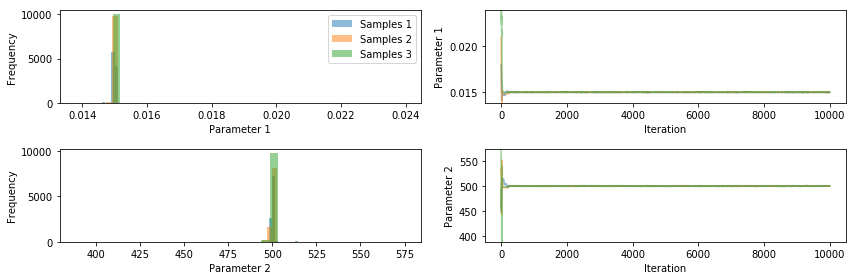

In [15]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Based on this plot, it looks like the three chains become very similar after about 1000 iterations.
To be safe, we throw away the first 2000 samples and continue our analysis with the first chain.

In [16]:
chain = chains[0]
chain = chain[2000:]

We can also look for autocorrelation in the chains, using the [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) method. If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

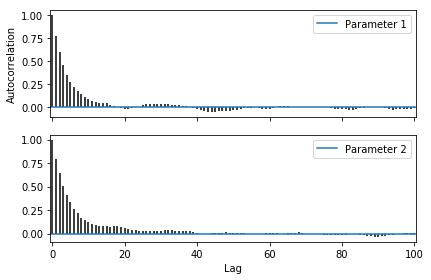

In [17]:
pints.plot.autocorrelation(chain)
plt.show()

Now we can inspect the inferred distribution by plotting histograms:

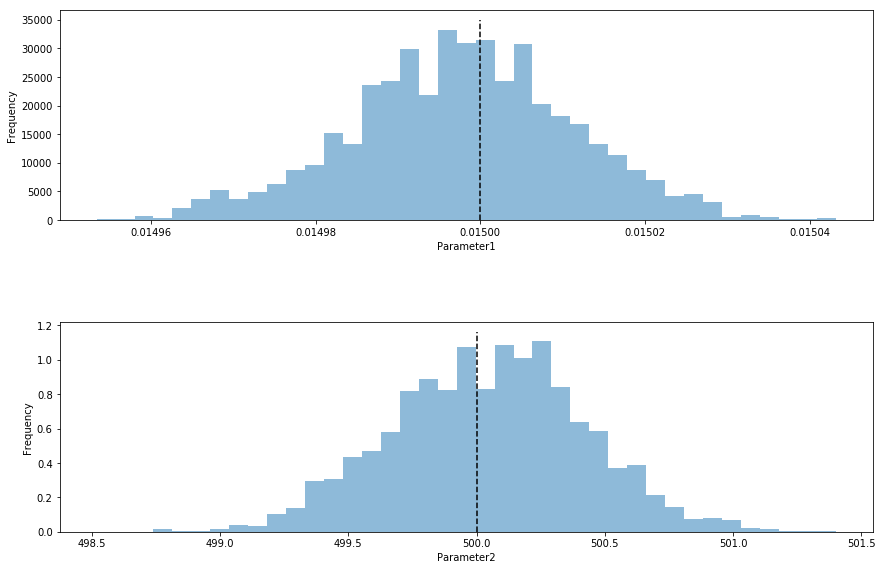

In [18]:
fig, axes = pints.plot.histogram([chain], ref_parameters=true_parameters)

# Show where the sample standard deviation of the generated noise is:
noise_sample_std = np.std(values - org_values)
#axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
#axes[-1].legend()

fig.set_size_inches(14, 9)
plt.show()

Here we've analysed each parameter in isolation, but we can also look at correlations between parameters we found using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

To speed things up, we'll first apply some _thinning_ to the chain:

In [19]:
thinned_chain = chain[::10]

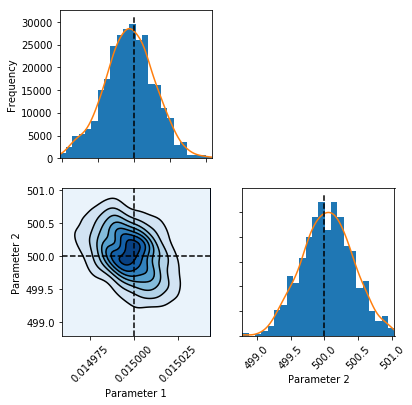

In [20]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

Finally, we can look at the bit that really matters: The model predictions made from models with the parameters we found (a _posterior predictive check_). Thes can be plotted using the [series()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.series) method.

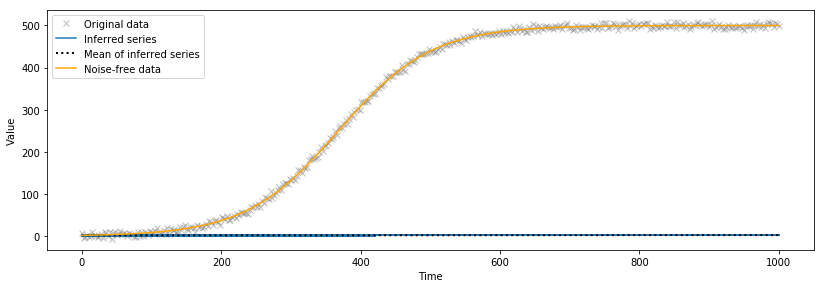

In [21]:
fig, axes = pints.plot.series(chain, problem)

# Customise the plot, and add the original, noise-free data
fig.set_size_inches(12,4.5)
plt.plot(times, org_values, c='orange', label='Noise-free data')
plt.legend()
plt.show()

-1272.54704347508
[0.74169215 1.00607376]
-1119646.9441391428


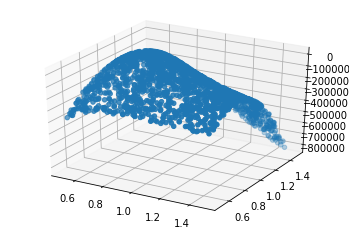

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
input_parameters[:5]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

print(max(likelihoods))
idx = list(likelihoods).index(max(likelihoods))
print(input_parameters[idx])
print(log_likelihood([0.015, 500]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [23]:
print(input_parameters[:5])

[[0.52362078 1.23727554]
 [0.57374387 0.5392193 ]
 [1.11763488 0.85690653]
 [0.54518296 0.98960415]
 [0.50669468 1.31070693]]


In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)

emu = pints.MultiLayerNN(problem, X_train, y_train, 
                          input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
#emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='tanh', learning_rate=0.00001)
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=100, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
#emu.summary()

In [25]:
emu([0.015, 500])

array([[-2.9752704e+08]], dtype=float32)

In [26]:
log_likelihood([0.015, 500])

-1119646.9441391428

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error', 'rescaled_mae', 'rescaled_mse', 'val_rescaled_mae', 'val_rescaled_mse'])


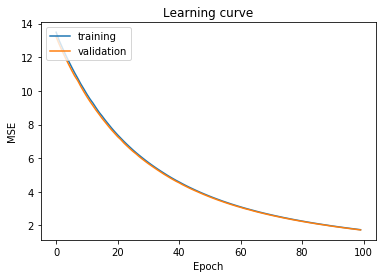

In [27]:
# summarize history for loss
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error', 'rescaled_mae', 'rescaled_mse', 'val_rescaled_mae', 'val_rescaled_mse'])


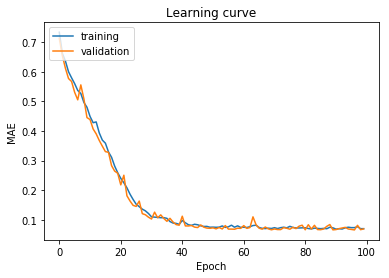

In [28]:
# summarize history for loss
print(hist.history.keys())
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('Learning curve')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

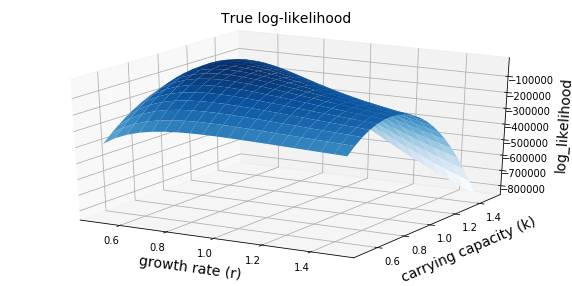

In [29]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), 
                                                  bounds.upper(), 
                                                  test_splits)

model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

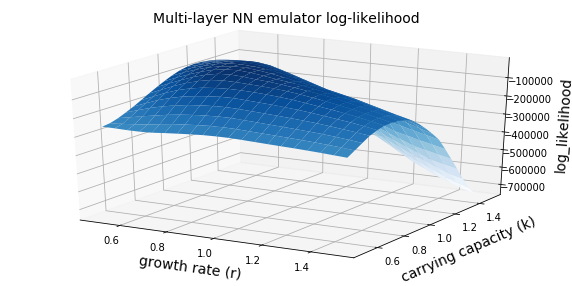

In [30]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, 
             k_grid, 
             emu_prediction, 
             title = "Multi-layer NN emulator log-likelihood",
             x_label = "growth rate (r)",
             y_label = "carrying capacity (k)")

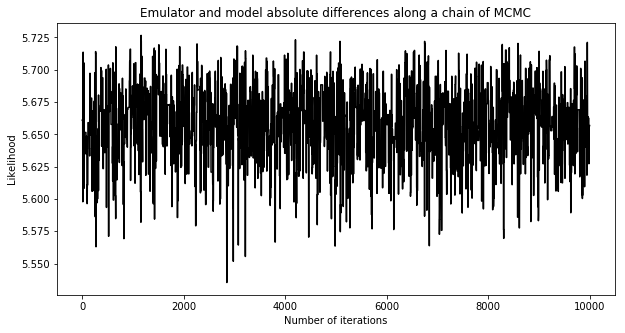

5.656760283521503

In [31]:
emu_prediction = np.apply_along_axis(emu, 1, chain_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain_rescaled).flatten()
diffs = (np.abs((model_prediction - emu_prediction) / model_prediction))

iters = np.linspace(0, 10000, len(chain_rescaled))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [32]:
print(emu_prediction)

[-7935.857  -7935.857  -7935.857  ... -7938.2007 -7938.2007 -7938.2007]


In [33]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)

In [34]:
chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
[0.81698537 1.04537168]
-15869.623046875
accepted


[1.35673964 1.10549481]
-222708.65625


[1.14759903 1.33311682]
-377157.46875


1     6      0.5       0         0          0:00.0
[0.67073484 0.99634114]
-21917.513671875


[1.05697884 1.18850319]
-171355.71875


[1.10520633 1.23142115]
-244767.1875


2     9      0.333     0         0          0:00.0
[0.9920101  1.10301216]
-82932.5234375


[1.10536505 0.94785817]
-61665.27734375
accepted


[1.45314988 1.02889512]
-207869.4375


3     12     0.25      0.25      0          0:00.0
[0.78497105 1.0917427 ]
-18702.857421875


[0.91166339 1.0107455 ]
-26810.435546875
accepted


[1.07351194 1.22184892]
-215536.84375


[0.86940632 1.03486828]
-21619.560546875


[0.75752898 1.04394732]
-9917.169921875
accepted


[1.20654643 0.97581366]
-95394.6093



[1.01055337 1.01738201]
-55784.75390625


[0.70368787 1.10874114]
-18584.123046875


[0.9158785  0.93517542]
-22145.779296875


[0.7367866  1.08576949]
-13974.310546875


[0.84139716 0.84916912]
-26317.232421875


[0.95522095 1.08269192]
-60585.62109375


[0.79308034 1.14316857]
-35495.08984375


[0.68605472 0.93110965]
-26219.123046875


[0.9405869  0.92385821]
-27458.998046875


[0.81957919 1.00441201]
-10820.279296875


[0.85134287 1.01210097]
-15406.154296875


[0.71626078 0.90041263]
-24343.419921875


[0.7804609  0.95848599]
-7181.63818359375
accepted


[0.91488107 0.85145577]
-32172.951171875


[0.69287461 0.98085506]
-17882.310546875


[0.6501845  0.89646845]
-48342.13671875


[0.81966821 0.8766331 ]
-16929.873046875


[0.63659337 0.99712135]
-31717.263671875


[0.90027854 0.8177499 ]
-40235.54296875


[0.73135758 0.88093697]
-25534.685546875


[0.53414215 1.0532846 ]
-61176.01953125


[0.86515113 1.03794716]
-21558.873046875


[0.69996793 0.95489551]
-18899.966796875


[0.75

[0.78289091 0.97808667]
-7126.31005859375


[0.94723339 0.93388226]
-28759.232421875


[0.71703519 0.90997102]
-21779.888671875


[0.99495963 0.82477723]
-45278.79296875


[0.76578558 1.08019018]
-14870.279296875


[0.80694828 1.0551638 ]
-15948.294921875


[0.65908203 1.13385761]
-28171.607421875


[0.73778768 1.01549411]
-8715.669921875


[0.71943007 0.88986399]
-26176.888671875


[0.80765316 1.16186134]
-46361.73046875


[0.9507894  1.05309924]
-48868.73046875


[0.80597302 0.75056838]
-72857.9140625


[0.71136381 1.01071172]
-11345.529296875


[0.69725355 0.84904095]
-45979.13671875


[0.80638704 0.87429843]
-17058.748046875


160   483    0.0186    0.0497    0.0807     0:00.7
[0.75079838 0.87812837]
-21878.529296875


[0.62714119 1.03709422]
-31118.341796875


[0.76523514 0.86260834]
-23572.091796875


[0.83868751 0.82070552]
-35707.08984375


[0.71261563 1.14136045]
-24869.701171875


[0.64111253 0.94491238]
-38915.08984375


[0.90658958 1.02567144]
-28056.576171875


[0.90526388

[0.79134475 0.96160043]
-6868.63818359375


[0.79033789 0.96070327]
-6894.18505859375


[0.7939764  0.96170883]
-6913.52880859375


[0.79193223 0.96125858]
-6865.35693359375


[0.78852386 0.96069035]
-6925.10693359375


[0.79203653 0.96049928]
-6871.01318359375


[0.79217794 0.96148702]
-6874.35693359375


[0.78916685 0.96090632]
-6908.54443359375


[0.79375786 0.96082906]
-6892.99755859375


[0.79179767 0.96083706]
-6866.07568359375


[0.7894435  0.96039019]
-6917.63818359375


[0.79242214 0.9607267 ]
-6865.09130859375
accepted


[0.79221974 0.96003679]
-6881.09130859375


[0.78983881 0.96223953]
-6874.35693359375


[0.79233031 0.96052011]
-6869.88818359375


[0.79226023 0.96055394]
-6869.09130859375


[0.79132712 0.96142837]
-6865.95068359375
accepted


[0.79371241 0.96101118]
-6895.43505859375


[0.79178015 0.96132891]
-6865.63818359375


[0.79072205 0.96228819]
-6877.38818359375


[0.79157305 0.96055084]
-6877.48193359375


[0.7919718  0.96060509]
-6869.31005859375


[0.79197513 0.

[0.79186704 0.96098316]
-6860.98193359375
accepted


[0.79183049 0.96099914]
-6861.18505859375


[0.79192692 0.96091974]
-6861.66943359375


320   963    0.134     0.115     0.115      0:01.7
[0.79185813 0.96099819]
-6860.85693359375
accepted


[0.79188164 0.96106025]
-6861.85693359375
accepted


[0.7920339  0.96105181]
-6863.49755859375


[0.79183526 0.96114298]
-6862.99755859375


[0.79168919 0.96111519]
-6862.20068359375


[0.79202325 0.9608332 ]
-6862.74755859375


[0.79179045 0.96079346]
-6867.32568359375


[0.79173423 0.96114813]
-6862.79443359375


[0.79179902 0.96096746]
-6862.57568359375


[0.79171605 0.9610674 ]
-6861.56005859375


[0.79166814 0.96120851]
-6863.51318359375


[0.7920777 0.9609515]
-6862.48193359375
accepted


[0.79183226 0.9610897 ]
-6862.23193359375


[0.79185024 0.96107196]
-6861.96630859375
accepted


[0.79208973 0.96096286]
-6862.91943359375
accepted


[0.79194158 0.96086974]
-6862.77880859375


[0.79173976 0.96118901]
-6863.46630859375


[0.79214313 0.960

accepted


[0.79209732 0.96090427]
-6861.96630859375
accepted


[0.79178751 0.96082072]
-6866.60693359375


[0.79233394 0.96055621]
-6868.95068359375


[0.79199406 0.96097466]
-6861.24755859375
accepted


[0.79173695 0.96092625]
-6864.70068359375
accepted


[0.79165705 0.96099142]
-6864.37255859375
accepted


[0.79193984 0.96106538]
-6862.10693359375
accepted


[0.79179821 0.96089628]
-6864.49755859375
accepted


[0.79140037 0.96115097]
-6864.40380859375
accepted


[0.79201023 0.96096697]
-6861.43505859375
accepted


[0.79180697 0.96095062]
-6862.91943359375
accepted


[0.79174951 0.96088983]
-6865.46630859375


[0.79189431 0.96098684]
-6860.77880859375
accepted


[0.79163898 0.96097331]
-6865.09130859375


[0.79187183 0.96089318]
-6863.31005859375
accepted


[0.79200034 0.96088764]
-6861.48193359375


[0.79201426 0.96090037]
-6861.18505859375
accepted


[0.79275166 0.96061657]
-6869.38818359375


[0.79184445 0.96101178]
-6861.01318359375
accepted


[0.79211772 0.96095309]
-6863.263183

[0.79240048 0.96077988]
-6865.59130859375


[0.79176072 0.96103243]
-6861.52880859375
accepted


[0.79189469 0.96102664]
-6861.40380859375


[0.79220152 0.96097709]
-6865.40380859375


[0.79172151 0.96101378]
-6862.68505859375


[0.79206001 0.9609161 ]
-6861.52880859375
accepted


[0.79174941 0.96100645]
-6862.38818359375
accepted


[0.79156356 0.96111679]
-6862.54443359375


[0.79203648 0.9608424 ]
-6862.48193359375


[0.79173279 0.9608744 ]
-6866.15380859375


[0.79180136 0.96106037]
-6861.65380859375
accepted


[0.79203635 0.96098385]
-6862.23193359375


[0.79139705 0.96110707]
-6865.65380859375


[0.7918232  0.96101784]
-6861.07568359375
accepted


[0.79217894 0.9606161 ]
-6867.71630859375


460   1383   0.215     0.236     0.249      0:02.4
[0.79211808 0.96092968]
-6862.84130859375
accepted


[0.79171042 0.96109326]
-6861.95068359375
accepted


[0.79175402 0.96116502]
-6863.16943359375


[0.79176182 0.96120881]
-6863.81005859375


[0.79160637 0.96121123]
-6863.45068359375
accepted

[0.79280786 0.96070884]
-6872.15380859375


[0.79200087 0.96082134]
-6863.07568359375


[0.79238944 0.96079982]
-6865.73193359375


[0.79272872 0.96067856]
-6870.07568359375


[0.79221711 0.96078768]
-6863.63818359375
accepted


[0.79155583 0.96111237]
-6862.85693359375


[0.79166566 0.96118994]
-6863.26318359375
accepted


[0.79190693 0.96088295]
-6863.02880859375
accepted


[0.79223953 0.96069157]
-6865.93505859375


[0.79207599 0.9608733 ]
-6861.74755859375
accepted


[0.79223955 0.96073159]
-6864.96630859375


[0.79231443 0.96067512]
-6866.18505859375


[0.79137263 0.96122564]
-6863.02880859375


[0.79213656 0.96073099]
-6865.04443359375
accepted


[0.79151419 0.96129051]
-6864.40380859375


[0.79190542 0.96087771]
-6863.15380859375


[0.79205723 0.96087112]
-6861.82568359375
accepted


[0.79231058 0.96066974]
-6866.37255859375


[0.79210444 0.96114513]
-6866.57568359375


[0.79180427 0.96097962]
-6862.13818359375


[0.79180819 0.96101223]
-6861.21630859375
accepted


[0.79275067 0

[0.79172619 0.96126263]
-6864.52880859375
accepted


[0.79114295 0.96128814]
-6865.12255859375


[0.79119306 0.96154474]
-6867.41943359375


[0.79153315 0.96171514]
-6870.88818359375


[0.79174567 0.96111247]
-6862.31005859375
accepted


[0.79196544 0.9611871 ]
-6864.71630859375


600   1803   0.233     0.268     0.275      0:03.2
[0.79098158 0.96139408]
-6865.01318359375


[0.79168313 0.96109889]
-6861.93505859375
accepted


[0.79220609 0.96096704]
-6865.29443359375
accepted


[0.79167528 0.96110311]
-6862.01318359375
accepted


[0.79162038 0.96117329]
-6862.91943359375


[0.79239871 0.96092504]
-6868.21630859375


[0.79133409 0.96124317]
-6863.26318359375


[0.79204829 0.96090621]
-6861.06005859375
accepted


[0.79207726 0.96108908]
-6865.02880859375
accepted


[0.79169907 0.96074852]
-6870.13818359375


[0.79253317 0.96045859]
-6871.06005859375


[0.7923076 0.9609349]
-6866.62255859375


[0.79187427 0.96093023]
-6862.26318359375
accepted


[0.79213712 0.96105848]
-6865.66943359375



accepted


[0.79132754 0.96119482]
-6864.46630859375


[0.79126283 0.96152437]
-6867.27880859375


[0.79180717 0.96158066]
-6869.54443359375


[0.79209711 0.96093507]
-6862.54443359375
accepted


[0.79198489 0.96103817]
-6862.31005859375
accepted


[0.79054293 0.96188646]
-6870.88818359375


[0.79187233 0.96100798]
-6861.06005859375
accepted


[0.79171173 0.96099421]
-6863.32568359375


[0.79188441 0.96105078]
-6861.68505859375
accepted


[0.79169186 0.96111687]
-6862.26318359375


[0.79228894 0.96073942]
-6864.74755859375


[0.79301446 0.96013057]
-6878.40380859375


[0.79174282 0.96071225]
-6870.29443359375


[0.79227329 0.96084376]
-6864.35693359375


[0.792048   0.96097603]
-6862.34130859375


[0.79219441 0.96086943]
-6863.20068359375


[0.79252672 0.96065633]
-6866.51318359375


[0.79164976 0.9606599 ]
-6873.23193359375


[0.79190957 0.9614522 ]
-6868.54443359375


[0.7916836  0.96089362]
-6866.46630859375


[0.79175175 0.9613093 ]
-6865.31005859375


[0.79236125 0.96067869]
-6866

[0.79196554 0.96069926]
-6866.85693359375


[0.79125799 0.96131293]
-6864.13818359375


[0.79153006 0.96118128]
-6862.77880859375


[0.79201832 0.96080037]
-6863.45068359375


[0.79211559 0.96112948]
-6866.48193359375


[0.79227114 0.96081564]
-6863.73193359375


[0.79214573 0.96060131]
-6868.02880859375


[0.79150462 0.96121272]
-6863.20068359375


[0.79164958 0.96125053]
-6864.18505859375


[0.79223978 0.96077011]
-6864.06005859375


[0.79166389 0.96115132]
-6862.73193359375


[0.79237644 0.96063971]
-6866.96630859375


[0.79190744 0.96093564]
-6861.59130859375
accepted


[0.792048   0.96105274]
-6863.76318359375


[0.79218468 0.96076038]
-6864.29443359375


[0.7919749  0.96064455]
-6868.18505859375


[0.79200096 0.96107654]
-6863.31005859375


[0.79207614 0.96057839]
-6868.57568359375


[0.79218239 0.96108098]
-6866.95068359375


[0.79164652 0.96119132]
-6863.24755859375
accepted


[0.79249327 0.96037264]
-6873.10693359375


[0.79181494 0.96127834]
-6865.02880859375


[0.79211362 0.



[0.79145997 0.96109954]
-6864.76318359375


[0.79220449 0.96103978]
-6866.59130859375


[0.79135103 0.96147531]
-6866.76318359375


[0.79178755 0.96115711]
-6863.10693359375
accepted


[0.79329619 0.96063604]
-6880.35693359375


[0.79210169 0.96076838]
-6864.23193359375


[0.79189238 0.96105226]
-6861.82568359375
accepted


[0.79022124 0.96163559]
-6871.41943359375


[0.79205419 0.96090235]
-6861.12255859375
accepted


820   2463   0.244     0.266     0.267      0:04.3
[0.79215162 0.96099134]
-6864.65380859375


[0.79182684 0.96084845]
-6865.26318359375


[0.7924564  0.96080684]
-6867.15380859375


[0.79149268 0.96108769]
-6864.52880859375


[0.79197944 0.96087779]
-6861.91943359375
accepted


[0.79238879 0.96063425]
-6867.06005859375


[0.7925838  0.96069212]
-6867.54443359375


[0.79240516 0.96061659]
-6867.51318359375


[0.79157754 0.96127465]
-6864.29443359375


[0.79176579 0.96082832]
-6866.82568359375


[0.79216512 0.96050677]
-6870.20068359375


[0.79195419 0.96107346]
-6862.3

[0.79320825 0.96057083]
-6877.45068359375


[0.7926028 0.9607745]
-6869.41943359375


[0.79079141 0.96179091]
-6870.07568359375


900   2703   0.252     0.267     0.262      0:04.7
[0.79239188 0.96088823]
-6867.40380859375


[0.79167054 0.96131281]
-6865.10693359375
accepted


[0.79136015 0.96159213]
-6868.54443359375


[0.79074533 0.96161881]
-6867.35693359375


[0.79160695 0.96151763]
-6868.04443359375


[0.79121217 0.96179043]
-6871.20068359375


[0.79251487 0.96077465]
-6867.70068359375


[0.79230857 0.96109341]
-6869.60693359375


[0.79094216 0.96211826]
-6875.37255859375


[0.79188293 0.96095036]
-6861.54443359375
accepted


[0.79251022 0.96051353]
-6869.82568359375


[0.79119577 0.96131078]
-6863.82568359375
accepted


[0.7921914  0.96065322]
-6866.76318359375


[0.79189939 0.96085964]
-6863.76318359375
accepted


[0.79093078 0.96119964]
-6871.01318359375


[0.79130242 0.96120268]
-6864.70068359375


[0.79108223 0.9615065 ]
-6866.60693359375


[0.79140928 0.96109455]
-6865.81005

[0.7917154  0.96123136]
-6864.02880859375


[0.79155844 0.96101828]
-6865.24755859375


[0.79217265 0.96080407]
-6863.34130859375


[0.79218461 0.96104001]
-6866.20068359375


[0.79179405 0.96100347]
-6861.70068359375
accepted


[0.79178106 0.96088144]
-6865.06005859375


[0.7914802  0.96134728]
-6865.13818359375


[0.79211902 0.96081432]
-6863.12255859375
accepted


[0.79140005 0.96135538]
-6865.09130859375


[0.79200918 0.96099168]
-6861.91943359375
accepted


[0.79298834 0.96042333]
-6871.56005859375


[0.79234265 0.96086288]
-6865.99755859375


[0.79206333 0.96095486]
-6862.26318359375
accepted


[0.79144682 0.96093269]
-6869.46630859375


[0.79201629 0.9609875 ]
-6861.93505859375


[0.79225755 0.96072804]
-6864.98193359375


[0.79272392 0.96045899]
-6870.95068359375


[0.7918295  0.96111807]
-6862.60693359375


[0.7928109  0.96037843]
-6872.73193359375


[0.7929981  0.96034027]
-6873.52880859375


[0.79219716 0.96080188]
-6863.41943359375


[0.79235928 0.9607014 ]
-6865.5756835937

[0.79092057 0.96146437]
-6865.54443359375


[0.79094094 0.96147918]
-6865.73193359375


[0.79205451 0.96083994]
-6862.57568359375


[0.79225333 0.96068892]
-6865.95068359375


[0.79232931 0.96065637]
-6866.60693359375


[0.79214703 0.96088891]
-6862.62255859375


[0.79161226 0.96113963]
-6862.35693359375
accepted


[0.79102413 0.96114884]
-6870.82568359375


[0.79200561 0.96077636]
-6864.18505859375


[0.79179174 0.96080518]
-6866.98193359375


[0.79148242 0.96118657]
-6862.79443359375


[0.79163491 0.96112063]
-6862.10693359375


[0.79082297 0.96143177]
-6866.73193359375


[0.79135052 0.96113336]
-6865.73193359375


[0.79174594 0.96101348]
-6862.23193359375


[0.79149316 0.96116218]
-6862.51318359375
accepted


[0.79167699 0.96120027]
-6863.43505859375


[0.79177547 0.9609166 ]
-6864.31005859375


[0.79119556 0.96137976]
-6864.90380859375


[0.79170871 0.96132226]
-6865.38818359375


[0.79161208 0.96090906]
-6867.29443359375


[0.79167168 0.96121411]
-6863.65380859375
accepted


[0.79

[0.7925071  0.96062285]
-6867.24755859375


[0.79135515 0.96134851]
-6864.85693359375


[0.79244557 0.960663  ]
-6866.35693359375


[0.79204231 0.96115481]
-6865.57568359375


[0.79153962 0.96121791]
-6863.37255859375


[0.79200844 0.96090047]
-6861.18505859375
accepted


[0.79151774 0.96121536]
-6863.29443359375


[0.79191368 0.96112631]
-6862.95068359375


[0.79239034 0.96068573]
-6865.88818359375


[0.79137251 0.96156526]
-6868.18505859375


[0.7901901  0.96159638]
-6872.98193359375


[0.79232286 0.96086953]
-6865.68505859375


[0.79160786 0.96133156]
-6865.26318359375


[0.79253142 0.96059703]
-6867.88818359375


[0.79209563 0.96095234]
-6862.87255859375


[0.79195626 0.96100315]
-6861.20068359375
accepted


[0.7921433  0.96105856]
-6865.77880859375


[0.79165273 0.96106554]
-6862.46630859375


[0.79192815 0.96089436]
-6862.31005859375


[0.79231438 0.96058149]
-6868.37255859375


[0.79181942 0.9609128 ]
-6863.71630859375


[0.79195126 0.96107514]
-6862.31005859375
accepted


[0.79

[0.79124956 0.96133711]
-6864.37255859375


[0.79230118 0.96064425]
-6866.91943359375


[0.79184777 0.96110336]
-6862.41943359375


[0.7897794  0.96185127]
-6873.15380859375


[0.79220626 0.96101875]
-6866.21630859375


[0.79257398 0.96063289]
-6866.99755859375


[0.7909717  0.96122755]
-6869.56005859375


[0.79162993 0.96106704]
-6862.74755859375


[0.79163161 0.9612174 ]
-6863.57568359375


[0.79030401 0.96170656]
-6868.15380859375


[0.79235152 0.9607086 ]
-6865.40380859375


[0.79197244 0.96078773]
-6864.40380859375


[0.79103602 0.9613607 ]
-6864.98193359375


[0.79143738 0.96118239]
-6862.95068359375


[0.79195562 0.96085264]
-6862.99755859375
accepted


[0.79134429 0.96122776]
-6863.32568359375
accepted


[0.79097446 0.96121958]
-6869.77880859375


[0.79226538 0.96045237]
-6871.37255859375


[0.7933764 0.9605404]
-6880.16943359375


[0.79224964 0.96079331]
-6863.52880859375


[0.79237885 0.96067683]
-6866.10693359375


[0.7913597  0.96138969]
-6865.46630859375


[0.79141262 0.96

[0.79090803 0.96138962]
-6866.35693359375


[0.79213811 0.96076372]
-6864.31005859375


[0.79231152 0.96089742]
-6866.04443359375


[0.79194505 0.96103425]
-6861.62255859375
accepted


[0.79276854 0.9606908 ]
-6871.07568359375


[0.79202711 0.9609993 ]
-6862.37255859375
accepted


[0.79290397 0.96051063]
-6870.40380859375


[0.79208883 0.96096197]
-6862.90380859375
accepted


[0.79190068 0.96103386]
-6861.56005859375
accepted


[0.79237667 0.960878  ]
-6866.91943359375


[0.79195489 0.96111213]
-6863.06005859375
accepted


[0.79176815 0.96100714]
-6862.07568359375
accepted


[0.79151533 0.96126117]
-6863.91943359375


[0.79301279 0.96075315]
-6877.02880859375


[0.79147269 0.96106758]
-6865.40380859375


[0.79129434 0.96114112]
-6866.46630859375


[0.79215796 0.9611233 ]
-6867.27880859375


[0.79178467 0.96096827]
-6862.85693359375
accepted


[0.79229715 0.96092309]
-6866.21630859375


[0.79201011 0.96109612]
-6863.85693359375
accepted


[0.7913968  0.96098973]
-6868.77880859375


[0.7

[0.79151294 0.96096191]
-6867.54443359375


[0.79176405 0.96118022]
-6863.32568359375


[0.79201453 0.96077823]
-6864.06005859375


[0.7921469 0.9606244]
-6867.54443359375


[0.79197825 0.96088287]
-6861.74755859375
accepted


[0.79186007 0.96089747]
-6863.40380859375


[0.79125633 0.96104421]
-6869.62255859375


[0.79236569 0.96084959]
-6866.16943359375


[0.79245641 0.9605007 ]
-6870.16943359375


[0.79261052 0.96064562]
-6867.15380859375


[0.79235842 0.96058648]
-6868.27880859375


[0.79219956 0.96059052]
-6868.31005859375


[0.79162945 0.96118656]
-6863.16943359375
accepted


[0.79212444 0.960803  ]
-6863.37255859375


[0.79225536 0.96070044]
-6865.65380859375


1400  4203   0.253     0.241     0.261      0:06.9
[0.79129756 0.96130125]
-6863.96630859375
accepted


[0.79239048 0.96060373]
-6867.82568359375


[0.7916595  0.96118057]
-6863.07568359375
accepted


[0.79232426 0.96071539]
-6865.29443359375


[0.79165582 0.96105483]
-6862.66943359375
accepted


[0.79198244 0.96112354]
-6

-6863.93505859375


[0.79188068 0.96100395]
-6861.02880859375


[0.79071413 0.9618    ]
-6870.04443359375


[0.79223331 0.96075267]
-6864.43505859375


[0.79219367 0.96101092]
-6865.84130859375


[0.79287492 0.96075612]
-6874.35693359375


[0.7914096  0.96147599]
-6866.90380859375


[0.79261678 0.96079422]
-6870.01318359375


[0.79226546 0.96116844]
-6870.18505859375


[0.79129633 0.96144672]
-6866.21630859375


[0.79184235 0.96115298]
-6863.15380859375


[0.79291883 0.96060985]
-6872.49755859375


[0.7921635 0.9608034]
-6863.34130859375


[0.79151902 0.96124917]
-6863.82568359375


[0.79137893 0.96173834]
-6870.73193359375


[0.79183695 0.96111906]
-6862.63818359375
accepted


[0.79247703 0.9604937 ]
-6870.26318359375


[0.79223543 0.96095087]
-6865.54443359375
accepted


[0.7908894  0.96160374]
-6867.48193359375


[0.79167985 0.96098374]
-6864.20068359375


[0.79280101 0.96048289]
-6870.27880859375


[0.79223253 0.9605921 ]
-6868.21630859375


[0.79178152 0.96111733]
-6862.5131835937



[0.79084551 0.96156944]
-6866.87255859375


[0.79241581 0.96076361]
-6865.56005859375


[0.79154864 0.96122975]
-6863.57568359375


[0.7922005  0.96060358]
-6867.93505859375


[0.79147689 0.96152097]
-6867.79443359375


[0.7919154  0.96095978]
-6860.87255859375
accepted


[0.79203987 0.96060309]
-6868.20068359375


[0.79155688 0.96091184]
-6868.16943359375


[0.79181378 0.96109762]
-6862.31005859375


[0.79204533 0.96114967]
-6865.52880859375


[0.79166039 0.96152548]
-6868.32568359375


[0.79240041 0.96041142]
-6872.27880859375


[0.79190962 0.96125888]
-6864.96630859375


[0.79200613 0.96095921]
-6861.27880859375
accepted


[0.79193646 0.96073342]
-6866.48193359375


[0.79163245 0.96142186]
-6866.73193359375


[0.79150957 0.96123167]
-6863.51318359375


[0.79287186 0.96033521]
-6873.71630859375


[0.79165408 0.96076549]
-6870.37255859375


[0.79268402 0.96048161]
-6870.40380859375


[0.79176648 0.96105244]
-6861.45068359375


[0.79271356 0.96039516]
-6872.45068359375


[0.79234431 

[0.79170017 0.96127137]
-6864.62255859375


[0.79145052 0.96111945]
-6864.40380859375


[0.79159173 0.96093065]
-6867.01318359375


[0.79175266 0.96086794]
-6865.98193359375


[0.79214737 0.96100114]
-6864.73193359375


[0.79217198 0.96081768]
-6863.01318359375
accepted


[0.79205123 0.96091756]
-6861.27880859375
accepted


[0.79216712 0.96095874]
-6864.34130859375
accepted


[0.79238402 0.96061436]
-6867.59130859375


[0.79225222 0.96030065]
-6874.98193359375


[0.79196564 0.96130471]
-6866.82568359375


[0.79164415 0.96129265]
-6864.76318359375
accepted


[0.79215191 0.9612789 ]
-6870.07568359375


[0.79206042 0.96091992]
-6861.56005859375
accepted


[0.79189371 0.96093502]
-6861.82568359375
accepted


1660  4983   0.246     0.235     0.258      0:08.1
[0.79211701 0.96086225]
-6861.99755859375


[0.79202758 0.96092597]
-6860.99755859375
accepted


[0.79174255 0.9610952 ]
-6862.10693359375
accepted


[0.79292458 0.96063057]
-6873.06005859375


[0.79201868 0.96103586]
-6862.87255859375

[0.79276477 0.96054216]
-6868.96630859375


[0.79154483 0.96133566]
-6865.13818359375


[0.79265695 0.96061035]
-6867.49755859375


[0.79153315 0.96125399]
-6863.87255859375
accepted


[0.79173608 0.96133495]
-6865.65380859375


[0.79136382 0.96130802]
-6864.26318359375


[0.79150116 0.96145679]
-6866.87255859375


[0.79112906 0.96134513]
-6864.23193359375


[0.79246624 0.96058398]
-6868.21630859375


[0.79173544 0.96131016]
-6865.27880859375


[0.79123836 0.96129682]
-6863.77880859375


[0.79186414 0.96090806]
-6863.07568359375


[0.79158029 0.96142535]
-6866.52880859375


[0.79056278 0.96177618]
-6869.26318359375


[0.79261409 0.96071106]
-6868.51318359375


[0.79238136 0.96100029]
-6869.34130859375


[0.79156935 0.96124438]
-6863.91943359375


[0.79179874 0.9609512 ]
-6863.02880859375


[0.7904974  0.96189703]
-6870.88818359375


[0.7920754  0.96079977]
-6863.43505859375
accepted


[0.79284862 0.960496  ]
-6869.99755859375


[0.79233322 0.9608918 ]
-6866.34130859375


[0.79267417 0.

[0.7908334  0.96132209]
-6869.41943359375


[0.79223709 0.96096131]
-6865.77880859375


[0.79172787 0.96137035]
-6866.12255859375


[0.7899401  0.96209418]
-6872.52880859375


[0.79099305 0.96160164]
-6867.76318359375


[0.79179573 0.960915  ]
-6863.99755859375
accepted


[0.7919355  0.96084962]
-6863.38818359375


[0.79225957 0.96066257]
-6866.49755859375


[0.79067766 0.96179396]
-6869.81005859375


[0.79188932 0.96121527]
-6864.24755859375


[0.79166426 0.96121043]
-6863.54443359375


[0.7905928  0.96154846]
-6867.41943359375


[0.7912316  0.96153374]
-6867.35693359375


[0.79188791 0.9611133 ]
-6862.68505859375


[0.79233312 0.96101372]
-6868.60693359375


[0.79160603 0.96135381]
-6865.62255859375


[0.79162296 0.96102844]
-6863.91943359375


[0.79115421 0.96088443]
-6875.71630859375


1840  5523   0.239     0.235     0.253      0:08.8
[0.79181695 0.96078727]
-6867.04443359375


[0.7924828  0.96085564]
-6868.60693359375


[0.79124532 0.96191071]
-6873.09130859375


[0.79161206 0.96

[0.79126832 0.96144843]
-6866.15380859375


[0.79313172 0.960265  ]
-6875.13818359375


[0.79162243 0.96119741]
-6863.29443359375


[0.79097886 0.96179524]
-6870.66943359375


[0.79261546 0.96056141]
-6868.63818359375


[0.79220255 0.96087194]
-6863.45068359375


[0.79112064 0.96166077]
-6868.95068359375


[0.79175326 0.96125351]
-6864.48193359375


[0.79167295 0.96148987]
-6867.79443359375


[0.79201399 0.9611275 ]
-6864.52880859375


[0.79257409 0.96067526]
-6867.02880859375


[0.79173766 0.96102789]
-6861.95068359375
accepted


[0.79119921 0.96124792]
-6865.20068359375


[0.79189998 0.9608682 ]
-6863.45068359375
accepted


[0.79136504 0.96128472]
-6863.93505859375


[0.79138856 0.96147813]
-6866.87255859375


[0.79128386 0.96124969]
-6863.70068359375
accepted


[0.79072792 0.9617704 ]
-6869.62255859375


[0.79163675 0.96105673]
-6862.98193359375
accepted


[0.79118088 0.96138877]
-6865.01318359375
accepted


[0.79228454 0.96080641]
-6863.84130859375


[0.79229616 0.96085259]
-6864.9

[0.79186148 0.9610564 ]
-6861.74755859375
accepted


[0.79175478 0.9606715 ]
-6871.15380859375


[0.79089776 0.96156798]
-6867.01318359375


[0.7920746  0.96093464]
-6862.09130859375


[0.79222095 0.96074899]
-6864.51318359375


[0.79130964 0.96125598]
-6863.34130859375


2020  6063   0.237     0.241     0.246      0:09.5
[0.79266796 0.96089201]
-6872.87255859375


[0.79275356 0.96032299]
-6874.09130859375


[0.79178991 0.96130608]
-6865.32568359375


[0.79170882 0.96107385]
-6861.65380859375
accepted


[0.79156829 0.96130353]
-6864.70068359375


[0.79157959 0.96118389]
-6862.98193359375
accepted


[0.79170381 0.96094449]
-6864.76318359375


[0.79132582 0.96127422]
-6863.70068359375
accepted


[0.79111604 0.96160136]
-6868.07568359375


[0.79267504 0.96059563]
-6867.77880859375


[0.7905619  0.96162949]
-6867.09130859375


[0.79135429 0.96140409]
-6865.70068359375
accepted


[0.79116691 0.96123323]
-6866.18505859375


[0.79141087 0.96131259]
-6864.51318359375


[0.79120891 0.96178743]


[0.79232233 0.96076242]
-6864.13818359375


[0.79249515 0.960885  ]
-6869.37255859375


[0.79141314 0.96119826]
-6862.98193359375
accepted


[0.79194816 0.96084324]
-6863.37255859375


[0.79219754 0.960982  ]
-6865.38818359375


[0.79039658 0.96176791]
-6868.68505859375


[0.79238385 0.96081026]
-6865.81005859375


[0.79179101 0.96135431]
-6866.09130859375


[0.79171996 0.96125295]
-6864.40380859375


[0.7907524  0.96152093]
-6865.91943359375


[0.79171469 0.96108819]
-6861.79443359375


[0.79156702 0.9611687 ]
-6862.71630859375
accepted


[0.79156168 0.96134387]
-6865.27880859375


[0.79177071 0.96111344]
-6862.35693359375


[0.79101428 0.96114937]
-6870.93505859375


[0.79192025 0.96118012]
-6863.77880859375


[0.79161739 0.96117817]
-6862.95068359375


[0.79170562 0.96081834]
-6868.04443359375


[0.79174508 0.96134924]
-6865.84130859375


[0.79233903 0.96109451]
-6870.31005859375


[0.79054877 0.96184229]
-6870.23193359375


[0.79163703 0.96115696]
-6862.68505859375


[0.79211073 0.

[0.79185583 0.96092197]
-6862.87255859375


[0.79168082 0.96078068]
-6869.52880859375


[0.79213257 0.96094946]
-6863.51318359375


[0.79215686 0.96114608]
-6867.65380859375


[0.79262577 0.96031384]
-6874.35693359375


[0.79215958 0.96075728]
-6864.40380859375


[0.79137971 0.96111209]
-6865.84130859375


[0.79214188 0.96101677]
-6864.98193359375


[0.79215657 0.96089043]
-6862.91943359375


[0.79090883 0.96159799]
-6867.43505859375


[0.79167736 0.96091129]
-6866.16943359375


[0.79147833 0.96130018]
-6864.45068359375


[0.79212238 0.96083927]
-6862.54443359375


[0.79219991 0.96081944]
-6862.90380859375


[0.79174581 0.96079   ]
-6868.16943359375


[0.79208395 0.96106971]
-6864.82568359375


[0.79203105 0.96095401]
-6861.59130859375
accepted


[0.79190763 0.96090921]
-6862.23193359375
accepted


[0.79200987 0.96092051]
-6860.73193359375
accepted


[0.79162215 0.96135495]
-6865.62255859375


[0.79179328 0.96128398]
-6865.01318359375


[0.79244102 0.96061208]
-6867.57568359375


[0.79

-6864.40380859375


[0.79196704 0.96102525]
-6861.68505859375


[0.79179115 0.96095119]
-6863.12255859375


[0.79215203 0.96085252]
-6862.21630859375
accepted


[0.79284531 0.96042162]
-6871.68505859375


[0.79157985 0.96126065]
-6864.10693359375


[0.79137101 0.96123486]
-6863.24755859375


[0.79197557 0.96097696]
-6860.95068359375
accepted


[0.79184508 0.96099287]
-6861.09130859375
accepted


[0.79333984 0.96024544]
-6875.48193359375


[0.79169476 0.96117609]
-6863.16943359375


[0.79114076 0.96139145]
-6864.98193359375


[0.79287687 0.96043086]
-6871.51318359375


[0.79273549 0.96073179]
-6871.12255859375


[0.79146021 0.96103508]
-6866.48193359375


[0.79034965 0.96184626]
-6869.77880859375


[0.79164134 0.96100349]
-6864.24755859375


[0.79213744 0.96100176]
-6864.60693359375


[0.79234725 0.960765  ]
-6864.31005859375


[0.79189136 0.96093775]
-6861.79443359375


[0.79263948 0.96067439]
-6868.32568359375


[0.79227016 0.9609374 ]
-6865.93505859375


2300  6903   0.239     0.2342

[0.79089609 0.96143845]
-6865.29443359375


[0.79225468 0.96080178]
-6863.31005859375


[0.79221099 0.9606227 ]
-6867.49755859375


[0.79301449 0.96063546]
-6874.87255859375


[0.79211649 0.96089431]
-6862.15380859375


[0.79306842 0.96038555]
-6872.32568359375


[0.79149959 0.96130129]
-6864.48193359375


[0.79310313 0.9604569 ]
-6873.29443359375


[0.79169005 0.96100543]
-6863.40380859375
accepted


[0.79190244 0.96099591]
-6860.93505859375
accepted


[0.79174673 0.96095022]
-6863.87255859375


[0.7909257 0.9614814]
-6865.77880859375


[0.79199406 0.96101897]
-6862.07568359375


[0.79179994 0.96097506]
-6862.32568359375


[0.79148264 0.96105808]
-6865.51318359375


[0.7921748  0.96085612]
-6862.57568359375


[0.79236604 0.96059097]
-6868.18505859375


[0.79165558 0.96106228]
-6862.41943359375
accepted


[0.79199103 0.96088568]
-6861.54443359375


[0.79173533 0.9610638 ]
-6861.54443359375


[0.79225463 0.96080888]
-6863.26318359375


[0.79196579 0.96100025]
-6861.20068359375


[0.7921

[0.79214873 0.96118315]
-6868.20068359375


[0.79171543 0.96097333]
-6863.82568359375


[0.79209779 0.96083924]
-6862.49755859375
accepted


[0.79226514 0.96102911]
-6867.52880859375


[0.79118102 0.96138661]
-6864.96630859375


[0.79219204 0.96069376]
-6865.85693359375


[0.79251242 0.96078461]
-6867.84130859375


[0.79195778 0.96086021]
-6862.66943359375
accepted


[0.79154165 0.96121253]
-6863.27880859375
accepted


[0.79196054 0.96112691]
-6863.45068359375


[0.79181734 0.96096333]
-6862.41943359375
accepted


[0.7912885  0.96127576]
-6863.65380859375


[0.79186679 0.96105004]
-6861.68505859375
accepted


[0.79215315 0.96077883]
-6863.90380859375
accepted


[0.79292421 0.96035272]
-6873.24755859375


[0.79206456 0.96088052]
-6861.62255859375
accepted


[0.79204404 0.96057192]
-6868.88818359375


[0.79222413 0.96102582]
-6866.71630859375


2480  7443   0.239     0.236     0.25       0:11.4
[0.79171448 0.96117279]
-6863.16943359375
accepted


[0.79199754 0.96117925]
-6865.13818359375

[0.79122948 0.96111597]
-6868.18505859375


[0.7913909  0.96100903]
-6868.32568359375


[0.79149712 0.96106006]
-6865.13818359375


2560  7683   0.240531  0.238     0.25       0:11.8
[0.79190618 0.96114252]
-6863.21630859375


[0.7913618  0.96130153]
-6864.21630859375


[0.79190345 0.96096067]
-6860.95068359375
accepted


[0.79154082 0.96099577]
-6866.18505859375


[0.79167858 0.96094235]
-6865.23193359375
accepted


[0.79184006 0.96123605]
-6864.45068359375


[0.79150603 0.96087308]
-6870.02880859375


[0.7917303  0.96078865]
-6868.46630859375


[0.79194907 0.96085643]
-6862.99755859375


[0.79217914 0.96054008]
-6869.48193359375


[0.79203965 0.96102916]
-6863.26318359375
accepted


[0.79175858 0.96091023]
-6864.71630859375


[0.79244518 0.96054528]
-6869.12255859375


[0.79210749 0.96119092]
-6867.49755859375


[0.7916866 0.9610151]
-6863.13818359375


[0.79206897 0.96062859]
-6867.49755859375


[0.79218669 0.96062625]
-6867.45068359375


[0.79219112 0.96071583]
-6865.37255859375




[0.79220227 0.96093265]
-6864.60693359375
accepted


[0.79207834 0.96097792]
-6862.99755859375


[0.79271552 0.96052893]
-6869.29443359375


[0.79200942 0.96094921]
-6861.07568359375
accepted


[0.7919326  0.96092905]
-6861.38818359375
accepted


[0.79174512 0.96109221]
-6862.01318359375
accepted


[0.79217602 0.96113285]
-6867.76318359375


[0.79210753 0.96078507]
-6863.81005859375


[0.79161372 0.96104456]
-6863.65380859375


[0.79230585 0.96071356]
-6865.31005859375


[0.79197042 0.96088902]
-6861.71630859375


[0.79095852 0.96160473]
-6867.70068359375


[0.79197045 0.96113058]
-6863.63818359375


[0.79169169 0.96111339]
-6862.18505859375


[0.79229347 0.96039063]
-6872.82568359375


[0.792175   0.96102406]
-6865.70068359375


[0.79176305 0.96096011]
-6863.40380859375


[0.79169448 0.96132333]
-6865.32568359375


[0.79178926 0.96102566]
-6861.15380859375
accepted


[0.79167366 0.96102543]
-6863.13818359375


[0.79181385 0.96124547]
-6864.49755859375


[0.79108245 0.96114043]
-6870.0

[0.79212797 0.96074076]
-6864.79443359375


[0.79246334 0.9608971 ]
-6868.96630859375


[0.79161714 0.96116301]
-6862.68505859375
accepted


[0.79224848 0.96075341]
-6864.43505859375


[0.79170963 0.96105987]
-6861.65380859375
accepted


[0.79122913 0.96160052]
-6868.29443359375


[0.7926321  0.96071114]
-6868.87255859375


[0.79156106 0.96087627]
-6868.99755859375


[0.79069277 0.9615318 ]
-6866.18505859375
accepted


[0.79124448 0.96120227]
-6865.70068359375


[0.7917278 0.9607025]
-6870.81005859375


[0.79033064 0.96191563]
-6870.76318359375


[0.79239269 0.96070687]
-6865.43505859375


[0.79156733 0.96102266]
-6864.99755859375


[0.79253837 0.96027506]
-6875.34130859375


[0.79182488 0.96088589]
-6864.31005859375


[0.79187769 0.96084649]
-6864.48193359375


[0.79046056 0.96131828]
-6875.77880859375


[0.79200202 0.96112698]
-6864.21630859375


[0.79228324 0.96097951]
-6867.02880859375


[0.79122716 0.96110702]
-6868.49755859375


[0.79289161 0.96039743]
-6872.26318359375


[0.7913

[0.79189724 0.96094236]
-6861.57568359375
accepted


[0.79144402 0.9612228 ]
-6863.20068359375


[0.79164529 0.96103144]
-6863.51318359375
accepted


[0.79139454 0.96103118]
-6867.70068359375


[0.79160025 0.96102654]
-6864.35693359375


[0.79122889 0.96152499]
-6867.21630859375


[0.79163186 0.96130287]
-6864.87255859375


[0.79176271 0.96120262]
-6863.73193359375


[0.79124548 0.96137854]
-6865.01318359375


[0.79199811 0.96083508]
-6862.73193359375


[0.79137956 0.96114058]
-6865.02880859375


[0.79183896 0.96105305]
-6861.68505859375
accepted


[0.79136521 0.96110002]
-6866.37255859375


[0.79176176 0.96119264]
-6863.57568359375


[0.79198939 0.96091142]
-6860.98193359375
accepted


[0.79126381 0.96136064]
-6864.76318359375


[0.79040283 0.96202347]
-6872.57568359375


[0.79216425 0.9606899 ]
-6865.93505859375


[0.79190534 0.96110734]
-6862.62255859375
accepted


[0.79266318 0.96041419]
-6872.01318359375


[0.79207122 0.96059291]
-6868.27880859375


[0.79168064 0.96114499]
-6862.6



[0.79152627 0.96110395]
-6863.54443359375
accepted


[0.79196122 0.96099406]
-6861.12255859375
accepted


[0.79241432 0.96065746]
-6866.49755859375


[0.79259423 0.96070196]
-6867.88818359375


[0.79162077 0.96111497]
-6862.07568359375


[0.79181936 0.96081913]
-6866.15380859375


[0.7918011  0.96112011]
-6862.52880859375
accepted


[0.79205855 0.96089038]
-6861.38818359375
accepted


[0.79176919 0.9609468 ]
-6863.68505859375


[0.79139422 0.96112933]
-6865.06005859375


[0.79194522 0.96084583]
-6863.37255859375


[0.79099879 0.96179228]
-6870.68505859375


[0.79175598 0.96139665]
-6866.60693359375


[0.79229164 0.96073391]
-6864.82568359375


[0.7927374  0.96045336]
-6871.09130859375


[0.79164927 0.96113407]
-6862.37255859375
accepted


[0.79175041 0.96099043]
-6862.77880859375
accepted


[0.79179166 0.96088155]
-6864.93505859375


[0.79203625 0.96114584]
-6865.24755859375


[0.7912753  0.96105353]
-6869.12255859375


[0.79201141 0.96079531]
-6863.60693359375


[0.79226788 0.961047

[0.79093631 0.96147828]
-6865.71630859375


[0.79276065 0.96036335]
-6873.21630859375


[0.79181886 0.96089383]
-6864.23193359375


[0.79244176 0.96062569]
-6867.26318359375


[0.7916744  0.96115605]
-6862.79443359375
accepted


[0.79186433 0.96088387]
-6863.66943359375


[0.79084099 0.96156205]
-6866.74755859375


[0.79139533 0.96143433]
-6866.23193359375


[0.7917187  0.96112652]
-6862.46630859375


[0.79221414 0.96105979]
-6867.10693359375


[0.79182257 0.96125975]
-6864.74755859375


[0.79164365 0.96123507]
-6863.81005859375


[0.79084208 0.96187281]
-6871.46630859375


[0.7922863  0.96062769]
-6867.38818359375


[0.79161232 0.9611548 ]
-6862.62255859375


[0.79046932 0.961851  ]
-6870.15380859375


[0.79167279 0.9611717 ]
-6862.95068359375
accepted


[0.79225073 0.96067014]
-6866.32568359375


[0.79060425 0.96167526]
-6867.88818359375


[0.79164678 0.96092966]
-6866.16943359375


[0.79165553 0.96111564]
-6862.13818359375
accepted


[0.79119148 0.96143847]
-6865.73193359375


[0.79

[0.79247153 0.96069568]
-6865.62255859375


[0.7923359  0.96122608]
-6872.65380859375


[0.79191514 0.96097863]
-6860.74755859375
accepted


[0.79230101 0.96091806]
-6866.23193359375


[0.79225914 0.96065859]
-6866.62255859375


[0.79191205 0.96093334]
-6861.57568359375
accepted


3100  9303   0.236     0.247     0.246      0:14.0
[0.79089305 0.96157825]
-6867.16943359375


[0.79222886 0.96099644]
-6866.23193359375


[0.79169679 0.96109949]
-6862.01318359375


[0.79168286 0.96100511]
-6863.51318359375
accepted


[0.79237465 0.96139654]
-6876.57568359375


[0.79248234 0.96068541]
-6865.84130859375


[0.79209905 0.96087022]
-6861.81005859375
accepted


[0.79262307 0.96054055]
-6869.13818359375


[0.79178214 0.96101927]
-6861.51318359375
accepted


[0.79264697 0.96064367]
-6867.84130859375


[0.79195863 0.96074896]
-6865.65380859375


[0.79207858 0.9607603 ]
-6864.45068359375


[0.79221459 0.96085549]
-6863.40380859375
accepted


[0.79178693 0.96100751]
-6861.65380859375
accepted


[0.791


[0.79109192 0.96120966]
-6868.04443359375


[0.79213718 0.96114901]
-6867.29443359375


[0.79137902 0.96140683]
-6865.79443359375
accepted


[0.79199562 0.96052323]
-6871.01318359375


[0.79139476 0.96144633]
-6866.41943359375


[0.79133105 0.96173298]
-6870.56005859375


[0.79210725 0.96070923]
-6865.56005859375


[0.79279643 0.96054399]
-6868.95068359375


[0.79248913 0.96081087]
-6867.82568359375


[0.79027063 0.96167243]
-6869.57568359375


[0.79209887 0.96082654]
-6862.81005859375


[0.79195979 0.96108234]
-6862.62255859375
accepted


[0.79148383 0.96111755]
-6863.85693359375
accepted


[0.79193258 0.96111226]
-6862.84130859375


[0.79211698 0.9609332 ]
-6862.88818359375


[0.79248933 0.96031611]
-6874.40380859375


[0.79157738 0.96123025]
-6863.66943359375


[0.79248533 0.96079314]
-6867.49755859375


[0.79153404 0.96101146]
-6865.85693359375


[0.79340562 0.96023472]
-6875.66943359375


[0.79223842 0.96071805]
-6865.26318359375


[0.79212397 0.96074558]
-6864.71630859375


[0.7

accepted


[0.79213867 0.96115263]
-6867.41943359375


[0.79209168 0.9606582 ]
-6866.73193359375


[0.79189211 0.96076507]
-6866.34130859375


[0.79121906 0.96156277]
-6867.70068359375


[0.79207716 0.96085369]
-6862.24755859375


[0.79248289 0.96073217]
-6866.31005859375


[0.7935975  0.96016802]
-6877.56005859375


[0.79269591 0.96049004]
-6870.26318359375


[0.79175058 0.9608828 ]
-6865.66943359375


[0.79218279 0.96089722]
-6863.56005859375


[0.79162037 0.96105441]
-6863.29443359375


[0.79162614 0.96107239]
-6862.74755859375
accepted


[0.79108079 0.96128325]
-6866.29443359375


[0.79202391 0.96102789]
-6862.84130859375


[0.79187672 0.96096111]
-6861.40380859375
accepted


[0.79299322 0.96050458]
-6872.01318359375


[0.79250088 0.96062981]
-6867.10693359375


[0.79155892 0.9608138 ]
-6870.73193359375


[0.79111659 0.9615807 ]
-6867.76318359375


[0.79173419 0.96104883]
-6861.51318359375
accepted


[0.79225682 0.96088718]
-6864.74755859375


[0.79176185 0.96118182]
-6863.38818359

[0.79115073 0.96140286]
-6865.09130859375


[0.79043682 0.96171603]
-6868.04443359375


[0.79194034 0.9610271 ]
-6861.52880859375
accepted


[0.7912031  0.96143088]
-6865.65380859375


[0.79190807 0.9607058 ]
-6867.62255859375


[0.79146463 0.96148561]
-6867.18505859375


[0.79105751 0.96129813]
-6866.26318359375


[0.79239226 0.96085274]
-6866.76318359375


[0.7922919  0.96104192]
-6868.37255859375


[0.79150502 0.96120565]
-6863.10693359375
accepted


[0.79168783 0.96092389]
-6865.57568359375


[0.79183363 0.9610533 ]
-6861.62255859375
accepted


[0.79145733 0.96118644]
-6862.73193359375
accepted


[0.79164451 0.96116236]
-6862.85693359375


[0.79144131 0.96108571]
-6865.43505859375


3360  10083  0.235     0.243     0.248438   0:15.2
[0.79156676 0.96113062]
-6862.15380859375
accepted


[0.79139413 0.96121334]
-6862.95068359375
accepted


[0.79207304 0.9608596 ]
-6862.09130859375
accepted


[0.79180585 0.96095002]
-6862.93505859375
accepted


[0.79146643 0.9609586 ]
-6868.37255859375

[0.79192115 0.96123019]
-6864.60693359375
accepted


[0.79213875 0.96079903]
-6863.41943359375


[0.79088184 0.96139533]
-6866.65380859375


3440  10323  0.238884  0.244     0.251      0:15.5
[0.79123198 0.96160413]
-6868.37255859375


[0.79169869 0.9607513 ]
-6870.04443359375


[0.79125819 0.96131994]
-6864.20068359375
accepted


[0.79201462 0.96100156]
-6862.21630859375
accepted


[0.79149402 0.96107912]
-6864.76318359375


[0.79140091 0.96125054]
-6863.51318359375
accepted


[0.79210415 0.96104294]
-6864.77880859375


[0.79274402 0.96026566]
-6875.40380859375


[0.79054705 0.9616246 ]
-6866.95068359375


[0.79221151 0.960865  ]
-6863.49755859375
accepted


[0.79236612 0.96089076]
-6866.98193359375


[0.79228249 0.96085622]
-6864.66943359375
accepted


[0.79228941 0.96072504]
-6865.06005859375


[0.79175778 0.96099956]
-6862.40380859375


[0.79081818 0.96173091]
-6869.26318359375


[0.79193049 0.96089706]
-6862.18505859375
accepted


[0.79281623 0.96042773]
-6871.62255859375


[0.792

[0.79172974 0.96107703]
-6861.81005859375


[0.79175449 0.96121634]
-6863.90380859375


[0.79193938 0.96084731]
-6863.34130859375


3520  10563  0.239     0.242     0.249929   0:15.9
[0.79217533 0.96073845]
-6864.84130859375


[0.79212245 0.96088682]
-6862.13818359375


[0.79148409 0.96111864]
-6863.85693359375


[0.79198637 0.96106098]
-6862.73193359375


[0.79223577 0.96082579]
-6863.13818359375


[0.7926794 0.9606906]
-6869.35693359375


[0.79229643 0.96107131]
-6868.90380859375


[0.79196225 0.96107996]
-6862.59130859375


[0.79351065 0.9601441 ]
-6877.65380859375


[0.79093393 0.9613691 ]
-6866.57568359375


[0.7918711 0.9608539]
-6864.40380859375


[0.79195407 0.96117752]
-6864.29443359375


[0.79138939 0.96109552]
-6866.07568359375


[0.79226472 0.96067067]
-6866.35693359375


[0.79112202 0.9613656 ]
-6864.48193359375


[0.792015   0.96089139]
-6861.41943359375
accepted


[0.79179498 0.96106234]
-6861.66943359375
accepted


[0.79141328 0.96127829]
-6863.91943359375


[0.7915346 

[0.79160891 0.96158792]
-6869.10693359375


[0.79089693 0.96170906]
-6869.12255859375


[0.79243855 0.96058762]
-6868.15380859375


[0.7916813  0.96128719]
-6864.84130859375
accepted


[0.79020961 0.96219619]
-6874.66943359375


[0.7917373 0.9609899]
-6862.95068359375


[0.79193697 0.96102227]
-6861.46630859375
accepted


[0.79175311 0.96104066]
-6861.38818359375
accepted


[0.79152138 0.96130051]
-6864.52880859375


[0.79107173 0.96123428]
-6867.74755859375


[0.79342835 0.9601546 ]
-6877.49755859375


[0.79002451 0.96198947]
-6871.07568359375


[0.7910662  0.96160411]
-6867.95068359375


[0.79241343 0.96095922]
-6869.16943359375


[0.7915182  0.96114178]
-6862.68505859375
accepted


[0.79173714 0.96084925]
-6866.77880859375


[0.7915495  0.96130732]
-6864.76318359375


[0.79062625 0.96180903]
-6869.91943359375


[0.79145349 0.96113129]
-6864.07568359375


[0.79139762 0.96123368]
-6863.18505859375


[0.79124353 0.96146642]
-6866.37255859375


[0.79344255 0.96049067]
-6880.54443359375


[0.79233327 0.96090197]
-6866.56005859375


[0.79271171 0.96088336]
-6873.59130859375


[0.79188533 0.96115291]
-6863.29443359375


[0.79144088 0.96130371]
-6864.38818359375


[0.79171874 0.96155255]
-6868.87255859375


[0.79273627 0.96035847]
-6873.29443359375


[0.79209644 0.96104476]
-6864.57568359375


[0.79359638 0.96040686]
-6881.98193359375


[0.79289472 0.96040156]
-6872.12255859375


[0.79186394 0.96115074]
-6863.18505859375


[0.79260037 0.96061558]
-6867.40380859375


[0.791226   0.96121953]
-6865.49755859375


[0.79115228 0.96142755]
-6865.52880859375


[0.79318983 0.96039418]
-6873.81005859375


[0.79239407 0.9607681 ]
-6865.23193359375


[0.79162384 0.96115481]
-6862.62255859375


[0.79198346 0.96126504]
-6866.46630859375


[0.79168036 0.96121038]
-6863.63818359375


[0.79218181 0.96115339]
-6868.24755859375


[0.7919483 0.9609664]
-6860.63818359375
accepted


[0.79151501 0.96104393]
-6865.31005859375


[0.7915262  0.96114556]
-6862.40380859375
accepted


[0.79151477 0.96

-6861.68505859375
accepted


[0.79112886 0.96140649]
-6865.18505859375


[0.79188452 0.96114009]
-6863.07568359375


[0.79110338 0.96131511]
-6865.06005859375


[0.79257322 0.96072327]
-6867.95068359375


[0.79180983 0.96104331]
-6861.43505859375
accepted


[0.79237248 0.96080219]
-6865.46630859375


[0.79149245 0.96118285]
-6862.71630859375


[0.79210277 0.96096021]
-6863.06005859375


[0.79158798 0.96090475]
-6867.82568359375


[0.79153393 0.96116742]
-6862.62255859375
accepted


[0.7918392  0.96109801]
-6862.35693359375


[0.79144616 0.96096973]
-6868.45068359375


[0.79136009 0.96117062]
-6864.52880859375
accepted


[0.79235987 0.96101218]
-6869.07568359375


[0.79143106 0.96143693]
-6866.34130859375


[0.79108181 0.96097865]
-6874.38818359375


[0.79197127 0.96125473]
-6865.95068359375


[0.79187306 0.96085351]
-6864.37255859375


[0.79195632 0.96101049]
-6861.29443359375
accepted


[0.79102554 0.96137132]
-6864.90380859375


[0.79214279 0.96087943]
-6862.41943359375


[0.79289361

-6862.41943359375
accepted


[0.791973   0.96062935]
-6868.63818359375


[0.79201926 0.96118854]
-6865.76318359375


[0.79143218 0.96127964]
-6864.02880859375


[0.79166789 0.96142745]
-6866.88818359375


[0.79262158 0.9606796 ]
-6867.98193359375


[0.79097095 0.96123269]
-6869.48193359375


[0.79214379 0.96098953]
-6864.46630859375


[0.79160075 0.96112649]
-6862.18505859375
accepted


[0.79164182 0.96140517]
-6866.49755859375


[0.79125852 0.96140923]
-6865.52880859375


[0.79163177 0.9611888 ]
-6863.18505859375
accepted


[0.79096542 0.96150991]
-6866.31005859375


[0.79174032 0.96104863]
-6861.35693359375
accepted


[0.79140691 0.96125405]
-6863.54443359375
accepted


[0.79199553 0.9610039 ]
-6861.85693359375
accepted


[0.791564   0.96135551]
-6865.49755859375


[0.79174096 0.96124068]
-6864.24755859375


[0.79173887 0.96094983]
-6864.12255859375


[0.79135235 0.96108476]
-6866.99755859375


[0.7903446  0.96186348]
-6870.02880859375


[0.79196527 0.96094836]
-6860.38818359375
acce

[0.79166068 0.9610701 ]
-6862.13818359375
accepted


[0.79118852 0.96126889]
-6864.88818359375


[0.7927158  0.96059465]
-6868.23193359375


[0.7912746  0.96122971]
-6864.48193359375


[0.79140175 0.96123168]
-6863.20068359375


[0.79196797 0.9608053 ]
-6864.02880859375


[0.79189119 0.96082232]
-6864.87255859375


[0.79225623 0.96142538]
-6874.74755859375


[0.79164246 0.96117809]
-6863.07568359375


[0.79221017 0.96081763]
-6862.95068359375


[0.79243469 0.9611574 ]
-6873.21630859375


[0.79228014 0.96074244]
-6864.70068359375


[0.79204208 0.96085962]
-6862.13818359375
accepted


[0.79086421 0.96194126]
-6872.56005859375


[0.79229959 0.96077035]
-6863.95068359375


[0.79122556 0.96121517]
-6865.66943359375


[0.79165973 0.96119318]
-6863.29443359375
accepted


[0.79351226 0.96034861]
-6879.24755859375


[0.79110385 0.9614129 ]
-6865.16943359375


[0.79195174 0.96117284]
-6864.12255859375
accepted


[0.79191872 0.9611021 ]
-6862.62255859375


[0.79179295 0.96100723]
-6861.6538085937

[0.79136299 0.96136572]
-6865.16943359375
accepted


[0.79092677 0.96146536]
-6865.52880859375


[0.7913427  0.96133176]
-6864.59130859375
accepted


[0.79136999 0.96153803]
-6867.76318359375
accepted


[0.79201847 0.96055144]
-6869.90380859375


[0.79144898 0.96133677]
-6864.91943359375
accepted


[0.79059762 0.96183589]
-6870.29443359375
accepted


[0.79178319 0.96110795]
-6862.35693359375
accepted


[0.79184089 0.96110666]
-6862.48193359375
accepted


[0.79061557 0.96190756]
-6871.41943359375


[0.79250014 0.96033423]
-6873.91943359375


[0.79173827 0.96125249]
-6864.45068359375


[0.79062704 0.96163952]
-6867.38818359375
accepted


[0.79136312 0.96148397]
-6866.95068359375


[0.79256999 0.96074965]
-6868.34130859375


[0.79141301 0.96131885]
-6864.60693359375
accepted


[0.79271939 0.96060608]
-6868.63818359375


[0.79168323 0.96101562]
-6863.20068359375
accepted


[0.79232577 0.96076606]
-6864.04443359375
accepted


[0.79203023 0.96060006]
-6868.43505859375


[0.79174693 0.9608597

[0.79241289 0.96073649]
-6865.04443359375


[0.79160851 0.96139954]
-6866.34130859375


[0.79198647 0.96082653]
-6863.18505859375
accepted


[0.79203254 0.96101113]
-6862.71630859375


[0.79204668 0.96065856]
-6866.79443359375


[0.7921048  0.96059448]
-6868.29443359375


[0.79078698 0.96159401]
-6867.16943359375
accepted


[0.79127902 0.96169681]
-6869.91943359375


[0.79265469 0.9606212 ]
-6867.52880859375


[0.79019425 0.9619983 ]
-6871.68505859375


[0.79134244 0.96132487]
-6864.48193359375
accepted


[0.79247197 0.96083659]
-6868.02880859375


[0.7908462 0.9613896]
-6867.38818359375


[0.79120108 0.96134894]
-6864.46630859375
accepted


[0.79201378 0.96067509]
-6866.74755859375
accepted


[0.79048308 0.96153708]
-6869.62255859375


[0.79184854 0.96106741]
-6861.91943359375
accepted


[0.79180119 0.96062965]
-6871.51318359375


[0.79013877 0.96194168]
-6870.63818359375


[0.79210898 0.96076238]
-6864.37255859375


[0.79144362 0.96088202]
-6870.85693359375


[0.79023183 0.96176868]


[0.79135413 0.96125109]
-6863.37255859375


[0.79233196 0.96100295]
-6868.38818359375


[0.7921628  0.96088196]
-6862.85693359375
accepted


[0.79254815 0.96080963]
-6868.99755859375


[0.79156515 0.96106583]
-6863.90380859375


[0.79195706 0.96079111]
-6864.60693359375


[0.7913511  0.96128945]
-6863.98193359375


[0.79139546 0.96128705]
-6864.06005859375


[0.79198129 0.96071767]
-6866.12255859375
accepted


[0.79175253 0.9609134 ]
-6864.76318359375


[0.79194644 0.96111856]
-6863.02880859375
accepted


[0.7926413  0.96037816]
-6872.88818359375


[0.79175897 0.96113566]
-6862.71630859375


[0.79200078 0.96117051]
-6865.02880859375


[0.79227049 0.96030328]
-6874.93505859375


[0.79141917 0.96140024]
-6865.84130859375


[0.79178331 0.96141318]
-6866.96630859375


[0.79219838 0.96079046]
-6863.59130859375
accepted


[0.79159986 0.96108243]
-6862.90380859375


[0.79220875 0.96097812]
-6865.52880859375


[0.79268488 0.96026803]
-6875.38818359375


[0.79181608 0.9610398 ]
-6861.3881835937

accepted


[0.79218985 0.96078683]
-6863.70068359375


[0.79153742 0.96123932]
-6863.68505859375


[0.7920621  0.96116997]
-6866.24755859375


[0.79191976 0.96111632]
-6862.79443359375


[0.79268091 0.96071708]
-6869.84130859375


[0.79121626 0.96141325]
-6865.46630859375


[0.7920259  0.96094854]
-6861.43505859375
accepted


[0.79121771 0.96131282]
-6863.95068359375


[0.7917709  0.96119995]
-6863.71630859375
accepted


[0.79264267 0.96059212]
-6867.88818359375


[0.79186023 0.96107734]
-6862.06005859375
accepted


[0.79156799 0.96140289]
-6866.23193359375


[0.79189502 0.96086128]
-6863.76318359375


[0.79203686 0.96078905]
-6863.76318359375


[0.7914491 0.9612645]
-6863.81005859375
accepted


4340  13023  0.233     0.231     0.245      0:19.3
[0.79209209 0.9609719 ]
-6863.16943359375


[0.7911243  0.96136645]
-6864.49755859375


[0.79152348 0.96119891]
-6863.01318359375
accepted


[0.7918687  0.96121733]
-6864.21630859375


[0.79148522 0.96127117]
-6864.02880859375


[0.79170273 0.9

[0.79132057 0.96154501]
-6867.74755859375


[0.79154505 0.96112388]
-6862.71630859375
accepted


[0.79241383 0.960469  ]
-6870.93505859375


[0.79170924 0.9611466 ]
-6862.77880859375
accepted


[0.79157056 0.96106512]
-6863.84130859375


[0.79248251 0.9606586 ]
-6866.51318359375


[0.79308577 0.96019946]
-6876.71630859375


[0.79281397 0.96054979]
-6869.35693359375


[0.79251384 0.96060895]
-6867.57568359375


[0.79137384 0.96122217]
-6863.06005859375
accepted


[0.79169283 0.96113609]
-6862.48193359375
accepted


[0.7919195  0.96103655]
-6861.59130859375
accepted


[0.79032738 0.96210735]
-6873.71630859375


[0.79148017 0.96130475]
-6864.49755859375
accepted


[0.79169797 0.96136166]
-6865.95068359375


[0.79159588 0.96091378]
-6867.38818359375


[0.79089096 0.96173406]
-6869.46630859375


[0.79114694 0.96140189]
-6865.12255859375


[0.79149731 0.96130138]
-6864.49755859375
accepted


[0.79174938 0.96129052]
-6864.93505859375


[0.79182769 0.96132703]
-6865.79443359375


[0.79153326 0

[0.7917766  0.96143028]
-6867.15380859375


[0.79108941 0.96128317]
-6866.15380859375


[0.79242271 0.96062029]
-6867.40380859375


[0.79153163 0.96116699]
-6862.54443359375


[0.79157423 0.96098729]
-6865.79443359375


[0.79200445 0.96084715]
-6862.46630859375


[0.79208376 0.96103161]
-6864.09130859375
accepted


[0.79155257 0.9611491 ]
-6862.37255859375
accepted


[0.79193995 0.96086067]
-6863.04443359375
accepted


4520  13563  0.235     0.231     0.244      0:20.0
[0.79220667 0.96109873]
-6867.71630859375


[0.79200823 0.96097523]
-6861.59130859375
accepted


[0.79245418 0.96071503]
-6865.45068359375


[0.79094446 0.96131985]
-6867.63818359375


[0.79168249 0.96103373]
-6862.79443359375
accepted


[0.79174841 0.96094165]
-6864.10693359375


[0.79089707 0.96174625]
-6869.66943359375


[0.79156514 0.96127131]
-6864.26318359375


[0.79153618 0.96098929]
-6866.41943359375


[0.79231146 0.9609634 ]
-6867.29443359375


[0.7911888  0.96130508]
-6863.85693359375


[0.79173941 0.96087762]


accepted


[0.79227816 0.96076569]
-6864.12255859375


[0.79283942 0.96079782]
-6874.51318359375


[0.7923495  0.96108669]
-6870.34130859375


[0.79206708 0.96093159]
-6861.85693359375
accepted


[0.79252348 0.9609506 ]
-6871.20068359375


[0.79221688 0.96090731]
-6864.40380859375
accepted


[0.79198683 0.96112605]
-6863.95068359375


[0.79191965 0.96100868]
-6861.15380859375
accepted


[0.79212957 0.96115296]
-6867.24755859375


[0.79086005 0.961455  ]
-6865.41943359375


[0.79207511 0.96094318]
-6862.26318359375
accepted


[0.79245305 0.96104614]
-6871.51318359375


[0.79263078 0.96073685]
-6869.24755859375


[0.79241787 0.9606908 ]
-6865.76318359375


[0.7919771  0.96115595]
-6864.29443359375
accepted


[0.79127502 0.96094881]
-6871.88818359375


[0.79239547 0.96087806]
-6867.29443359375


[0.79110373 0.96136464]
-6864.45068359375
accepted


[0.79258153 0.96056179]
-6868.59130859375


[0.79244411 0.96062638]
-6867.21630859375


[0.79057026 0.96165305]
-6867.40380859375


[0.79260656

[0.79175904 0.96085106]
-6866.31005859375


[0.79206353 0.96096238]
-6862.37255859375
accepted


[0.79092177 0.96126696]
-6869.40380859375


[0.79089811 0.96133757]
-6867.91943359375


[0.79176247 0.96094483]
-6863.76318359375


[0.79017723 0.9619744 ]
-6871.20068359375


[0.79145384 0.96122137]
-6863.20068359375


[0.79143543 0.96126081]
-6863.71630859375


[0.79284184 0.96045561]
-6870.90380859375


[0.79277263 0.96066766]
-6870.71630859375


[0.79211623 0.96068034]
-6866.23193359375


[0.79007591 0.96241566]
-6877.65380859375


[0.79230849 0.96052024]
-6869.82568359375


[0.79205159 0.96112514]
-6865.16943359375


[0.79133436 0.96121914]
-6863.70068359375
accepted


[0.79104736 0.96135082]
-6865.09130859375


[0.79270041 0.96056401]
-6868.56005859375


[0.79065525 0.96174221]
-6868.99755859375


[0.79308856 0.9606011 ]
-6875.66943359375


[0.79239607 0.96076488]
-6865.26318359375


[0.79098561 0.96141554]
-6864.93505859375
accepted


[0.7909527 0.9613678]
-6866.20068359375


[0.7911

[0.79215282 0.9610165 ]
-6865.15380859375


[0.79168382 0.9611698 ]
-6862.99755859375
accepted


[0.79185403 0.96107356]
-6861.95068359375


[0.79117987 0.96130078]
-6864.13818359375


[0.79235616 0.96076166]
-6864.38818359375
accepted


[0.79082118 0.9616126 ]
-6867.48193359375


[0.79159719 0.96123836]
-6863.85693359375


[0.7925138  0.96074377]
-6867.13818359375


[0.79298938 0.96049108]
-6871.74755859375


[0.79170889 0.9610961 ]
-6861.99755859375
accepted


[0.79228011 0.96082151]
-6864.04443359375
accepted


[0.7931582  0.96043719]
-6873.99755859375


[0.79150323 0.96118054]
-6862.71630859375
accepted


[0.79206196 0.9610276 ]
-6863.57568359375
accepted


[0.79154184 0.96089488]
-6868.85693359375


[0.79132475 0.96111866]
-6866.59130859375


[0.79241628 0.96070771]
-6865.37255859375


[0.79113189 0.96154289]
-6867.27880859375


[0.79149112 0.96117073]
-6862.52880859375
accepted


[0.79167772 0.96129116]
-6864.85693359375
accepted


[0.79214717 0.96097194]
-6864.23193359375


4800

[0.791169   0.96139524]
-6865.06005859375


[0.79105679 0.96159398]
-6867.76318359375


[0.79258677 0.9605244 ]
-6869.48193359375


[0.79152747 0.96133029]
-6864.99755859375


[0.79234218 0.96085893]
-6865.95068359375


[0.7918093  0.96100606]
-6861.38818359375
accepted


[0.79161674 0.96121415]
-6863.49755859375


[0.79104237 0.9614148 ]
-6865.10693359375


[0.79222891 0.96072789]
-6865.04443359375


[0.79250376 0.96096489]
-6871.02880859375


[0.79271628 0.96064089]
-6869.15380859375


[0.79128384 0.96086042]
-6874.12255859375


[0.7918235  0.96075983]
-6867.65380859375


[0.79055793 0.96176181]
-6869.02880859375


[0.79177869 0.96095836]
-6863.16943359375


[0.79191529 0.96094269]
-6861.29443359375
accepted


[0.7908792  0.96159483]
-6867.37255859375


[0.7925606  0.96050727]
-6869.84130859375


[0.79230952 0.96097677]
-6867.45068359375


[0.79210479 0.96088824]
-6861.82568359375
accepted


[0.79176728 0.9607629 ]
-6868.54443359375


[0.7916383  0.96107827]
-6862.37255859375


[0.79

[0.7912618  0.96113629]
-6867.13818359375


[0.79116089 0.96135358]
-6864.46630859375


[0.79158378 0.96122212]
-6863.54443359375
accepted


[0.79121916 0.96100268]
-6871.38818359375


[0.79187054 0.96107393]
-6862.01318359375


[0.79174791 0.9613216 ]
-6865.46630859375


4980  14943  0.236     0.231     0.24       0:21.9
[0.79144953 0.96100333]
-6867.52880859375


[0.79143682 0.96123755]
-6863.46630859375


[0.79174614 0.96111517]
-6862.35693359375
accepted


[0.79206774 0.96092895]
-6861.85693359375
accepted


[0.79164188 0.96125638]
-6864.21630859375


[0.79175737 0.96128051]
-6864.87255859375
accepted


[0.79229639 0.96077477]
-6863.85693359375


[0.79234353 0.96075238]
-6864.43505859375


[0.79153261 0.96138701]
-6865.95068359375


[0.7925003  0.96098475]
-6871.34130859375


[0.79216435 0.96074566]
-6864.63818359375


[0.79201144 0.96094347]
-6861.04443359375
accepted


[0.79181826 0.96071101]
-6869.09130859375


[0.79261671 0.96061117]
-6867.48193359375


[0.79221041 0.96071139]


[0.79280394 0.9605149 ]
-6869.60693359375


[0.79193909 0.960918  ]
-6861.46630859375
accepted


[0.79249559 0.96052342]
-6869.63818359375


[0.79172596 0.96111338]
-6862.24755859375
accepted


[0.79223044 0.96100336]
-6866.38818359375


[0.79242398 0.96073254]
-6865.13818359375


[0.7907274  0.96169514]
-6868.51318359375


[0.79212215 0.96070901]
-6865.57568359375


[0.79249667 0.96065909]
-6866.46630859375


[0.79222802 0.96078918]
-6863.60693359375
accepted


[0.79152743 0.96140298]
-6866.16943359375


[0.79259891 0.96070697]
-6868.07568359375


[0.79256635 0.96066169]
-6866.65380859375


[0.79284494 0.96041395]
-6871.88818359375


[0.79165453 0.96111903]
-6862.21630859375
accepted


[0.79271653 0.96038407]
-6872.68505859375


[0.79182959 0.96093844]
-6862.88818359375


[0.79236739 0.9607745 ]
-6864.88818359375


[0.79195297 0.9606756 ]
-6867.70068359375


[0.79175533 0.96112554]
-6862.51318359375


[0.7915975  0.96128813]
-6864.59130859375


[0.792465   0.96070962]
-6865.5600585937



[0.79240445 0.96083957]
-6866.77880859375


[0.7904508  0.96176181]
-6868.76318359375


[0.7918604  0.96096237]
-6861.70068359375
accepted


[0.7911868  0.96127844]
-6864.62255859375


[0.79201342 0.96097494]
-6861.70068359375
accepted


[0.79126903 0.96103406]
-6869.74755859375


[0.79264785 0.96049385]
-6870.18505859375


[0.7924571  0.96061892]
-6867.40380859375


5160  15483  0.237     0.23      0.239      0:22.7
[0.79184442 0.96095896]
-6862.01318359375
accepted


[0.79121933 0.96129863]
-6863.76318359375


[0.7918498  0.96100355]
-6860.90380859375
accepted


[0.79201371 0.96104206]
-6862.93505859375


[0.79144224 0.96131745]
-6864.65380859375


[0.7914339  0.96119489]
-6862.74755859375


[0.79149918 0.96112628]
-6863.40380859375


[0.7917468  0.96107798]
-6861.84130859375
accepted


[0.79037016 0.96163285]
-6868.98193359375


[0.79183262 0.96089692]
-6863.90380859375
accepted


[0.7917455 0.9611837]
-6863.38818359375


[0.79163303 0.96107885]
-6862.38818359375


[0.79253886 0.9

[0.79201489 0.96087043]
-6861.95068359375


[0.79135549 0.96164937]
-6869.41943359375


[0.79228541 0.96094737]
-6866.48193359375


[0.79234828 0.96075711]
-6864.31005859375


[0.79142994 0.96123848]
-6863.40380859375
accepted


[0.79203714 0.96113647]
-6865.13818359375


[0.79249147 0.96059589]
-6867.90380859375


[0.79139241 0.9612744 ]
-6863.84130859375


[0.79169811 0.96113543]
-6862.52880859375
accepted


[0.79168312 0.96106783]
-6861.85693359375


[0.79093481 0.96156151]
-6867.04443359375


[0.79149866 0.96125641]
-6863.85693359375


[0.79218279 0.96078989]
-6863.59130859375


[0.79089255 0.96151289]
-6866.12255859375


[0.79142479 0.96123754]
-6863.34130859375
accepted


[0.79173987 0.96110236]
-6862.10693359375
accepted


[0.79104019 0.96171231]
-6869.51318359375


[0.79090344 0.96145867]
-6865.35693359375


[0.79183458 0.96099936]
-6861.15380859375
accepted


[0.79096346 0.96155656]
-6866.96630859375


[0.79189554 0.96098211]
-6860.71630859375
accepted


[0.7919458 0.9608011]


[0.79220364 0.9611976 ]
-6869.51318359375


[0.79218257 0.96092422]
-6864.07568359375


[0.79177571 0.96095023]
-6863.38818359375


[0.79155612 0.96107453]
-6863.84130859375


[0.79169775 0.96118215]
-6863.21630859375
accepted


[0.79139949 0.96119999]
-6863.13818359375


[0.79140704 0.96113848]
-6864.63818359375


[0.79132874 0.96133792]
-6864.62255859375


[0.79185776 0.96115598]
-6863.27880859375
accepted


5340  16023  0.238     0.23      0.239      0:23.4
[0.79261305 0.96045786]
-6871.01318359375


[0.79161038 0.96125378]
-6864.06005859375
accepted


[0.79182521 0.96122254]
-6864.16943359375
accepted


[0.79303286 0.96028418]
-6874.74755859375


[0.7918732  0.96137189]
-6866.52880859375


[0.79180282 0.96134614]
-6866.06005859375


[0.79206183 0.96073328]
-6865.02880859375


[0.79117854 0.96135404]
-6864.57568359375
accepted


[0.79172635 0.96119676]
-6863.51318359375
accepted


[0.79157496 0.96119043]
-6863.04443359375
accepted


[0.79062089 0.96175075]
-6869.02880859375


[0.791

[0.79276373 0.96067281]
-6870.68505859375


[0.7906541  0.96186821]
-6870.93505859375


[0.79263703 0.96055246]
-6868.81005859375


[0.79225588 0.96072348]
-6865.12255859375


[0.79229325 0.96113338]
-6870.06005859375


[0.7925636  0.96045624]
-6871.10693359375


[0.79281316 0.9602232 ]
-6876.32568359375


[0.79203639 0.96113585]
-6865.12255859375
accepted


[0.79250928 0.96059426]
-6867.95068359375


[0.79199723 0.9609983 ]
-6861.77880859375
accepted


[0.79367101 0.96057142]
-6886.41943359375


[0.79199476 0.96081889]
-6863.21630859375


[0.79391842 0.96029867]
-6886.21630859375


[0.79291841 0.96064823]
-6873.23193359375


[0.79231535 0.96068345]
-6866.02880859375


[0.79113076 0.96122201]
-6867.09130859375


[0.79272584 0.96090825]
-6874.29443359375


[0.79290564 0.96023517]
-6875.98193359375


[0.79154186 0.96117377]
-6862.74755859375


[0.79199148 0.96118619]
-6865.13818359375
accepted


[0.79166469 0.96114884]
-6862.65380859375
accepted


[0.79099346 0.96152235]
-6866.5600585937

accepted


[0.79192214 0.96110487]
-6862.65380859375


[0.79195292 0.96118541]
-6864.45068359375
accepted


[0.79196021 0.96104689]
-6861.96630859375
accepted


[0.79166028 0.96101416]
-6863.68505859375


[0.79233659 0.96103396]
-6869.02880859375


[0.79180546 0.96133389]
-6865.81005859375


[0.79167987 0.96105074]
-6862.38818359375
accepted


[0.79178293 0.96126634]
-6864.71630859375
accepted


[0.79171655 0.96102347]
-6862.48193359375
accepted


[0.79151555 0.96107465]
-6864.49755859375


[0.79150923 0.96143237]
-6866.51318359375


[0.79225405 0.96094559]
-6865.77880859375


[0.79202181 0.96112152]
-6864.57568359375
accepted


[0.7916225  0.96168895]
-6870.70068359375


[0.79096628 0.96151473]
-6866.37255859375


[0.79218207 0.96094901]
-6864.45068359375
accepted


[0.79189515 0.96134531]
-6866.21630859375


5520  16563  0.238     0.231     0.24       0:24.2
[0.79232508 0.96064937]
-6866.84130859375


[0.79218659 0.96123433]
-6869.84130859375


[0.79141033 0.96149642]
-6867.247558593

[0.79232246 0.96051411]
-6869.95068359375


[0.79183383 0.9611285 ]
-6862.79443359375


[0.79202804 0.96076646]
-6864.31005859375


[0.79180411 0.96103513]
-6861.31005859375
accepted


[0.79239229 0.96083986]
-6866.56005859375


[0.79180599 0.96105226]
-6861.56005859375
accepted


[0.79201625 0.9611319 ]
-6864.63818359375


[0.7929394  0.96047807]
-6870.46630859375


[0.79207411 0.96100591]
-6863.43505859375


[0.79105415 0.96141601]
-6865.02880859375


[0.79336995 0.96041618]
-6877.74755859375


[0.79187988 0.96104006]
-6861.57568359375
accepted


[0.79171036 0.96112079]
-6862.35693359375


[0.79169609 0.96118911]
-6863.37255859375


[0.7920351  0.96117512]
-6865.81005859375


[0.79170154 0.96059312]
-6874.16943359375


[0.79214868 0.96082083]
-6862.93505859375
accepted


[0.79181056 0.96109299]
-6862.18505859375


[0.79186284 0.96101926]
-6861.21630859375
accepted


[0.79218025 0.96051646]
-6869.96630859375


[0.79179263 0.96104756]
-6861.45068359375
accepted


[0.79168961 0.9610004 



5700  17103  0.237     0.231     0.24       0:24.9
[0.79239194 0.96065935]
-6866.48193359375


[0.79278943 0.96059006]
-6869.57568359375


[0.7911681  0.96124272]
-6865.88818359375


[0.79178124 0.96107692]
-6861.85693359375


[0.793365  0.9602959]
-6875.38818359375


[0.79152176 0.96106765]
-6864.59130859375


[0.7915891  0.96125346]
-6864.06005859375


[0.79164406 0.96109662]
-6861.81005859375
accepted


[0.79083221 0.96132533]
-6869.37255859375


[0.79221704 0.96087629]
-6863.77880859375


[0.79180775 0.9611583 ]
-6863.20068359375


[0.79174463 0.96093407]
-6864.43505859375


[0.79223843 0.96108888]
-6868.16943359375


[0.79269135 0.96067742]
-6869.34130859375


[0.79158564 0.96113734]
-6862.32568359375
accepted


[0.79185918 0.96120406]
-6863.96630859375


[0.79160569 0.96106234]
-6863.31005859375
accepted


[0.79180368 0.96095795]
-6862.74755859375
accepted


[0.79127884 0.96128236]
-6863.71630859375


[0.79198859 0.96092393]
-6860.65380859375
accepted


[0.79170989 0.96086921]


[0.7925747  0.96066127]
-6866.76318359375


[0.79192062 0.96070654]
-6867.45068359375


[0.79193899 0.96098387]
-6860.85693359375
accepted


[0.79164182 0.96117716]
-6863.02880859375


[0.79175656 0.96108132]
-6861.79443359375
accepted


[0.79198762 0.96077346]
-6864.52880859375


[0.7914711  0.96126974]
-6863.96630859375


[0.7910655  0.96124983]
-6867.41943359375


[0.79237202 0.96099717]
-6869.04443359375


[0.7912932  0.96113738]
-6866.57568359375


[0.79224638 0.96069896]
-6865.70068359375


[0.79188353 0.96108564]
-6862.23193359375


[0.7915766  0.96108434]
-6863.18505859375


[0.79173488 0.96080105]
-6868.07568359375


[0.79179874 0.96104195]
-6861.40380859375
accepted


[0.79192167 0.96102555]
-6861.45068359375
accepted


[0.79177681 0.96100022]
-6862.09130859375
accepted


[0.79191053 0.96097588]
-6860.65380859375
accepted


[0.79191033 0.96109932]
-6862.52880859375


[0.79130792 0.96098709]
-6870.32568359375


[0.79206222 0.96090206]
-6861.27880859375


5800  17403  0.236    

[0.79215127 0.96081353]
-6863.12255859375


[0.79130774 0.96131834]
-6864.21630859375


[0.79133051 0.96135404]
-6864.90380859375
accepted


[0.79192985 0.96110852]
-6862.74755859375


[0.79213244 0.96077991]
-6863.91943359375
accepted


[0.79150265 0.96127083]
-6864.02880859375
accepted


[0.79207693 0.96082216]
-6862.99755859375


[0.79155109 0.96126743]
-6864.12255859375
accepted


[0.79121337 0.96147072]
-6866.31005859375


[0.79238836 0.96055921]
-6868.85693359375


[0.79200875 0.96107405]
-6863.43505859375
accepted


[0.79169159 0.96107613]
-6861.65380859375
accepted


[0.79257607 0.96085925]
-6870.48193359375


[0.79194873 0.96105523]
-6861.98193359375
accepted


[0.79199751 0.96097328]
-6861.32568359375
accepted


[0.79158696 0.96100977]
-6864.99755859375


[0.79132178 0.96120454]
-6864.31005859375


[0.79180319 0.96116621]
-6863.29443359375


[0.79307524 0.96054157]
-6874.31005859375


[0.79141307 0.96137617]
-6865.41943359375


[0.79256586 0.96073438]
-6868.02880859375


[0.7



[0.79251984 0.96071003]
-6866.59130859375


[0.79134524 0.96125073]
-6863.32568359375
accepted


[0.79089083 0.96168941]
-6868.82568359375


[0.79298756 0.96036051]
-6873.02880859375


[0.79185768 0.96120054]
-6863.90380859375


[0.7909922  0.96124395]
-6868.90380859375


[0.79215249 0.96072522]
-6865.16943359375
accepted


[0.79115168 0.961166  ]
-6868.18505859375


[0.79255831 0.96075347]
-6868.18505859375


[0.79194471 0.96082828]
-6863.76318359375
accepted


[0.7911817  0.96130476]
-6864.04443359375
accepted


[0.79170937 0.96117495]
-6863.18505859375


[0.79218963 0.96077199]
-6864.02880859375
accepted


[0.79201234 0.96088594]
-6861.52880859375
accepted


[0.79267252 0.96065901]
-6868.63818359375


[0.79164453 0.96100912]
-6864.10693359375
accepted


5980  17943  0.238     0.232     0.24       0:26.1
[0.7920446  0.96097808]
-6862.31005859375
accepted


[0.79195244 0.96104042]
-6861.74755859375
accepted


[0.79114842 0.9612505 ]
-6865.99755859375


[0.7928775  0.96039361]
-6872.

[0.79289473 0.96082891]
-6876.15380859375


[0.79133939 0.96135218]
-6864.90380859375


[0.79078025 0.96165184]
-6867.96630859375


[0.79188641 0.96122593]
-6864.38818359375
accepted


[0.79185522 0.96097862]
-6861.32568359375
accepted


[0.79279686 0.96051061]
-6869.65380859375


[0.79270371 0.9609515 ]
-6874.68505859375


[0.79100048 0.9614303 ]
-6865.18505859375


[0.79187216 0.96100665]
-6861.06005859375
accepted


[0.79247443 0.96088964]
-6869.09130859375


[0.79253979 0.96055127]
-6868.91943359375


[0.79162465 0.96123292]
-6863.82568359375


[0.79171562 0.9613227 ]
-6865.40380859375
accepted


[0.79211058 0.96097579]
-6863.56005859375


[0.79241921 0.96067367]
-6866.20068359375


[0.79149802 0.96147186]
-6867.10693359375
accepted


[0.79152175 0.96116378]
-6862.51318359375
accepted


[0.79159663 0.961063  ]
-6863.43505859375


[0.79107559 0.96166792]
-6868.90380859375


[0.79137301 0.9613622 ]
-6865.13818359375


[0.79202402 0.96084863]
-6862.38818359375


[0.79218314 0.9611519 

[0.79244743 0.96066209]
-6866.38818359375


[0.79235035 0.9611494 ]
-6871.49755859375


[0.79090708 0.96126195]
-6869.79443359375


[0.79055441 0.96193616]
-6871.68505859375


[0.79149052 0.96128846]
-6864.34130859375
accepted


[0.79193249 0.96102748]
-6861.51318359375
accepted


6160  18483  0.237     0.235     0.239      0:26.8
[0.79216493 0.96104972]
-6865.99755859375


[0.79123175 0.96122612]
-6865.26318359375


[0.79248474 0.96073981]
-6866.48193359375


[0.79202787 0.96115405]
-6865.26318359375


[0.79080563 0.96175509]
-6869.60693359375


[0.7919113  0.96091843]
-6861.99755859375
accepted


[0.79236025 0.96084368]
-6865.96630859375


[0.79223838 0.96086237]
-6863.95068359375
accepted


[0.79103383 0.96106461]
-6872.88818359375


[0.7915679 0.9614871]
-6867.51318359375


[0.79236612 0.96081957]
-6865.70068359375


[0.79240766 0.9608595 ]
-6867.15380859375


[0.79194524 0.96158208]
-6871.60693359375


[0.79259079 0.96076399]
-6869.07568359375


[0.79116674 0.9614182 ]
-6865.40380

[0.79115978 0.96106608]
-6870.74755859375


[0.79141394 0.96100409]
-6868.09130859375


[0.79242788 0.96092031]
-6868.71630859375


[0.79162238 0.96106293]
-6863.02880859375


[0.79251823 0.96069041]
-6866.20068359375


[0.79054029 0.96197952]
-6872.35693359375


[0.7906367  0.96138533]
-6871.02880859375


[0.79234835 0.96101324]
-6868.90380859375


[0.79235795 0.96089608]
-6866.91943359375


[0.79216141 0.96061337]
-6867.77880859375


[0.7925903 0.960666 ]
-6867.16943359375


[0.7916811  0.96119425]
-6863.34130859375
accepted


[0.79208887 0.96118939]
-6867.10693359375


[0.79196239 0.96090145]
-6861.51318359375
accepted


[0.79213019 0.9608884 ]
-6862.31005859375
accepted


[0.79223424 0.96079586]
-6863.52880859375


[0.79263407 0.96049936]
-6870.04443359375


[0.7925194  0.96069002]
-6866.24755859375


[0.79048466 0.96154328]
-6869.43505859375


[0.79244124 0.96084941]
-6867.65380859375


[0.79164263 0.96127599]
-6864.52880859375


[0.7921603 0.9609039]
-6863.20068359375


[0.793141

[0.79176849 0.96103868]
-6861.27880859375
accepted


[0.7918948  0.96126434]
-6864.99755859375
accepted


[0.7920038  0.96107153]
-6863.20068359375


[0.79210226 0.96104201]
-6864.63818359375


[0.79236152 0.96148717]
-6877.93505859375


[0.79179021 0.96118683]
-6863.57568359375


[0.79200827 0.96127529]
-6867.13818359375


[0.7916515  0.96144231]
-6867.06005859375


[0.79119453 0.96136284]
-6864.63818359375


[0.79131795 0.96136424]
-6865.01318359375


[0.79129259 0.96163916]
-6869.10693359375


[0.79208697 0.9610208 ]
-6863.91943359375


[0.7910763  0.96136391]
-6864.37255859375


[0.79230921 0.96092632]
-6866.49755859375


[0.79177227 0.96112652]
-6862.60693359375


[0.79179293 0.9607605 ]
-6868.21630859375


[0.79219311 0.96129195]
-6871.02880859375


[0.79224599 0.96082317]
-6863.34130859375


[0.79159255 0.96118426]
-6863.02880859375
accepted


[0.79191    0.96176055]
-6874.26318359375


[0.79165388 0.96127368]
-6864.48193359375


[0.79126414 0.96145854]
-6866.26318359375


[0.79

[0.79157895 0.96091901]
-6867.62255859375


[0.79240325 0.96075288]
-6865.12255859375


[0.79195044 0.96107963]
-6862.38818359375


[0.79184208 0.96114472]
-6863.04443359375
accepted


[0.79152938 0.96143825]
-6866.65380859375


[0.79222081 0.96090588]
-6864.45068359375


6440  19323  0.235     0.233     0.239      0:27.9
[0.79269832 0.96085378]
-6872.82568359375


[0.79158521 0.96118448]
-6862.93505859375


[0.79207038 0.96078334]
-6863.87255859375


[0.7923987  0.96081171]
-6866.15380859375


[0.79190455 0.96095675]
-6861.09130859375
accepted


[0.79217449 0.96107658]
-6866.65380859375


[0.79141313 0.96122485]
-6863.10693359375
accepted


[0.79182135 0.96104899]
-6861.59130859375


[0.79174999 0.96078074]
-6868.34130859375


[0.79175898 0.9609982 ]
-6862.40380859375
accepted


[0.79095901 0.96120057]
-6870.57568359375


[0.7917582  0.96124026]
-6864.29443359375


[0.79155944 0.96150411]
-6867.74755859375


[0.79222888 0.96073586]
-6864.84130859375


[0.79175034 0.96119132]
-6863.513

[0.7917283  0.96110674]
-6862.15380859375
accepted


[0.79176484 0.96116864]
-6863.18505859375


[0.79183256 0.96088677]
-6864.23193359375


[0.79159179 0.96116217]
-6862.62255859375
accepted


[0.79129526 0.9611433 ]
-6866.38818359375


[0.79151649 0.96107015]
-6864.62255859375


[0.79063177 0.96164806]
-6867.48193359375


[0.79205736 0.9607912 ]
-6863.70068359375


[0.79134735 0.96113868]
-6865.62255859375


[0.7916761  0.96083356]
-6868.21630859375


[0.79243493 0.96090282]
-6868.56005859375


[0.79218797 0.96109125]
-6867.24755859375


[0.79135156 0.96139149]
-6865.51318359375
accepted


[0.79173865 0.96098325]
-6863.18505859375


[0.79173906 0.96078936]
-6868.24755859375


[0.79173203 0.96136588]
-6866.09130859375


[0.79208418 0.9609077 ]
-6861.77880859375
accepted


[0.79226897 0.96101493]
-6867.38818359375


[0.79105969 0.96181397]
-6871.07568359375


[0.79163368 0.96093529]
-6866.24755859375


[0.79268742 0.96050597]
-6869.91943359375


[0.79067272 0.96189438]
-6871.3569335937

-6870.34130859375


[0.79152938 0.9608185 ]
-6871.06005859375


[0.79209684 0.96095156]
-6862.84130859375
accepted


[0.79350845 0.96032069]
-6878.66943359375


[0.79218992 0.96071235]
-6865.43505859375


[0.79200161 0.96088085]
-6861.66943359375
accepted


[0.79163086 0.96120035]
-6863.38818359375
accepted


[0.79241259 0.9608952 ]
-6867.93505859375


[0.79191624 0.96095009]
-6860.98193359375
accepted


[0.7911249  0.96151336]
-6866.74755859375


[0.79234519 0.96080436]
-6864.93505859375


[0.79206437 0.96104511]
-6863.99755859375


[0.79150947 0.96139372]
-6865.95068359375


[0.7923824  0.96081604]
-6865.95068359375


[0.79048603 0.96170204]
-6867.96630859375


[0.79209528 0.96079982]
-6863.49755859375
accepted


[0.79194421 0.96109405]
-6862.52880859375


[0.79235785 0.96042504]
-6871.96630859375


[0.7920707  0.96093574]
-6862.07568359375
accepted


[0.79174282 0.96107565]
-6861.73193359375
accepted


[0.79107687 0.96142551]
-6865.31005859375


[0.79329345 0.96042119]
-6876.3256835


[0.79218046 0.96089229]
-6863.34130859375


[0.79186627 0.96118253]
-6863.70068359375


[0.79249809 0.96089118]
-6869.57568359375


[0.79243112 0.9606698 ]
-6866.23193359375


[0.79192081 0.96085791]
-6863.38818359375


[0.7924474  0.96070417]
-6865.45068359375


[0.79184295 0.96095349]
-6862.15380859375


[0.79205881 0.96094846]
-6862.04443359375
accepted


[0.79103353 0.96138589]
-6864.59130859375


[0.79187331 0.96093741]
-6862.12255859375
accepted


[0.79192339 0.96097774]
-6860.77880859375
accepted


[0.79257003 0.96086753]
-6870.49755859375


6720  20163  0.233     0.233     0.238655   0:29.0
[0.79218242 0.96096878]
-6864.84130859375


[0.7919981  0.96112042]
-6864.02880859375


[0.791796   0.96099115]
-6861.96630859375


[0.79259303 0.96071733]
-6868.16943359375


[0.79180211 0.96104623]
-6861.43505859375
accepted


[0.79110772 0.96126211]
-6866.41943359375


[0.79208303 0.96073009]
-6865.10693359375


[0.79260363 0.96057011]
-6868.45068359375


[0.79169575 0.96112145]
-6862.34

-6863.43505859375
accepted


[0.79204033 0.96083183]
-6862.74755859375


[0.79187882 0.96096464]
-6861.27880859375
accepted


[0.79212649 0.96093166]
-6863.02880859375
accepted


[0.79182037 0.96073921]
-6868.29443359375


[0.79192292 0.96097921]
-6860.81005859375
accepted


[0.79219749 0.96086767]
-6863.20068359375
accepted


[0.79260192 0.96071462]
-6868.34130859375


[0.79174038 0.9609816 ]
-6863.18505859375


[0.79167374 0.96092949]
-6865.71630859375


[0.79181589 0.96100752]
-6861.20068359375
accepted


[0.79135061 0.96139633]
-6865.54443359375


[0.79269975 0.96067353]
-6869.41943359375


[0.79172593 0.96106385]
-6861.54443359375
accepted


[0.79261945 0.96065831]
-6867.56005859375


[0.79281899 0.96062976]
-6870.93505859375


[0.79154972 0.96115123]
-6862.38818359375


[0.7916767  0.96102887]
-6862.98193359375
accepted


[0.79261502 0.96065276]
-6867.41943359375


[0.79109595 0.96125953]
-6866.73193359375


[0.79197365 0.96098556]
-6861.12255859375
accepted


[0.79241065 0.96081

[0.79252592 0.9605603 ]
-6868.77880859375


[0.79214385 0.96106451]
-6865.85693359375


[0.79238203 0.96057743]
-6868.46630859375


[0.79229457 0.96074154]
-6864.63818359375


[0.79170678 0.96094035]
-6864.84130859375


[0.79069517 0.96171747]
-6868.70068359375


[0.79142353 0.9613062 ]
-6864.43505859375
accepted


[0.79164565 0.96126774]
-6864.40380859375


[0.79348755 0.96011028]
-6878.46630859375


[0.79155861 0.96135167]
-6865.43505859375
accepted


[0.79214429 0.96085772]
-6862.04443359375
accepted


[0.7921021  0.96104849]
-6864.76318359375


[0.79126412 0.96122927]
-6864.66943359375
accepted


[0.79200217 0.96092528]
-6860.60693359375
accepted


[0.7924067  0.96068545]
-6865.93505859375


[0.79091058 0.96154025]
-6866.68505859375


[0.79198678 0.96098178]
-6861.29443359375


[0.79261775 0.96070596]
-6868.48193359375


[0.79136167 0.96098998]
-6869.37255859375


[0.79231975 0.96068319]
-6866.02880859375


[0.79248463 0.96054332]
-6869.13818359375


[0.79133742 0.96145647]
-6866.4

-6863.15380859375


[0.79137999 0.96123266]
-6863.15380859375


[0.79177639 0.96103319]
-6861.20068359375
accepted


[0.79198815 0.96104613]
-6862.51318359375


[0.79261868 0.96065016]
-6867.41943359375


[0.79184915 0.96093387]
-6862.63818359375


[0.79173944 0.96114486]
-6862.76318359375


[0.79349723 0.96023046]
-6876.76318359375


[0.79255008 0.96087806]
-6870.20068359375


[0.79189727 0.96104906]
-6861.71630859375


[0.79146826 0.96113568]
-6863.66943359375


[0.79084061 0.96118695]
-6872.84130859375


[0.79152742 0.96132964]
-6865.01318359375


[0.79202967 0.96110784]
-6864.43505859375


[0.79240671 0.96068908]
-6865.84130859375


[0.79163215 0.96144868]
-6867.13818359375


[0.79218081 0.96099858]
-6865.40380859375


[0.79182752 0.96096904]
-6862.04443359375


[0.79154741 0.96124963]
-6863.85693359375


[0.79124141 0.96130018]
-6863.90380859375


7000  21003  0.234     0.232     0.238      0:30.2
[0.79262425 0.96054259]
-6869.13818359375


[0.79291615 0.96048209]
-6870.2788085937

[0.7917295  0.96115343]
-6862.90380859375


[0.79067909 0.96117427]
-6875.96630859375


[0.79169281 0.96109589]
-6861.91943359375
accepted


[0.7910171  0.96147642]
-6865.93505859375


[0.79122868 0.96160583]
-6868.37255859375
accepted


[0.79227574 0.96073545]
-6864.88818359375


[0.7906101  0.96142289]
-6870.49755859375


[0.79198931 0.96170511]
-6874.73193359375


[0.79095866 0.96138475]
-6865.63818359375


[0.79277441 0.96059928]
-6869.48193359375


[0.7916772  0.96162976]
-6869.88818359375
accepted


[0.79204326 0.96099607]
-6862.66943359375


[0.79136683 0.96139502]
-6865.63818359375


[0.79203163 0.96152432]
-6872.20068359375


[0.79166997 0.96118651]
-6863.18505859375


[0.79191966 0.96092881]
-6861.57568359375
accepted


[0.79136318 0.96208412]
-6875.91943359375


[0.79118167 0.96166937]
-6869.24755859375


[0.79189998 0.96081912]
-6864.82568359375


[0.79188216 0.9614119 ]
-6867.26318359375
accepted


[0.79136195 0.96122532]
-6863.10693359375
accepted


[0.79171264 0.96106291

[0.79153868 0.96119341]
-6862.98193359375
accepted


[0.79290795 0.96040122]
-6872.15380859375


[0.79153332 0.96104838]
-6864.88818359375
accepted


7180  21543  0.234     0.232     0.236      0:30.9
[0.79102303 0.96135546]
-6865.32568359375


[0.79176583 0.96066729]
-6871.06005859375


[0.79141338 0.9610708 ]
-6866.26318359375


[0.79162276 0.96108944]
-6862.24755859375
accepted


[0.79170942 0.96111078]
-6862.12255859375
accepted


[0.79165583 0.96097558]
-6864.76318359375
accepted


[0.79219936 0.96083477]
-6862.65380859375
accepted


[0.79101015 0.96177265]
-6870.35693359375


[0.79150391 0.96109274]
-6864.21630859375
accepted


[0.79168864 0.961086  ]
-6861.81005859375
accepted


[0.79153682 0.96128318]
-6864.31005859375


[0.79196862 0.9609722 ]
-6860.79443359375
accepted


[0.79175574 0.9609751 ]
-6863.12255859375
accepted


[0.79223202 0.96128157]
-6871.60693359375


[0.79171862 0.96112491]
-6862.40380859375


[0.79174536 0.96091265]
-6864.88818359375


[0.79143851 0.9615272 ]

[0.79116855 0.96148254]
-6866.38818359375


[0.79177908 0.96079291]
-6867.56005859375


[0.79214782 0.96086445]
-6862.26318359375


[0.79227861 0.96073994]
-6864.73193359375


[0.7907477  0.96148361]
-6866.60693359375


[0.79152027 0.96116629]
-6862.52880859375


[0.79097378 0.96128914]
-6867.93505859375


[0.79200566 0.96058641]
-6869.23193359375


[0.79168748 0.96103793]
-6862.59130859375
accepted


[0.79149066 0.96106589]
-6865.13818359375


[0.79196877 0.96071781]
-6866.37255859375


[0.79200318 0.96094295]
-6860.82568359375
accepted


[0.79178787 0.96096654]
-6862.79443359375
accepted


[0.79109533 0.96156934]
-6867.49755859375


[0.79211855 0.96078261]
-6863.82568359375


[0.79248267 0.96075001]
-6866.65380859375


[0.79181293 0.96091694]
-6863.66943359375
accepted


[0.79283987 0.96053374]
-6869.56005859375


[0.79228087 0.96052157]
-6869.77880859375


[0.7919853  0.96085946]
-6862.26318359375
accepted


[0.79309536 0.96035029]
-6873.20068359375


[0.79086446 0.9613514 ]
-6868.1

[0.79173389 0.96124531]
-6864.29443359375


[0.79261799 0.96072141]
-6868.74755859375


[0.79309797 0.96059174]
-6875.63818359375


7360  22083  0.234     0.231     0.235      0:31.7
[0.79226112 0.9607723 ]
-6863.99755859375


[0.79156238 0.9612623 ]
-6864.07568359375


[0.79261895 0.96082943]
-6870.71630859375


[0.79228872 0.96092224]
-6866.07568359375


[0.79165479 0.96094815]
-6865.49755859375


[0.79202957 0.96123768]
-6866.84130859375


[0.79228888 0.96085732]
-6864.87255859375


[0.7917257  0.96143807]
-6867.15380859375


[0.79211021 0.96111167]
-6866.09130859375


[0.79140167 0.96138851]
-6865.62255859375


[0.79229765 0.96058825]
-6868.21630859375


[0.79233402 0.96110423]
-6870.31005859375


[0.79149544 0.96120726]
-6863.07568359375


[0.79090062 0.96127872]
-6869.41943359375


[0.79245488 0.96085268]
-6867.98193359375


[0.79141129 0.96126191]
-6863.76318359375


[0.79177833 0.96143122]
-6867.13818359375


[0.79188143 0.96120072]
-6863.99755859375
accepted


[0.79207317 0.96

[0.79203135 0.96079743]
-6863.52880859375


[0.79141677 0.96140354]
-6865.84130859375


[0.79213273 0.96092637]
-6863.07568359375
accepted


[0.79195503 0.96100697]
-6861.29443359375
accepted


[0.79189511 0.96094682]
-6861.46630859375
accepted


[0.79254587 0.96070928]
-6867.12255859375


[0.79181767 0.960977  ]
-6861.96630859375
accepted


[0.79246413 0.96081325]
-6867.51318359375


[0.7931644  0.96056281]
-6876.37255859375


[0.79122075 0.96089645]
-6874.15380859375


[0.79132119 0.96100765]
-6869.60693359375


[0.7919037  0.96107061]
-6862.09130859375
accepted


[0.79237573 0.96076985]
-6864.96630859375


[0.79107381 0.96149231]
-6866.29443359375


[0.79194338 0.96095189]
-6860.49755859375
accepted


[0.79245929 0.96067151]
-6866.20068359375


[0.79116091 0.96133827]
-6864.20068359375


[0.79090257 0.96137342]
-6866.88818359375


[0.79180494 0.96087016]
-6865.09130859375


[0.7919694  0.96086808]
-6862.32568359375


[0.79131554 0.96137534]
-6865.20068359375


[0.7914951  0.96104751

[0.79116353 0.96167158]
-6869.24755859375


[0.79160596 0.96134802]
-6865.52880859375


[0.79122956 0.961601  ]
-6868.31005859375


[0.79186561 0.96105586]
-6861.77880859375
accepted


[0.791822  0.9609456]
-6862.76318359375


[0.79183257 0.96090538]
-6863.65380859375
accepted


[0.79224256 0.96041986]
-6872.15380859375


[0.79188537 0.96123698]
-6864.57568359375


7540  22623  0.234     0.232     0.236      0:32.4
[0.7925488  0.96048565]
-6870.43505859375


[0.79156661 0.96106628]
-6863.81005859375


[0.79139759 0.96129855]
-6864.24755859375


[0.7911436  0.96128435]
-6865.16943359375


[0.79271213 0.96046472]
-6870.84130859375


[0.79129833 0.9611637 ]
-6865.71630859375


[0.7918585  0.96079609]
-6866.07568359375


[0.79193763 0.96083482]
-6863.71630859375


[0.79178622 0.96096842]
-6862.76318359375


[0.79263191 0.96050528]
-6869.90380859375


[0.79234745 0.96098166]
-6868.27880859375


[0.79194704 0.96108633]
-6862.41943359375


[0.79165563 0.96094981]
-6865.41943359375


[0.791944

accepted


[0.79086749 0.96199731]
-6873.35693359375


[0.79149136 0.96114246]
-6863.04443359375
accepted


[0.79191738 0.96098033]
-6860.73193359375
accepted


[0.7926102  0.96050532]
-6869.93505859375


[0.79189309 0.9607273 ]
-6867.32568359375


[0.7917098  0.96108338]
-6861.74755859375


[0.79146977 0.96107986]
-6865.12255859375


[0.79110254 0.96130099]
-6865.45068359375


[0.79141123 0.96124982]
-6863.51318359375


[0.79267679 0.96067012]
-6868.96630859375


[0.79100397 0.96148182]
-6865.98193359375


[0.79217796 0.96077461]
-6863.96630859375


[0.79112449 0.96122611]
-6867.06005859375


[0.79130365 0.96125075]
-6863.43505859375
accepted


[0.79157638 0.96130592]
-6864.82568359375


[0.7925105 0.9604912]
-6870.34130859375


[0.79099314 0.96142818]
-6865.13818359375


[0.79185364 0.96075664]
-6867.24755859375


[0.79127744 0.96177312]
-6871.02880859375


[0.79183884 0.96104599]
-6861.59130859375
accepted


[0.79141995 0.96131101]
-6864.48193359375


[0.79244582 0.96035983]
-6873.3

[0.79312283 0.96060797]
-6876.51318359375


[0.79234609 0.96095562]
-6867.82568359375


[0.79146253 0.96118565]
-6862.71630859375


[0.79277393 0.96043992]
-6871.34130859375


[0.79168368 0.96125023]
-6864.23193359375


[0.79217129 0.96081787]
-6862.93505859375


[0.79267396 0.96084911]
-6872.18505859375


[0.79212585 0.96085003]
-6862.27880859375


[0.79227041 0.96090417]
-6865.38818359375


[0.79329753 0.96021545]
-6876.15380859375


[0.79267164 0.96074172]
-6870.18505859375


[0.79165071 0.96092216]
-6866.29443359375


[0.79308771 0.96026756]
-6875.15380859375


[0.79128642 0.96130506]
-6864.06005859375
accepted


[0.79239444 0.96076992]
-6865.31005859375


[0.79205052 0.96091256]
-6861.20068359375
accepted


[0.79109122 0.96147927]
-6866.12255859375


[0.79192727 0.96090411]
-6861.99755859375


[0.79137063 0.96121296]
-6863.27880859375


[0.79157715 0.96126678]
-6864.20068359375
accepted


[0.79235187 0.96075377]
-6864.37255859375


[0.79205188 0.96096543]
-6862.32568359375


[0.79

[0.79174942 0.96099303]
-6862.74755859375
accepted


[0.79262954 0.96074247]
-6869.37255859375


[0.79179868 0.96101572]
-6861.34130859375
accepted


[0.79085661 0.96135265]
-6868.23193359375


[0.79240746 0.96052299]
-6869.68505859375


[0.79146922 0.96107005]
-6865.41943359375


[0.79206003 0.96069347]
-6865.99755859375


[0.79154013 0.96125698]
-6863.93505859375


[0.7919022  0.96095282]
-6861.26318359375
accepted


[0.79162671 0.96090422]
-6867.13818359375


[0.79359389 0.96017974]
-6877.70068359375


[0.79226465 0.96095854]
-6866.23193359375


[0.7905524  0.96163243]
-6867.02880859375


[0.79242583 0.96094019]
-6869.12255859375


[0.79205212 0.96097395]
-6862.38818359375
accepted


[0.79192117 0.96091142]
-6861.98193359375
accepted


[0.79236441 0.96086137]
-6866.38818359375


[0.79283399 0.96062447]
-6871.12255859375


[0.79189118 0.96108303]
-6862.24755859375
accepted


[0.7916908  0.96100995]
-6863.26318359375


[0.7919552  0.96090747]
-6861.54443359375
accepted


7820  23463  

[0.79166409 0.96127508]
-6864.57568359375


[0.79111653 0.96142199]
-6865.37255859375
accepted


[0.79117558 0.96110914]
-6869.31005859375


[0.79124377 0.96118069]
-6866.26318359375


[0.79215766 0.96099566]
-6864.84130859375
accepted


[0.79132968 0.9611828 ]
-6864.77880859375


[0.79210394 0.96086773]
-6861.85693359375
accepted


[0.79245027 0.96092698]
-6869.34130859375


[0.79174073 0.96130107]
-6865.10693359375


[0.79279498 0.96044484]
-6871.24755859375


[0.79132198 0.96159452]
-6868.51318359375


[0.79170421 0.96092223]
-6865.37255859375


[0.79258344 0.96066579]
-6867.04443359375


[0.79140659 0.96129265]
-6864.12255859375
accepted


[0.79086333 0.96159812]
-6867.35693359375


[0.79157447 0.96108981]
-6863.10693359375
accepted


[0.79184369 0.96089631]
-6863.70068359375
accepted


[0.7912725  0.96141766]
-6865.68505859375


[0.79183231 0.96083228]
-6865.62255859375


[0.79233738 0.96059392]
-6868.04443359375


[0.79172958 0.96118792]
-6863.41943359375
accepted


[0.79183634 0

[0.79204012 0.96104628]
-6863.45068359375


[0.79204454 0.96116598]
-6865.81005859375


[0.79147588 0.96106578]
-6865.40380859375


[0.79149538 0.96114162]
-6863.06005859375


[0.79193699 0.96096429]
-6860.56005859375
accepted


[0.79250403 0.96051113]
-6869.87255859375


[0.79188879 0.96100191]
-6860.99755859375


[0.79135432 0.96110173]
-6866.49755859375


[0.79243605 0.96053278]
-6869.46630859375


[0.79184793 0.96099959]
-6860.88818359375
accepted


[0.79209241 0.9609841 ]
-6863.37255859375


[0.79122881 0.96132521]
-6864.16943359375


[0.79107188 0.9612457 ]
-6867.48193359375


[0.79120077 0.96155004]
-6867.56005859375


[0.79209679 0.96072123]
-6865.27880859375


[0.79142414 0.96138713]
-6865.62255859375


[0.79169965 0.96125775]
-6864.35693359375


[0.79191327 0.96080679]
-6864.96630859375


8000  24003  0.236     0.229     0.237      0:34.3
[0.79243853 0.96058711]
-6868.16943359375


[0.79149189 0.96112274]
-6863.59130859375


[0.79187775 0.96096177]
-6861.38818359375
accepted


[0.79141255 0.96131044]
-6864.48193359375


[0.79180299 0.96084094]
-6865.91943359375


[0.79182755 0.96100978]
-6860.95068359375
accepted


[0.79191582 0.96085642]
-6863.54443359375


[0.7916968  0.96116887]
-6862.99755859375


[0.79243723 0.96081517]
-6866.90380859375


8080  24243  0.236     0.228     0.237      0:34.7
[0.79215983 0.96080292]
-6863.34130859375


[0.79163121 0.96121242]
-6863.52880859375


[0.79236979 0.96092203]
-6867.63818359375


[0.79152451 0.96104711]
-6865.02880859375


[0.79250068 0.96069327]
-6865.93505859375


[0.790901   0.96151894]
-6866.23193359375


[0.79244167 0.96076168]
-6866.02880859375


[0.79180698 0.96119881]
-6863.76318359375


[0.79130518 0.96144425]
-6866.15380859375


[0.79198794 0.96100044]
-6861.60693359375


[0.7916595  0.96113917]
-6862.46630859375


[0.79177443 0.96110737]
-6862.27880859375
accepted


[0.79145443 0.96112055]
-6864.29443359375


[0.79152788 0.96104696]
-6865.06005859375


[0.79222915 0.96072736]
-6865.06005859375


[0.7919

[0.7917016  0.96101954]
-6862.74755859375
accepted


[0.79261497 0.96041958]
-6871.95068359375


[0.79181357 0.96076402]
-6867.77880859375


[0.79169013 0.96092902]
-6865.41943359375


[0.79229762 0.96078709]
-6863.68505859375


[0.79185465 0.96110548]
-6862.46630859375


8140  24423  0.237     0.228     0.237      0:35.1
[0.79209031 0.96075201]
-6864.59130859375


[0.79210638 0.96078498]
-6863.77880859375


[0.79195691 0.96104886]
-6861.96630859375


[0.79163913 0.96097687]
-6864.99755859375


[0.79219013 0.96088252]
-6863.38818359375
accepted


[0.79238334 0.96063182]
-6867.15380859375


[0.79172431 0.96094986]
-6864.29443359375


[0.7924468  0.96085387]
-6867.79443359375


[0.7919306  0.96110399]
-6862.65380859375


[0.79104604 0.96109152]
-6871.95068359375


[0.79221527 0.96097838]
-6865.71630859375


[0.79183745 0.96076858]
-6867.18505859375


[0.79178603 0.96094774]
-6863.27880859375
accepted


[0.7927089  0.96056779]
-6868.43505859375


[0.79229854 0.96088669]
-6865.62255859375


[0.79182544 0.96101699]
-6861.02880859375
accepted


[0.79151223 0.96136925]
-6865.59130859375


[0.79150784 0.9612638 ]
-6863.91943359375


[0.79232269 0.9604233 ]
-6872.06005859375


[0.79204349 0.96110024]
-6864.62255859375


[0.79039921 0.96178708]
-6868.99755859375


[0.7925662  0.96077094]
-6868.65380859375


[0.7923747  0.96069927]
-6865.59130859375


[0.79146892 0.96107327]
-6865.31005859375


[0.79176586 0.96092191]
-6864.37255859375


[0.79208579 0.96077166]
-6864.16943359375


[0.79098812 0.96146587]
-6865.66943359375


[0.7910717  0.96143095]
-6865.37255859375


[0.79230259 0.96079743]
-6864.04443359375


[0.79216994 0.96092321]
-6863.73193359375
accepted


[0.79209988 0.96082258]
-6862.93505859375


[0.79238412 0.96065987]
-6866.52880859375


[0.79243079 0.96083422]
-6867.16943359375


[0.7913495  0.96122038]
-6863.43505859375


[0.79178766 0.96086632]
-6865.40380859375


[0.79208743 0.96082048]
-6863.01318359375
accepted


[0.79132422 0.96169988]
-6870.09130859375


[0.79

[0.79133779 0.96136529]
-6865.06005859375


[0.79209997 0.96093772]
-6862.65380859375
accepted


[0.79208074 0.96074483]
-6864.77880859375


[0.7916175  0.96106925]
-6862.95068359375
accepted


[0.79266231 0.96054159]
-6869.12255859375


[0.79138123 0.96120834]
-6863.26318359375


[0.79165271 0.96118125]
-6863.10693359375
accepted


[0.79210846 0.96085721]
-6862.13818359375
accepted


[0.79135386 0.96145441]
-6866.45068359375


[0.79206339 0.96080706]
-6863.31005859375
accepted


[0.7915406  0.96097906]
-6866.59130859375


[0.79174469 0.96133025]
-6865.62255859375


[0.79263435 0.96080005]
-6870.54443359375


[0.79200194 0.96078042]
-6864.12255859375


[0.79225788 0.96084856]
-6864.07568359375


[0.79200195 0.96069596]
-6866.41943359375


[0.79148606 0.96121853]
-6863.29443359375


[0.79271172 0.96065797]
-6869.41943359375


[0.7915264 0.9610462]
-6865.04443359375


[0.79187855 0.9609454 ]
-6861.77880859375
accepted


[0.79171135 0.96094881]
-6864.56005859375


[0.79204211 0.96092784]


[0.79271729 0.96075758]
-6871.34130859375


[0.78973132 0.96221227]
-6873.65380859375


[0.79167298 0.96129192]
-6864.85693359375


[0.79263464 0.960549  ]
-6868.95068359375


[0.79084797 0.96145776]
-6865.59130859375
accepted


[0.79165839 0.96109318]
-6861.81005859375
accepted


[0.7910062  0.96153793]
-6866.79443359375


[0.79090999 0.96156256]
-6866.95068359375


[0.79162488 0.96121881]
-6863.59130859375


[0.79070983 0.96180172]
-6870.06005859375


[0.79112396 0.96132147]
-6864.56005859375
accepted


[0.79153505 0.96115444]
-6862.41943359375


[0.79153671 0.96108558]
-6863.81005859375
accepted


[0.79042324 0.9615826 ]
-6869.40380859375


[0.79130355 0.96125316]
-6863.34130859375


[0.79177217 0.96106812]
-6861.70068359375
accepted


[0.79122472 0.96140802]
-6865.40380859375


[0.79158443 0.961085  ]
-6863.12255859375


[0.79197942 0.96073273]
-6865.76318359375


[0.79113975 0.96101781]
-6872.31005859375


[0.7918694  0.96107476]
-6862.07568359375
accepted


[0.79204239 0.96080067

[0.7924718  0.96050812]
-6870.04443359375


[0.79120824 0.96110786]
-6868.82568359375


[0.79057358 0.96151233]
-6868.77880859375


[0.79252866 0.96085943]
-6869.49755859375


[0.79076115 0.96123165]
-6873.09130859375


[0.79176579 0.96105827]
-6861.56005859375
accepted


[0.7925368  0.96071328]
-6867.01318359375


[0.79118662 0.96098098]
-6872.49755859375


[0.79121307 0.96158934]
-6868.07568359375


[0.792034   0.96080434]
-6863.43505859375


[0.79099729 0.96138396]
-6864.98193359375
accepted


[0.79181793 0.96101337]
-6861.04443359375
accepted


[0.79253383 0.96091742]
-6870.71630859375


[0.79029746 0.96184238]
-6869.60693359375


[0.792412   0.96057939]
-6868.35693359375


[0.7920644  0.96098227]
-6862.76318359375
accepted


[0.79138084 0.96117872]
-6863.98193359375
accepted


[0.79221888 0.96053149]
-6869.57568359375


[0.79235191 0.96085135]
-6865.93505859375


[0.79195674 0.96108164]
-6862.51318359375
accepted


[0.79104752 0.96128878]
-6866.71630859375


[0.79238098 0.9608431 

[0.79217294 0.96082685]
-6862.77880859375
accepted


[0.79224645 0.96112925]
-6869.04443359375


[0.7915996  0.96116109]
-6862.68505859375
accepted


[0.79181079 0.96106655]
-6861.77880859375
accepted


[0.79208117 0.96113808]
-6866.02880859375


[0.79156698 0.96135018]
-6865.43505859375


[0.79175411 0.96094675]
-6863.93505859375


[0.79341431 0.96038763]
-6878.09130859375


[0.79172323 0.96118531]
-6863.34130859375


[0.79276796 0.96041519]
-6871.88818359375


[0.79295806 0.96089349]
-6878.59130859375


[0.7914182  0.96126208]
-6863.70068359375
accepted


[0.79174921 0.96105667]
-6861.51318359375
accepted


[0.79262588 0.96076661]
-6869.74755859375
accepted


[0.79156932 0.9612457 ]
-6863.85693359375
accepted


[0.7924889  0.96109252]
-6873.13818359375


[0.79345126 0.96039141]
-6878.82568359375


[0.79213442 0.96119563]
-6868.16943359375


[0.79169589 0.96097371]
-6864.16943359375


[0.79309944 0.96074255]
-6878.46630859375


[0.79096641 0.96133379]
-6866.85693359375


[0.7911171  0

[0.79205464 0.96097024]
-6862.32568359375
accepted


[0.79201257 0.96079587]
-6863.65380859375
accepted


[0.79151636 0.96087884]
-6869.68505859375


[0.7919355  0.96100795]
-6861.24755859375
accepted


[0.79177366 0.96096121]
-6863.15380859375
accepted


[0.79292774 0.96073514]
-6875.06005859375


[0.79211666 0.96096562]
-6863.52880859375


8580  25743  0.237     0.228     0.238      0:37.3
[0.79165016 0.96096033]
-6865.29443359375
accepted


[0.79213871 0.96079217]
-6863.57568359375


[0.79133403 0.96107946]
-6867.43505859375


[0.79208492 0.96074498]
-6864.77880859375
accepted


[0.79244325 0.96054874]
-6869.01318359375


[0.7924505  0.96051561]
-6869.79443359375


[0.79223443 0.96040962]
-6872.43505859375


[0.79223854 0.96103905]
-6867.23193359375


[0.79171691 0.96093533]
-6864.79443359375


[0.7920526  0.96059153]
-6868.32568359375


[0.79296252 0.9604961 ]
-6871.23193359375


[0.79156102 0.96144321]
-6866.79443359375


[0.7922002  0.96066398]
-6866.52880859375


[0.79281471 0.9

-6862.31005859375


[0.79197326 0.9608704 ]
-6862.23193359375
accepted


[0.79200573 0.9609169 ]
-6860.81005859375
accepted


[0.79210437 0.96056723]
-6868.84130859375


[0.7918441 0.961075 ]
-6862.04443359375
accepted


[0.79224315 0.96079988]
-6863.37255859375


[0.79186088 0.9609387 ]
-6862.32568359375
accepted


[0.79141283 0.96136066]
-6865.18505859375


[0.79173477 0.96081948]
-6867.63818359375


[0.7917719  0.96111246]
-6862.34130859375
accepted


[0.79168823 0.96120471]
-6863.59130859375
accepted


[0.79207037 0.96073345]
-6865.02880859375


[0.79207531 0.96077329]
-6864.09130859375


[0.79129152 0.96126887]
-6863.56005859375
accepted


[0.79185457 0.96099392]
-6860.90380859375
accepted


[0.791728  0.9613585]
-6865.95068359375


[0.79129047 0.9612846 ]
-6863.73193359375
accepted


[0.79211195 0.9609478 ]
-6863.12255859375


[0.79174129 0.96118771]
-6863.40380859375


[0.79018295 0.96176719]
-6868.56005859375


[0.79182205 0.96110524]
-6862.46630859375


[0.79187997 0.9609224 ]

[0.79188694 0.96089611]
-6862.95068359375
accepted


[0.792197   0.96085502]
-6863.02880859375
accepted


[0.79051486 0.96188289]
-6870.79443359375


[0.79203629 0.96067596]
-6866.38818359375


[0.79215088 0.96093696]
-6863.59130859375
accepted


[0.79128482 0.96123718]
-6864.10693359375


[0.79167094 0.9609855 ]
-6864.24755859375


[0.79293938 0.96066094]
-6873.88818359375


[0.79183184 0.96134517]
-6865.98193359375


[0.7914015 0.9610665]
-6866.60693359375


[0.79238939 0.96066449]
-6866.37255859375


[0.79142484 0.96106772]
-6866.21630859375


[0.79222685 0.96097358]
-6865.81005859375


[0.79119711 0.96137703]
-6864.88818359375


[0.79176558 0.96124782]
-6864.40380859375
accepted


[0.79178174 0.96086095]
-6865.66943359375


[0.79224389 0.9608608 ]
-6864.02880859375
accepted


[0.79124091 0.96143649]
-6865.90380859375
accepted


[0.79198252 0.96103638]
-6862.18505859375
accepted


[0.79384754 0.96005235]
-6880.29443359375


[0.79138801 0.96137633]
-6865.32568359375
accepted


[0.792



[0.79159412 0.96110851]
-6862.27880859375
accepted


[0.79182925 0.96086174]
-6864.87255859375
accepted


[0.79133296 0.96123345]
-6863.38818359375
accepted


[0.7916354 0.9608713]
-6867.85693359375


[0.79161846 0.96099436]
-6864.85693359375
accepted


[0.79244556 0.96056161]
-6868.74755859375


[0.79101636 0.96186205]
-6871.74755859375


[0.79165658 0.96079725]
-6869.49755859375


[0.79146893 0.96128047]
-6864.16943359375


[0.79170779 0.96106021]
-6861.65380859375
accepted


[0.79123373 0.96079516]
-6876.68505859375


[0.79139503 0.96124967]
-6863.49755859375
accepted


[0.79125982 0.96118092]
-6865.96630859375


[0.79075279 0.96127302]
-6872.12255859375


[0.79167265 0.96117296]
-6863.02880859375
accepted


[0.79155551 0.96115491]
-6862.45068359375


[0.79154379 0.96106668]
-6864.23193359375
accepted


[0.79101769 0.96125924]
-6867.96630859375


[0.79121596 0.9612583 ]
-6864.65380859375
accepted


[0.79122188 0.96139776]
-6865.24755859375
accepted


[0.79207942 0.9609428 ]
-6862.

[0.79297986 0.96029583]
-6874.51318359375


[0.7921255  0.96080828]
-6863.24755859375


[0.79159074 0.96156252]
-6868.68505859375


[0.79258293 0.96071463]
-6867.96630859375


[0.7915941  0.96110684]
-6862.26318359375


[0.79233425 0.96079036]
-6864.49755859375


[0.79180354 0.96111308]
-6862.48193359375
accepted


[0.79167324 0.96111467]
-6862.12255859375


[0.79115975 0.96149383]
-6866.57568359375


[0.79176709 0.96114219]
-6862.84130859375
accepted


[0.79185147 0.96100382]
-6860.91943359375
accepted


[0.79241529 0.96078149]
-6865.88818359375


[0.79171515 0.96099343]
-6863.26318359375
accepted


[0.79229594 0.96069828]
-6865.71630859375


[0.79198003 0.96073576]
-6865.68505859375


[0.79276479 0.96038751]
-6872.57568359375


[0.79156824 0.96117592]
-6862.77880859375


[0.79199761 0.96072743]
-6865.62255859375


[0.79211091 0.96093685]
-6862.88818359375
accepted


[0.79248068 0.96078061]
-6867.12255859375


[0.79238318 0.96091175]
-6867.70068359375


[0.79172021 0.96113705]
-6862.6

[0.7926641  0.96079458]
-6870.99755859375


[0.79207747 0.96094665]
-6862.38818359375
accepted


[0.79139765 0.96129973]
-6864.26318359375


[0.79191898 0.96084328]
-6863.85693359375
accepted


[0.79165115 0.96098283]
-6864.70068359375


[0.79168863 0.96115578]
-6862.81005859375


[0.79161301 0.96069817]
-6872.85693359375


[0.79191203 0.96105876]
-6861.93505859375
accepted


[0.79128016 0.96141002]
-6865.59130859375


[0.79230182 0.96053323]
-6869.54443359375


[0.79213638 0.96083867]
-6862.51318359375


[0.7921419  0.96119865]
-6868.35693359375


[0.79151103 0.96097573]
-6867.24755859375


[0.7915737  0.96104291]
-6864.35693359375
accepted


[0.7914166  0.96135375]
-6865.06005859375


[0.79267152 0.96053425]
-6869.21630859375


[0.79090013 0.96127659]
-6869.51318359375


[0.79254417 0.96085098]
-6869.70068359375


[0.79123343 0.96106419]
-6869.52880859375


[0.79218953 0.96088923]
-6863.52880859375
accepted


[0.79229314 0.9607194 ]
-6865.15380859375


[0.79134784 0.96095306]
-6870.5

[0.79191865 0.96092234]
-6861.70068359375
accepted


[0.79192492 0.96080742]
-6864.71630859375


[0.79215847 0.9609901 ]
-6864.87255859375


[0.79233177 0.96083412]
-6865.23193359375


[0.79166179 0.96076876]
-6870.16943359375


[0.79168564 0.96116096]
-6862.88818359375


[0.79275047 0.96036414]
-6873.12255859375


[0.79263336 0.96073204]
-6869.18505859375


[0.79151945 0.96096886]
-6867.26318359375


[0.79222927 0.96091711]
-6864.79443359375


9060  27183  0.236177  0.231     0.238      0:39.5
[0.79299729 0.96075938]
-6876.84130859375


[0.79112042 0.96119365]
-6868.04443359375


[0.79196364 0.96085312]
-6862.85693359375


[0.7909515  0.96151533]
-6866.31005859375


[0.79174822 0.96124108]
-6864.31005859375


[0.79119942 0.96127182]
-6864.62255859375


[0.79206431 0.96091431]
-6861.57568359375
accepted


[0.79198245 0.96105952]
-6862.62255859375


[0.79209607 0.96096889]
-6863.16943359375


[0.79177148 0.96103597]
-6861.20068359375
accepted


[0.79172624 0.96106826]
-6861.57568359375


[0.79169498 0.96118856]
-6863.34130859375


[0.79124394 0.96138026]
-6865.02880859375


[0.79191093 0.96137214]
-6867.02880859375


[0.79220704 0.9609788 ]
-6865.51318359375


[0.79150778 0.9612235 ]
-6863.34130859375


[0.79232815 0.96101394]
-6868.51318359375


[0.79186802 0.96092954]
-6862.45068359375
accepted


[0.79143455 0.96136668]
-6865.32568359375
accepted


[0.79227729 0.96099101]
-6867.06005859375


[0.79199888 0.96091028]
-6860.98193359375
accepted


[0.79216601 0.96102369]
-6865.54443359375


[0.79241796 0.96082589]
-6866.79443359375


[0.79254514 0.96060771]
-6867.63818359375


[0.79112331 0.96146511]
-6866.02880859375
accepted


[0.79228547 0.9608185 ]
-6864.10693359375
accepted


[0.79181166 0.96064935]
-6870.85693359375


[0.79067301 0.96187514]
-6871.02880859375


[0.79307934 0.96048987]
-6873.46630859375


[0.79248624 0.96071693]
-6866.12255859375


[0.79130171 0.96126318]
-6863.43505859375
accepted


[0.7923455  0.96065026]
-6866.74755859375


[0.79188079 0.96081844

[0.79263132 0.96029007]
-6874.93505859375


[0.7919099  0.96107377]
-6862.18505859375
accepted


[0.79130414 0.96175444]
-6870.90380859375


[0.79272841 0.96087123]
-6873.68505859375


[0.7914431  0.96133829]
-6864.93505859375


[0.79179404 0.96114865]
-6862.95068359375
accepted


[0.79139891 0.96171579]
-6870.54443359375


[0.79254587 0.96060206]
-6867.77880859375


[0.7916672  0.96138279]
-6866.20068359375


[0.79221636 0.960936  ]
-6864.90380859375


[0.79109505 0.96153685]
-6867.04443359375


[0.7919238  0.96093539]
-6861.31005859375
accepted


[0.79114204 0.96133198]
-6864.09130859375


[0.79341636 0.96061635]
-6882.29443359375


[0.79192422 0.96085287]
-6863.51318359375
accepted


[0.79208192 0.96100439]
-6863.52880859375


[0.79159166 0.96134991]
-6865.51318359375


[0.79146022 0.96116641]
-6862.98193359375
accepted


[0.79105303 0.96171302]
-6869.56005859375


[0.79221732 0.96091422]
-6864.56005859375


[0.79089596 0.96151166]
-6866.12255859375


[0.7915829  0.96145611]
-6867.0

[0.79219157 0.96051858]
-6869.93505859375


[0.79110153 0.96149144]
-6866.38818359375


[0.79131396 0.96134743]
-6864.74755859375


[0.7922828  0.96078321]
-6863.76318359375
accepted


[0.79196666 0.96105459]
-6862.24755859375
accepted


[0.79009307 0.96215872]
-6873.82568359375


[0.79299125 0.96040824]
-6871.95068359375


[0.79264757 0.961093  ]
-6876.16943359375


[0.79185425 0.96097844]
-6861.32568359375
accepted


[0.79323142 0.9601833 ]
-6876.96630859375


[0.79156559 0.96131891]
-6864.96630859375


[0.79220338 0.96065815]
-6866.70068359375


[0.79187497 0.96107444]
-6862.07568359375
accepted


[0.7917669  0.96117651]
-6863.37255859375


[0.7922361  0.96098809]
-6866.23193359375


[0.79216164 0.96101637]
-6865.32568359375


[0.79270755 0.96079496]
-6871.85693359375


[0.7915122  0.96118978]
-6862.87255859375


[0.79141419 0.96116868]
-6863.73193359375


[0.79276072 0.96110168]
-6878.56005859375


[0.79217348 0.96058923]
-6868.27880859375


[0.79215011 0.96093515]
-6863.6069335937

-6864.70068359375
accepted


[0.79175965 0.96085591]
-6866.21630859375


[0.79153627 0.9610872 ]
-6863.82568359375


[0.79198759 0.9609546 ]
-6860.76318359375
accepted


[0.79259626 0.96058891]
-6868.01318359375


[0.79240374 0.96066767]
-6866.24755859375


[0.79222192 0.96100386]
-6866.23193359375


[0.7919457  0.96126104]
-6865.63818359375


[0.79191419 0.96094845]
-6861.07568359375
accepted


[0.79122442 0.96133513]
-6864.31005859375


[0.79248847 0.96068755]
-6865.81005859375


[0.79142313 0.96140481]
-6865.84130859375


[0.79097962 0.96153156]
-6866.70068359375


[0.79214547 0.96080967]
-6863.15380859375
accepted


[0.79230656 0.96087677]
-6865.56005859375


[0.79205029 0.96102428]
-6863.31005859375


[0.79227757 0.96085179]
-6864.52880859375


[0.79220215 0.96087804]
-6863.59130859375


[0.79180182 0.9612967 ]
-6865.23193359375


[0.79208034 0.9607586 ]
-6864.40380859375
accepted


[0.79130353 0.96090131]
-6872.70068359375


[0.79166426 0.96114418]
-6862.54443359375
accepted


[0

[0.79159142 0.96111224]
-6862.26318359375
accepted


[0.79213381 0.96086401]
-6861.93505859375
accepted


[0.79154291 0.96120969]
-6863.20068359375


[0.79188429 0.96075576]
-6866.73193359375


[0.79277911 0.96035066]
-6873.41943359375


[0.79059637 0.96194643]
-6871.90380859375


[0.79126539 0.96084618]
-6874.79443359375


[0.79192566 0.96076605]
-6865.82568359375


[0.79230853 0.96087753]
-6865.59130859375


[0.79113936 0.96140971]
-6865.16943359375


[0.79232926 0.96077561]
-6864.16943359375


[0.79132708 0.96127553]
-6863.70068359375


[0.79183626 0.96116989]
-6863.34130859375
accepted


[0.79220216 0.96106871]
-6867.04443359375


[0.79211454 0.96086786]
-6861.91943359375


[0.79243739 0.96082595]
-6867.18505859375
accepted


[0.79177446 0.96121508]
-6863.95068359375
accepted


[0.79204769 0.9609027 ]
-6861.12255859375
accepted


[0.79250283 0.96082235]
-6868.34130859375


[0.7915575 0.9613926]
-6866.06005859375


[0.79173841 0.96098065]
-6863.24755859375


[0.79239506 0.96095658]


[0.79231801 0.96102414]
-6868.49755859375


[0.79179215 0.96096098]
-6862.91943359375


[0.79231373 0.96080647]
-6864.40380859375
accepted


[0.79166933 0.96127672]
-6864.56005859375


[0.79231854 0.96072873]
-6864.98193359375


[0.79229854 0.96078109]
-6863.71630859375
accepted


[0.79163765 0.96097412]
-6865.06005859375


[0.79184956 0.96113641]
-6862.93505859375


[0.79179128 0.96135143]
-6866.06005859375


[0.79174456 0.96104077]
-6861.54443359375
accepted


[0.7918571  0.96104835]
-6861.66943359375


[0.79301281 0.96037547]
-6872.71630859375


[0.79168666 0.96085682]
-6867.37255859375


[0.79161657 0.96127209]
-6864.38818359375


[0.7916479  0.96129065]
-6864.73193359375
accepted


[0.79245306 0.96043693]
-6871.63818359375


[0.79240044 0.96076579]
-6865.32568359375


[0.79169394 0.96096721]
-6864.32568359375
accepted


[0.79116988 0.96157644]
-6867.88818359375


[0.79159645 0.96113582]
-6862.27880859375


[0.79156719 0.96087861]
-6868.82568359375


[0.79155512 0.96126013]
-6864.0

[0.79197788 0.96058983]
-6869.56005859375


[0.79205502 0.96114624]
-6865.68505859375
accepted


[0.79097996 0.96170328]
-6869.24755859375


[0.7917269  0.96107139]
-6861.60693359375
accepted


[0.79188361 0.96112383]
-6862.81005859375
accepted


[0.79268527 0.96046399]
-6870.84130859375


[0.79175753 0.96128853]
-6864.96630859375


[0.79182352 0.96118532]
-6863.59130859375
accepted


[0.79137634 0.9613743 ]
-6865.29443359375


[0.79182644 0.96086174]
-6864.93505859375


[0.79204597 0.96092045]
-6861.29443359375
accepted


[0.79141928 0.96111844]
-6864.93505859375


[0.79103264 0.9612643 ]
-6867.56005859375


[0.79200474 0.96090818]
-6861.02880859375
accepted


[0.79188934 0.96103809]
-6861.56005859375
accepted


[0.79144853 0.96102471]
-6866.91943359375


[0.79200559 0.96109383]
-6863.71630859375


[0.79217319 0.96092023]
-6863.79443359375


[0.79091662 0.96151785]
-6866.24755859375


[0.79202632 0.96075515]
-6864.56005859375


[0.79205303 0.9610304 ]
-6863.41943359375


[0.79190616 0

[0.79217242 0.960966  ]
-6864.65380859375


[0.79313131 0.96046743]
-6874.02880859375


[0.79144823 0.96116099]
-6863.32568359375


[0.79186512 0.96085175]
-6864.52880859375
accepted


[0.79167203 0.96114164]
-6862.54443359375
accepted


[0.79138856 0.9612078 ]
-6863.06005859375


[0.79218253 0.96073795]
-6864.85693359375


[0.79143026 0.96148082]
-6867.01318359375


[0.79272178 0.96032009]
-6874.20068359375


[0.79139777 0.96089042]
-6871.40380859375


[0.79321127 0.96029744]
-6874.32568359375


[0.79179448 0.96099142]
-6862.01318359375
accepted


[0.79193527 0.9605688 ]
-6870.85693359375


[0.7920414  0.96077712]
-6864.02880859375


[0.79151838 0.9609726 ]
-6867.16943359375


[0.79240695 0.96062429]
-6867.26318359375


[0.79181238 0.96092977]
-6863.37255859375


[0.79157842 0.96117926]
-6862.87255859375
accepted


[0.79250686 0.96035924]
-6873.35693359375


[0.79194186 0.96101486]
-6861.29443359375
accepted


[0.79109954 0.96141983]
-6865.27880859375


[0.79313143 0.96027251]
-6874.9

[0.7924981  0.96051047]
-6869.93505859375


[0.7921897 0.9607313]
-6864.99755859375


[0.79111196 0.96146634]
-6865.98193359375


[0.79124627 0.96132038]
-6864.13818359375


[0.79182639 0.96102423]
-6861.21630859375
accepted


[0.79236158 0.96092832]
-6867.56005859375


[0.79094871 0.96135627]
-6866.57568359375


[0.79203493 0.96099509]
-6862.45068359375


[0.79128786 0.96098319]
-6870.74755859375


[0.79241583 0.96084557]
-6867.09130859375


[0.79176889 0.96100718]
-6861.98193359375
accepted


[0.7912291  0.96121567]
-6865.52880859375
accepted


[0.79140881 0.96145965]
-6866.68505859375


[0.79193329 0.96100693]
-6861.24755859375
accepted


[0.79071537 0.96141747]
-6868.90380859375


[0.7919735  0.96113579]
-6863.87255859375


[0.79288393 0.96073804]
-6874.21630859375


[0.79140276 0.96124772]
-6863.49755859375
accepted


9860  29583  0.236     0.231     0.234      0:42.9
[0.79181733 0.96094033]
-6863.01318359375
accepted


[0.79165304 0.96109519]
-6861.84130859375
accepted


[0.79057

[0.79291792 0.96027055]
-6875.15380859375


[0.79205778 0.9610304 ]
-6863.54443359375
accepted


[0.79072739 0.96140443]
-6869.01318359375


[0.7916024 0.9609991]
-6865.04443359375


[0.7931375  0.96060011]
-6876.57568359375


[0.79284538 0.96090465]
-6876.59130859375


[0.79126659 0.96116451]
-6866.29443359375


[0.79220856 0.96125023]
-6870.59130859375


[0.79203859 0.96086406]
-6862.06005859375
accepted


[0.79211477 0.96089289]
-6862.13818359375


[0.79160583 0.96130856]
-6864.88818359375


[0.7920492  0.96076944]
-6864.18505859375


[0.79126137 0.96106135]
-6869.10693359375


[0.79234735 0.96076227]
-6864.18505859375
accepted


[0.79210385 0.96089812]
-6861.99755859375
accepted


[0.79212794 0.96052859]
-6869.68505859375


[0.79228886 0.96096012]
-6866.74755859375


[0.7919804  0.96092612]
-6860.65380859375
accepted


[0.79184844 0.9608307 ]
-6865.40380859375


[0.79154291 0.96094516]
-6867.43505859375


[0.79188059 0.96095358]
-6861.46630859375
accepted


[0.79197592 0.96111154]


In [35]:
# Revert scaling
scaling_factors = [1/50, 500]
chains_emu_rescaled = np.copy(chains_emu)
chain_emu_rescaled = chains_emu_rescaled[0]
chain_emu_rescaled = chain_emu_rescaled[2000:]

chains_emu = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains_emu])

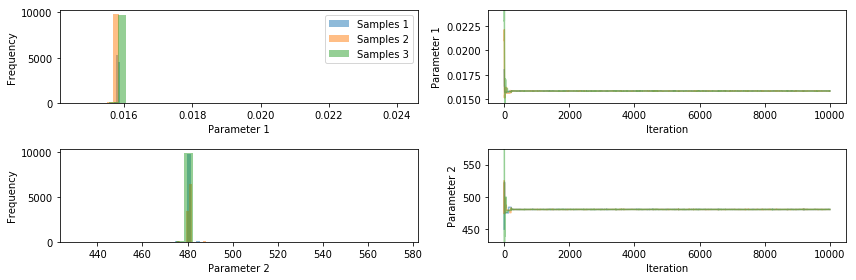

In [36]:
pints.plot.trace(chains_emu)
plt.show()

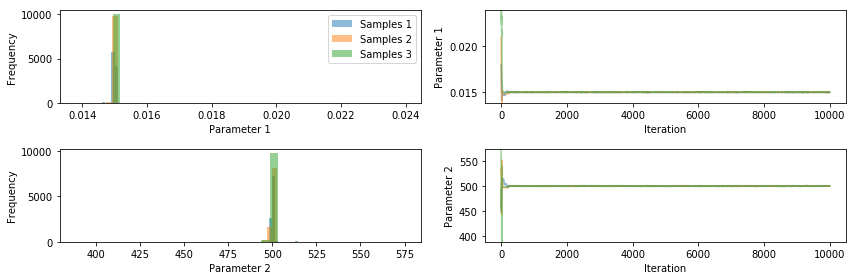

In [37]:
pints.plot.trace(chains)
plt.show()

In [38]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

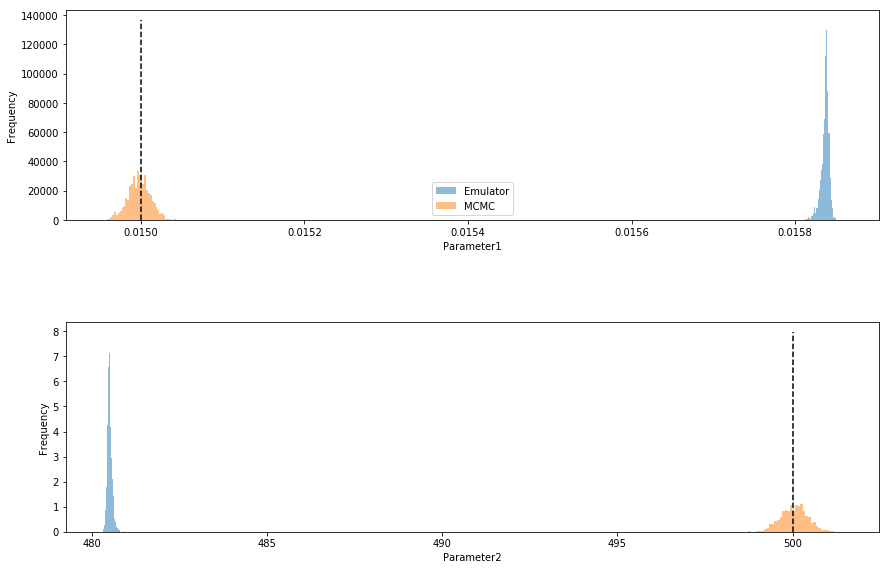

In [39]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

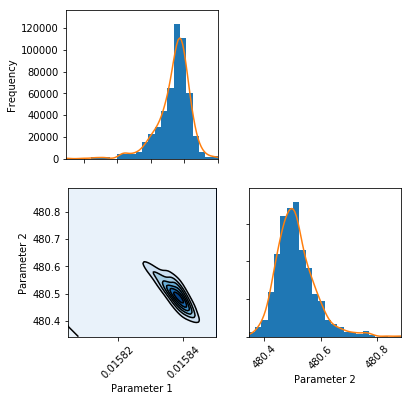

In [40]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

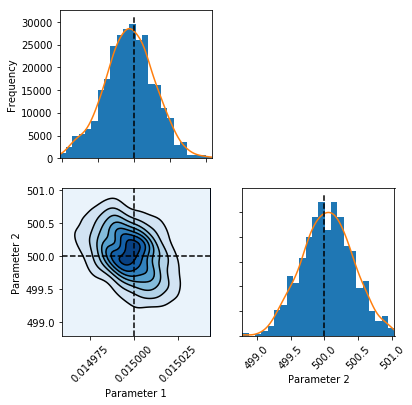

In [41]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

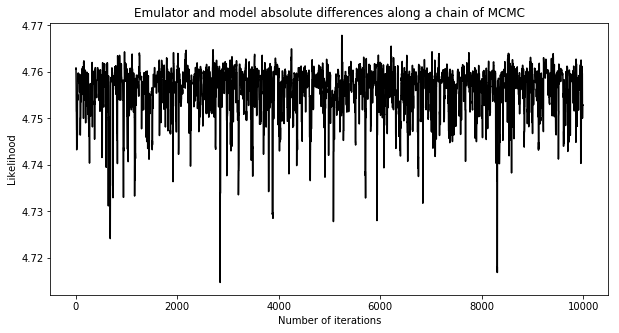

4.752883476094605

In [42]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain_rescaled).flatten()
diffs = (np.abs((model_prediction - emu_prediction) / model_prediction))

iters = np.linspace(0, 10000, len(chain_emu_rescaled))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [43]:
chain_emu

array([[1.58315470e-02, 4.80597586e+02],
       [1.58315470e-02, 4.80597586e+02],
       [1.58315470e-02, 4.80597586e+02],
       ...,
       [1.58395516e-02, 4.80469427e+02],
       [1.58395516e-02, 4.80469427e+02],
       [1.58395516e-02, 4.80469427e+02]])

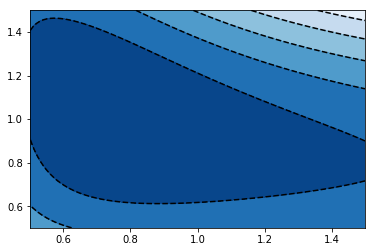

In [44]:
# Create grid
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
plt.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='k')
plt.show()

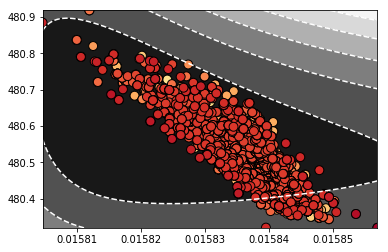

In [45]:
fig, ax = plt.subplots()                   

# Show density 
#ax.imshow(np.rot90(ll), cmap=plt.cm.Blues, extent=[xmin, xmax, ymin, ymax])                                                                     

# Plot chain_emu
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu
#ax.plot(x, y, 'k.', markersize=2)    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x_sorted, y_sorted, c=diffs_sorted, s=80, edgecolor='k', cmap="RdYlGn_r")
#fig.colorbar(ax)
plt.show()

Running...
Using Emulated Metropolis MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.0
3     12     0         0         0          0:00.0
20    63     0         0         0.0476     0:00.0
40    123    0         0.0244    0.0488     0:00.1
60    183    0         0.0164    0.0656     0:00.1
80    243    0         0.0123    0.0494     0:00.2
100   303    0         0.0198    0.0396     0:00.2
120   363    0         0.0165    0.0331     0:00.3
140   423    0         0.0142    0.0284     0:00.3
160   483    0         0.0124    0.0248     0:00.3
180   543    0         0.0166    0.0221     0:00.4
200   603    0.00498   0.0149    0.0199     0:00.4
220   663    0.00905   0.0136    0.0181     0:00.5
240   723    0.0083    0.0166    0.0166     0:00.5
260   783    0.00766   0.0192    0.0153   

3160  9483   0.0038    0.00348   0.0038     0:06.5
3180  9543   0.00377   0.00346   0.00377    0:06.5
3200  9603   0.00375   0.00344   0.00375    0:06.6
3220  9663   0.00373   0.00342   0.00373    0:06.6
3240  9723   0.0037    0.00339   0.00401    0:06.6
3260  9783   0.00368   0.00337   0.00399    0:06.7
3280  9843   0.00366   0.00335   0.00396    0:06.7
3300  9903   0.00364   0.00333   0.00394    0:06.8
3320  9963   0.00361   0.00331   0.00391    0:06.8
3340  10023  0.00359   0.00329   0.00389    0:06.8
3360  10083  0.00357   0.00327   0.00387    0:06.9
3380  10143  0.00355   0.00325   0.00385    0:06.9
3400  10203  0.00353   0.00323   0.00382    0:07.0
3420  10263  0.00351   0.00322   0.0038     0:07.0
3440  10323  0.00349   0.0032    0.00378    0:07.0
3460  10383  0.00347   0.00318   0.00376    0:07.1
3480  10443  0.00345   0.00316   0.00373    0:07.1
3500  10503  0.00343   0.00314   0.00371    0:07.1
3520  10563  0.00341   0.00312   0.00369    0:07.2
3540  10623  0.00367   0.00311 

6440  19323  0.00279   0.00342   0.00373    0:13.6
6460  19383  0.00279   0.00356   0.00371    0:13.7
6480  19443  0.00278   0.00355   0.0037     0:13.7
6500  19503  0.00277   0.00354   0.00369    0:13.7
6520  19563  0.00276   0.00353   0.00368    0:13.8
6540  19623  0.00275   0.00352   0.00367    0:13.8
6560  19683  0.00274   0.00351   0.00366    0:13.9
6580  19743  0.00274   0.00365   0.00365    0:13.9
6600  19803  0.00273   0.00364   0.00364    0:14.0
6620  19863  0.00272   0.00362   0.00362    0:14.0
6640  19923  0.00271   0.00361   0.00376    0:14.0
6660  19983  0.0027    0.0036    0.00375    0:14.1
6680  20043  0.00269   0.00359   0.00374    0:14.1
6700  20103  0.00269   0.00358   0.00373    0:14.2
6720  20163  0.00268   0.00357   0.00372    0:14.2
6740  20223  0.00267   0.00356   0.00371    0:14.3
6760  20283  0.00266   0.00355   0.0037     0:14.3
6780  20343  0.00265   0.00354   0.00369    0:14.3
6800  20403  0.00265   0.00353   0.00368    0:14.4
6820  20463  0.00264   0.00352 

9660  28983  0.00186   0.00342   0.00373    0:21.1
9680  29043  0.00186   0.00341   0.00372    0:21.1
9700  29103  0.00186   0.0034    0.00371    0:21.1
9720  29163  0.00185   0.00339   0.0037     0:21.2
9740  29223  0.00185   0.00339   0.0037     0:21.2
9760  29283  0.00184   0.00338   0.00369    0:21.3
9780  29343  0.00184   0.00337   0.00368    0:21.3
9800  29403  0.00184   0.00337   0.00367    0:21.4
9820  29463  0.00183   0.00336   0.00367    0:21.4
9840  29523  0.00183   0.00335   0.00366    0:21.5
9860  29583  0.00183   0.00335   0.00365    0:21.6
9880  29643  0.00182   0.00334   0.00364    0:21.6
9900  29703  0.00182   0.00333   0.00364    0:21.7
9920  29763  0.00181   0.00333   0.00383    0:21.7
9940  29823  0.00181   0.00332   0.00382    0:21.8
9960  29883  0.00181   0.00331   0.00381    0:21.8
9980  29943  0.0018    0.00331   0.00381    0:21.8
10000 30003  0.0018    0.0033    0.0038     0:21.9
10020 30063  0.0018    0.00329   0.00389    0:22.0
10040 30123  0.00179   0.00329 

12960 38883  0.00154   0.00285   0.00378    0:29.1
12980 38943  0.00154   0.00285   0.00377    0:29.2
13000 39003  0.00154   0.00285   0.00377    0:29.2
13020 39063  0.00154   0.00284   0.00376    0:29.3
13040 39123  0.00153   0.00284   0.00376    0:29.3
13060 39183  0.00153   0.00283   0.00375    0:29.4
13080 39243  0.00153   0.00283   0.00375    0:29.4
13100 39303  0.00153   0.00282   0.00374    0:29.5
13120 39363  0.00152   0.00282   0.00373    0:29.5
13140 39423  0.00152   0.00282   0.00373    0:29.6
13160 39483  0.00152   0.00281   0.00372    0:29.6
13180 39543  0.00152   0.00281   0.00372    0:29.6
13200 39603  0.00152   0.0028    0.00371    0:29.7
13220 39663  0.00151   0.0028    0.00371    0:29.7
13240 39723  0.00151   0.00279   0.0037     0:29.8
13260 39783  0.00151   0.00279   0.0037     0:29.8
13280 39843  0.00151   0.00279   0.00369    0:29.9
13300 39903  0.0015    0.00278   0.00368    0:29.9
13320 39963  0.0015    0.00278   0.00368    0:30.0
13340 40023  0.0015    0.00277 

16260 48783  0.00129   0.00246   0.00338    0:36.4
16280 48843  0.00129   0.00246   0.00338    0:36.4
16300 48903  0.00129   0.00245   0.00337    0:36.5
16320 48963  0.00129   0.00245   0.00337    0:36.5
16340 49023  0.00129   0.00245   0.00337    0:36.5
16360 49083  0.00128   0.00244   0.00336    0:36.6
16380 49143  0.00128   0.00244   0.00336    0:36.6
16400 49203  0.00128   0.00244   0.00335    0:36.7
16420 49263  0.00128   0.00244   0.00335    0:36.7
16440 49323  0.00128   0.00243   0.00335    0:36.8
16460 49383  0.00128   0.00243   0.00334    0:36.8
16480 49443  0.00127   0.00243   0.00334    0:36.8
16500 49503  0.00127   0.00242   0.00333    0:36.9
16520 49563  0.00127   0.00242   0.00333    0:36.9
16540 49623  0.00127   0.00242   0.00333    0:37.0
16560 49683  0.00127   0.00242   0.00332    0:37.0
16580 49743  0.00127   0.00241   0.00332    0:37.1
16600 49803  0.00126   0.00241   0.00331    0:37.1
16620 49863  0.00126   0.00241   0.00331    0:37.1
16640 49923  0.00126   0.0024  

19540 58623  0.00113   0.0021    0.00281    0:43.7
19560 58683  0.00112   0.0021    0.00281    0:43.7
19580 58743  0.00112   0.00209   0.00281    0:43.8
19600 58803  0.00112   0.00209   0.00281    0:43.8
19620 58863  0.00112   0.00209   0.0028     0:43.9
19640 58923  0.00112   0.00209   0.0028     0:43.9
19660 58983  0.00112   0.00209   0.0028     0:44.0
19680 59043  0.00112   0.00208   0.00279    0:44.0
19700 59103  0.00112   0.00208   0.00279    0:44.0
19720 59163  0.00112   0.00208   0.00279    0:44.1
19740 59223  0.00111   0.00208   0.00279    0:44.1
19760 59283  0.00111   0.00207   0.00278    0:44.2
19780 59343  0.00111   0.00207   0.00278    0:44.2
19800 59403  0.00111   0.00207   0.00278    0:44.2
19820 59463  0.00111   0.00207   0.00277    0:44.3
19840 59523  0.00111   0.00207   0.00277    0:44.3
19860 59583  0.00111   0.00206   0.00277    0:44.4
19880 59643  0.00111   0.00206   0.00277    0:44.4
19900 59703  0.00111   0.00206   0.00276    0:44.5
19920 59763  0.0011    0.00206 

22860 68583  0.000962  0.00179   0.00241    0:50.3
22880 68643  0.000961  0.00179   0.0024     0:50.3
22900 68703  0.000961  0.00179   0.0024     0:50.3
22920 68763  0.00096   0.00179   0.0024     0:50.4
22940 68823  0.000959  0.00179   0.0024     0:50.4
22960 68883  0.000958  0.00179   0.0024     0:50.4
22980 68943  0.000957  0.00178   0.00239    0:50.5
23000 69003  0.000956  0.00178   0.00239    0:50.5
23020 69063  0.000956  0.00178   0.00239    0:50.6
23040 69123  0.000955  0.00178   0.00239    0:50.6
23060 69183  0.000954  0.00178   0.00238    0:50.6
23080 69243  0.000953  0.00178   0.00238    0:50.7
23100 69303  0.000996  0.00177   0.00238    0:50.7
23120 69363  0.000995  0.00177   0.00238    0:50.8
23140 69423  0.000994  0.00177   0.00238    0:50.8
23160 69483  0.000993  0.00177   0.00237    0:50.8
23180 69543  0.000992  0.00177   0.00237    0:50.9
23200 69603  0.000991  0.00177   0.00237    0:50.9
23220 69663  0.00099   0.00177   0.00237    0:51.0
23240 69723  0.00099   0.00176 

26120 78363  0.000881  0.00161   0.00214    0:56.8
26140 78423  0.00088   0.00161   0.00214    0:56.8
26160 78483  0.000879  0.00161   0.00214    0:56.9
26180 78543  0.000878  0.0016    0.00214    0:56.9
26200 78603  0.000878  0.0016    0.00214    0:56.9
26220 78663  0.000877  0.0016    0.00214    0:57.0
26240 78723  0.000876  0.0016    0.00213    0:57.0
26260 78783  0.000876  0.0016    0.00213    0:57.1
26280 78843  0.000875  0.0016    0.00213    0:57.1
26300 78903  0.000874  0.0016    0.00213    0:57.1
26320 78963  0.000874  0.0016    0.00213    0:57.2
26340 79023  0.000873  0.00159   0.00213    0:57.2
26360 79083  0.000873  0.00159   0.00212    0:57.3
26380 79143  0.000872  0.00159   0.00212    0:57.3
26400 79203  0.000871  0.00159   0.00212    0:57.3
26420 79263  0.000871  0.00159   0.00212    0:57.4
26440 79323  0.00087   0.00159   0.00212    0:57.4
26460 79383  0.000869  0.00159   0.00212    0:57.5
26480 79443  0.000869  0.00159   0.00211    0:57.5
26500 79503  0.000868  0.00158 

29400 88203  0.000782  0.00143   0.00194    1:03.6
29420 88263  0.000782  0.00143   0.00194    1:03.6
29440 88323  0.000781  0.00143   0.00194    1:03.7
29460 88383  0.000781  0.00143   0.00193    1:03.7
29480 88443  0.00078   0.00142   0.00193    1:03.7
29500 88503  0.00078   0.00142   0.00193    1:03.8
29520 88563  0.000779  0.00142   0.00193    1:03.8
29540 88623  0.000779  0.00142   0.00193    1:03.9
29560 88683  0.000778  0.00142   0.00193    1:03.9
29580 88743  0.000778  0.00142   0.00193    1:03.9
29600 88803  0.000777  0.00142   0.00193    1:04.0
29620 88863  0.000776  0.00142   0.00192    1:04.0
29640 88923  0.000776  0.00142   0.00192    1:04.0
29660 88983  0.000775  0.00142   0.00192    1:04.1
29680 89043  0.000775  0.00142   0.00192    1:04.1
29700 89103  0.000774  0.00141   0.00192    1:04.2
29720 89163  0.000774  0.00141   0.00192    1:04.2
29740 89223  0.000773  0.00141   0.00192    1:04.3
29760 89283  0.000773  0.00141   0.00192    1:04.3
29780 89343  0.000772  0.00141 

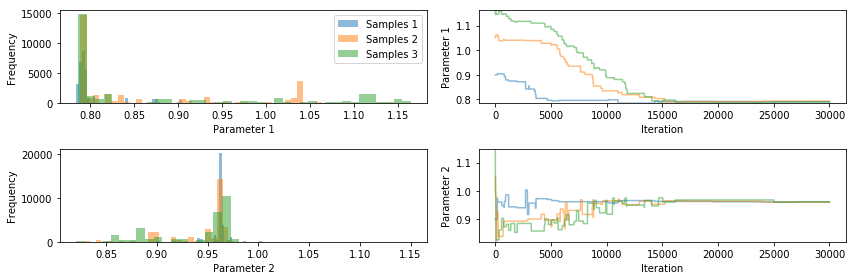

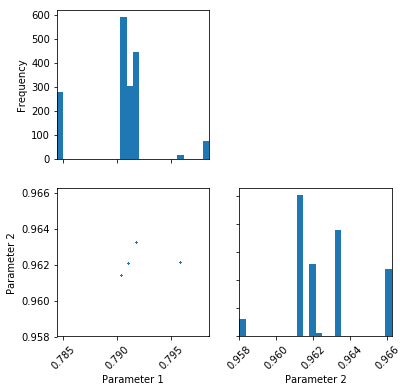

In [46]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05, #1.1
    np.array(start_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 5e-3

# Create mcmc routine
mcmc = pints.MCMCController(emu, 3, x0s, sigma0=sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
emulated_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Discard warm up
emulated_chains_thinned = emulated_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

Running...
Using Metropolis random walk MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0.5       0         0.5        0:00.0
2     9      0.333     0.333     0.333      0:00.0
3     12     0.25      0.25      0.5        0:00.0
20    63     0.143     0.0476    0.19       0:00.0
40    123    0.0732    0.0244    0.146      0:00.0
60    183    0.0492    0.0492    0.0984     0:00.0
80    243    0.0494    0.037     0.0741     0:00.1
100   303    0.0396    0.0396    0.0594     0:00.1
120   363    0.0413    0.0331    0.0579     0:00.1
140   423    0.0426    0.0426    0.0567     0:00.1
160   483    0.0373    0.0373    0.0497     0:00.1
180   543    0.0387    0.0387    0.0497     0:00.1
200   603    0.0448    0.039801  0.0547     0:00.1
220   663    0.0407    0.0407    0.0498     0:00.2
240   723    0.0415    0.0373    0.0498     0:00.2
260   783    0.0383    0.0345    0.046 

3280  9843   0.0244    0.0351    0.0271     0:02.2
3300  9903   0.0245    0.0348    0.0273     0:02.2
3320  9963   0.0247    0.0346    0.0271     0:02.2
3340  10023  0.0248    0.0347    0.0269     0:02.2
3360  10083  0.025     0.0345    0.0268     0:02.3
3380  10143  0.0248    0.0343    0.0266     0:02.3
3400  10203  0.0247    0.0341    0.0265     0:02.3
3420  10263  0.0248    0.0342    0.0263     0:02.3
3440  10323  0.0247    0.0343    0.0264     0:02.3
3460  10383  0.0251    0.0344    0.0263     0:02.3
3480  10443  0.0256    0.0345    0.0264     0:02.3
3500  10503  0.0254    0.0346    0.0266     0:02.3
3520  10563  0.0253    0.0344    0.0267     0:02.4
3540  10623  0.0251    0.0347    0.0265     0:02.4
3560  10683  0.025     0.0345    0.0267     0:02.4
3580  10743  0.0249    0.0346    0.0265     0:02.4
3600  10803  0.025     0.0353    0.0267     0:02.4
3620  10863  0.0249    0.0351    0.0265     0:02.4
3640  10923  0.025     0.0352    0.0269     0:02.4
3660  10983  0.0254    0.035   

6620  19863  0.0198    0.0314    0.0301     0:04.4
6640  19923  0.0197    0.0313    0.0301     0:04.4
6660  19983  0.0197    0.0312    0.03       0:04.4
6680  20043  0.0196    0.0311    0.0299     0:04.4
6700  20103  0.0195    0.031     0.0298     0:04.5
6720  20163  0.0195    0.0309    0.0299     0:04.5
6740  20223  0.0194    0.0309    0.0298     0:04.5
6760  20283  0.0194    0.0308    0.0299     0:04.5
6780  20343  0.0193    0.0307    0.0298     0:04.5
6800  20403  0.0193    0.0306    0.0298     0:04.5
6820  20463  0.0192    0.0305    0.0299     0:04.5
6840  20523  0.0191    0.0304    0.0298     0:04.6
6860  20583  0.0191    0.0303    0.0297     0:04.6
6880  20643  0.019     0.0302    0.0296     0:04.6
6900  20703  0.0191    0.0301    0.0297     0:04.6
6920  20763  0.0191    0.0301    0.0298     0:04.6
6940  20823  0.019     0.0301    0.0298     0:04.6
6960  20883  0.019     0.03      0.0297     0:04.6
6980  20943  0.0191    0.0301    0.0297     0:04.6
7000  21003  0.0191    0.0303  

9880  29643  0.0153    0.0277    0.0286     0:06.6
9900  29703  0.0153    0.0277    0.0286     0:06.6
9920  29763  0.0152    0.0276    0.0285     0:06.6
9940  29823  0.0152    0.0277    0.0285     0:06.6
9960  29883  0.0152    0.0277    0.0284     0:06.6
9980  29943  0.0151    0.0277    0.0284     0:06.6
10000 30003  0.0151    0.0276    0.0284     0:06.7
10020 30063  0.0151    0.0275    0.0284     0:06.7
10040 30123  0.015     0.0276    0.0284     0:06.7
10060 30183  0.015     0.0276    0.0283     0:06.7
10080 30243  0.015     0.0276    0.0285     0:06.7
10100 30303  0.0149    0.0275    0.0286     0:06.7
10120 30363  0.0149    0.0275    0.0287     0:06.7
10140 30423  0.0149    0.0274    0.0287     0:06.8
10160 30483  0.0149    0.0275    0.0288     0:06.8
10180 30543  0.0148    0.0274    0.0288     0:06.8
10200 30603  0.0148    0.0274    0.0287     0:06.8
10220 30663  0.0148    0.0274    0.0288     0:06.8
10240 30723  0.0147    0.0274    0.0288     0:06.8
10260 30783  0.0147    0.0274  

13140 39423  0.0118    0.0229    0.0278     0:08.8
13160 39483  0.0118    0.0229    0.0278     0:08.8
13180 39543  0.0118    0.0228    0.0278     0:08.8
13200 39603  0.0117    0.0228    0.0279     0:08.8
13220 39663  0.0117    0.0228    0.0278     0:08.8
13240 39723  0.0117    0.0227    0.0278     0:08.8
13260 39783  0.0117    0.0227    0.0278     0:08.8
13280 39843  0.0117    0.0227    0.0278     0:08.9
13300 39903  0.0117    0.0226    0.0277     0:08.9
13320 39963  0.0116    0.0226    0.0278     0:08.9
13340 40023  0.0116    0.0226    0.0277     0:08.9
13360 40083  0.0116    0.0225    0.0278     0:08.9
13380 40143  0.0116    0.0225    0.0277     0:08.9
13400 40203  0.0116    0.0225    0.0277     0:08.9
13420 40263  0.0115    0.0224    0.0277     0:08.9
13440 40323  0.0115    0.0224    0.0277     0:09.0
13460 40383  0.0116    0.0224    0.0276     0:09.0
13480 40443  0.0116    0.0224    0.0276     0:09.0
13500 40503  0.0116    0.0224    0.0276     0:09.0
13520 40563  0.0115    0.0223  

16440 49323  0.01      0.0189    0.0244     0:11.0
16460 49383  0.01      0.0188    0.0244     0:11.0
16480 49443  0.01      0.0188    0.0243     0:11.0
16500 49503  0.01      0.0188    0.0243     0:11.0
16520 49563  0.00999   0.018764  0.0243     0:11.0
16540 49623  0.00998   0.0187    0.0243     0:11.0
16560 49683  0.00996   0.0188    0.0243     0:11.0
16580 49743  0.00995   0.0188    0.0242     0:11.1
16600 49803  0.00994   0.0187    0.0242     0:11.1
16620 49863  0.00993   0.0187    0.0242     0:11.1
16640 49923  0.00992   0.0187    0.0242     0:11.1
16660 49983  0.0099    0.0187    0.0241     0:11.1
16680 50043  0.00989   0.0186    0.0242     0:11.1
16700 50103  0.00994   0.0186    0.0241     0:11.1
16720 50163  0.00993   0.0186    0.0242     0:11.1
16740 50223  0.00992   0.0186    0.0242     0:11.2
16760 50283  0.0099    0.0186    0.0242     0:11.2
16780 50343  0.00989   0.0185    0.0241     0:11.2
16800 50403  0.00988   0.0185    0.0241     0:11.2
16820 50463  0.00987   0.0185  

19740 59223  0.00876   0.0162    0.021      0:13.1
19760 59283  0.00875   0.0161    0.021      0:13.2
19780 59343  0.00875   0.0161    0.021      0:13.2
19800 59403  0.00874   0.0161    0.021      0:13.2
19820 59463  0.00873   0.0161    0.0209     0:13.2
19840 59523  0.00872   0.0161    0.0209     0:13.2
19860 59583  0.00871   0.0161    0.0209     0:13.2
19880 59643  0.0087    0.016     0.0209     0:13.2
19900 59703  0.00869   0.016     0.0209     0:13.3
19920 59763  0.00868   0.016     0.0208     0:13.3
19940 59823  0.00868   0.016     0.0208     0:13.3
19960 59883  0.00872   0.016     0.0208     0:13.3
19980 59943  0.00871   0.016     0.0208     0:13.3
20000 60003  0.0087    0.0159    0.0207     0:13.3
20020 60063  0.00869   0.016     0.0207     0:13.3
20040 60123  0.00868   0.016     0.0207     0:13.3
20060 60183  0.00867   0.016     0.0207     0:13.4
20080 60243  0.00866   0.0159    0.0207     0:13.4
20100 60303  0.00866   0.0159    0.0206     0:13.4
20120 60363  0.00865   0.0159  

23060 69183  0.00781   0.014     0.0182     0:15.3
23080 69243  0.0078    0.014     0.0182     0:15.4
23100 69303  0.00779   0.014     0.0182     0:15.4
23120 69363  0.00779   0.014     0.0182     0:15.4
23140 69423  0.00778   0.014     0.0181     0:15.4
23160 69483  0.00777   0.014     0.0181     0:15.4
23180 69543  0.00776   0.014     0.0181     0:15.4
23200 69603  0.00776   0.014     0.0181     0:15.4
23220 69663  0.00775   0.014     0.0181     0:15.4
23240 69723  0.00774   0.0139    0.0181     0:15.5
23260 69783  0.00774   0.0139    0.0181     0:15.5
23280 69843  0.00773   0.0139    0.018      0:15.5
23300 69903  0.00772   0.0139    0.018      0:15.5
23320 69963  0.00772   0.0139    0.018      0:15.5
23340 70023  0.00771   0.0139    0.018      0:15.5
23360 70083  0.00771   0.0139    0.018      0:15.5
23380 70143  0.0077    0.0139    0.018      0:15.6
23400 70203  0.00769   0.0138    0.0179     0:15.6
23420 70263  0.00769   0.0138    0.0179     0:15.6
23440 70323  0.00768   0.0138  

26340 79023  0.00718   0.0124    0.0163     0:17.5
26360 79083  0.00717   0.0124    0.0163     0:17.5
26380 79143  0.00716   0.0124    0.0163     0:17.6
26400 79203  0.00716   0.0123    0.0163     0:17.6
26420 79263  0.00715   0.0123    0.0163     0:17.6
26440 79323  0.00715   0.0123    0.0163     0:17.6
26460 79383  0.00714   0.0123    0.0163     0:17.6
26480 79443  0.00714   0.0123    0.0162     0:17.6
26500 79503  0.00713   0.0123    0.0162     0:17.6
26520 79563  0.00713   0.0123    0.0162     0:17.7
26540 79623  0.00712   0.0123    0.0162     0:17.7
26560 79683  0.00712   0.0123    0.0162     0:17.7
26580 79743  0.00711   0.0123    0.0162     0:17.7
26600 79803  0.0071    0.0123    0.0162     0:17.7
26620 79863  0.0071    0.0122    0.0162     0:17.7
26640 79923  0.00709   0.0122    0.0162     0:17.7
26660 79983  0.00709   0.0122    0.0162     0:17.7
26680 80043  0.00708   0.0122    0.0162     0:17.8
26700 80103  0.00708   0.0122    0.0162     0:17.8
26720 80163  0.00707   0.0122  

29600 88803  0.00652   0.0112    0.0149     0:19.7
29620 88863  0.00652   0.0112    0.0149     0:19.7
29640 88923  0.00651   0.0112    0.0149     0:19.7
29660 88983  0.00651   0.0112    0.0149     0:19.8
29680 89043  0.0065    0.0112    0.0149     0:19.8
29700 89103  0.0065    0.0112    0.0148     0:19.8
29720 89163  0.00653   0.0112    0.0148     0:19.8
29740 89223  0.00652   0.0112    0.0148     0:19.8
29760 89283  0.00652   0.0112    0.0148     0:19.8
29780 89343  0.00655   0.0112    0.0148     0:19.8
29800 89403  0.00654   0.0112    0.0148     0:19.9
29820 89463  0.00654   0.0112    0.0148     0:19.9
29840 89523  0.00653   0.0112    0.0148     0:19.9
29860 89583  0.00653   0.0112    0.0148     0:19.9
29880 89643  0.00653   0.0112    0.0148     0:19.9
29900 89703  0.00652   0.0112    0.0147     0:19.9
29920 89763  0.00652   0.0112    0.0147     0:20.0
29940 89823  0.00651   0.0112    0.0147     0:20.0
29960 89883  0.00651   0.0112    0.0147     0:20.0
29980 89943  0.0065    0.0112  

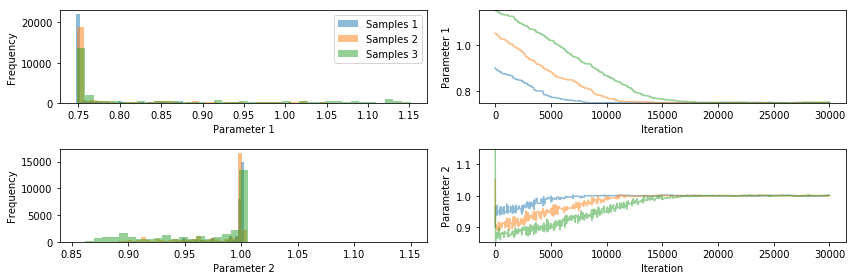

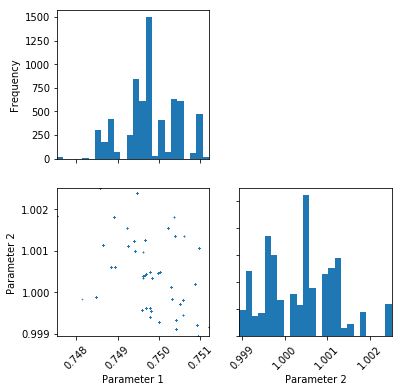

In [52]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05, #1.1
    np.array(start_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 1e-4

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
metropolis_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(metropolis_chains)

# Discard warm up
metropolis_chains_thinned = metropolis_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(metropolis_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(metropolis_chains_thinned[0])

# Show graphs
plt.show()

In [48]:
metropolis_chains.shape

(3, 30000, 2)

In [49]:
metropolis_chains[0][:10]

array([[0.9       , 0.9       ],
       [0.9       , 0.9       ],
       [0.9       , 0.9       ],
       [0.89869825, 0.92172838],
       [0.89869825, 0.92172838],
       [0.89869825, 0.92172838],
       [0.89869825, 0.92172838],
       [0.89869825, 0.92172838],
       [0.89869825, 0.92172838],
       [0.89869825, 0.92172838]])

In [50]:
emulated_chains[0][:10]

array([[0.9, 0.9],
       [0.9, 0.9],
       [0.9, 0.9],
       [0.9, 0.9],
       [0.9, 0.9],
       [0.9, 0.9],
       [0.9, 0.9],
       [0.9, 0.9],
       [0.9, 0.9],
       [0.9, 0.9]])

Running...
Using Metropolis random walk MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0.333     0.333     0          0:00.0
3     12     0.25      0.5       0          0:00.0
20    63     0.0952    0.381     0.381      0:00.0
40    123    0.122     0.268     0.463      0:00.0
60    183    0.0984    0.213     0.344      0:00.0
80    243    0.0864    0.173     0.308642   0:00.1
100   303    0.0891    0.139     0.248      0:00.1
120   363    0.0826    0.132     0.223      0:00.1
140   423    0.0851    0.141844  0.199      0:00.1
160   483    0.0807    0.155     0.18       0:00.1
180   543    0.0994    0.144     0.171      0:00.1
200   603    0.104     0.134     0.164      0:00.1
220   663    0.0995    0.136     0.163      0:00.1
240   723    0.0913    0.137     0.17       0:00.2
260   783    0.092     0.134     0.157 

3280  9843   0.0966    0.103     0.0875     0:02.2
3300  9903   0.0963    0.103     0.0869     0:02.2
3320  9963   0.0961    0.102     0.087      0:02.2
3340  10023  0.0955    0.102     0.0865     0:02.3
3360  10083  0.0952    0.102053  0.0863     0:02.3
3380  10143  0.0955    0.102     0.0861     0:02.3
3400  10203  0.0953    0.103     0.0862     0:02.3
3420  10263  0.0956    0.102     0.0862     0:02.3
3440  10323  0.0956    0.102     0.086      0:02.3
3460  10383  0.0962    0.102     0.0858     0:02.3
3480  10443  0.0962    0.102     0.0859     0:02.4
3500  10503  0.0968    0.103     0.0865     0:02.4
3520  10563  0.0966    0.103     0.0863     0:02.4
3540  10623  0.0963    0.104     0.0864     0:02.4
3560  10683  0.0958    0.104     0.0862     0:02.4
3580  10743  0.0961    0.104     0.0871     0:02.4
3600  10803  0.0958    0.10386   0.0866     0:02.4
3620  10863  0.0953    0.104     0.0867     0:02.5
3640  10923  0.095     0.103543  0.0871     0:02.5
3660  10983  0.0948    0.104   

6720  20163  0.0882    0.103     0.0911     0:04.5
6740  20223  0.0886    0.103     0.0908     0:04.6
6760  20283  0.0883    0.103     0.0905     0:04.6
6780  20343  0.0883    0.103     0.0905     0:04.6
6800  20403  0.0884    0.103     0.0903     0:04.6
6820  20463  0.0888    0.103     0.0905     0:04.6
6840  20523  0.0889    0.103     0.0905     0:04.6
6860  20583  0.0889    0.102     0.0904     0:04.6
6880  20643  0.0892    0.102456  0.0905     0:04.6
6900  20703  0.089     0.103     0.0906     0:04.7
6920  20763  0.089     0.103     0.0907     0:04.7
6940  20823  0.0892    0.103     0.0909     0:04.7
6960  20883  0.0889    0.103     0.0911     0:04.7
6980  20943  0.0887    0.103     0.0911     0:04.7
7000  21003  0.0888    0.103     0.090987   0:04.7
7020  21063  0.0886    0.103     0.0909     0:04.7
7040  21123  0.0889    0.103     0.0908     0:04.8
7060  21183  0.088656  0.103     0.0908     0:04.8
7080  21243  0.0888    0.103234  0.0909     0:04.8
7100  21303  0.0891    0.103   

9960  29883  0.0883    0.103     0.0926     0:06.7
9980  29943  0.0882    0.103     0.0924     0:06.7
10000 30003  0.0883    0.103     0.0923     0:06.7
10020 30063  0.0882    0.103     0.0921     0:06.8
10040 30123  0.0884    0.103     0.0919     0:06.8
10060 30183  0.0883    0.103     0.0919     0:06.8
10080 30243  0.0885    0.103     0.0921     0:06.8
10100 30303  0.0884    0.103     0.092      0:06.8
10120 30363  0.08843   0.103     0.0921     0:06.8
10140 30423  0.0883    0.103     0.0925     0:06.8
10160 30483  0.0884    0.104     0.092609   0:06.8
10180 30543  0.0883    0.104     0.0925     0:06.9
10200 30603  0.0882    0.103     0.0925     0:06.9
10220 30663  0.0881    0.104     0.0926     0:06.9
10240 30723  0.0881    0.104     0.0927     0:06.9
10260 30783  0.0884    0.104     0.0929     0:06.9
10280 30843  0.0882    0.104     0.0929     0:06.9
10300 30903  0.088     0.104     0.0928     0:06.9
10320 30963  0.0881    0.103     0.0929     0:07.0
10340 31023  0.0882    0.103   

13240 39723  0.0833    0.101     0.0931     0:08.9
13260 39783  0.0833    0.101     0.0931     0:08.9
13280 39843  0.0831    0.101     0.093      0:08.9
13300 39903  0.083     0.101     0.0929     0:09.0
13320 39963  0.0829    0.101     0.0927     0:09.0
13340 40023  0.0828    0.101     0.0926     0:09.0
13360 40083  0.0827    0.101     0.0926     0:09.0
13380 40143  0.0827    0.101     0.0926     0:09.0
13400 40203  0.0826    0.100888  0.0926     0:09.0
13420 40263  0.0826    0.101     0.0926     0:09.0
13440 40323  0.0825    0.101     0.0926     0:09.0
13460 40383  0.0825    0.101     0.0929     0:09.1
13480 40443  0.0824    0.101     0.0929     0:09.1
13500 40503  0.0823    0.101     0.0928     0:09.1
13520 40563  0.0824    0.101     0.0927     0:09.1
13540 40623  0.0824    0.101     0.0928     0:09.1
13560 40683  0.0823    0.101     0.0928     0:09.1
13580 40743  0.0822    0.1       0.0928     0:09.1
13600 40803  0.0823    0.1       0.0928     0:09.2
13620 40863  0.0822    0.1     

16700 50103  0.0783    0.0992    0.0929     0:11.2
16720 50163  0.0784    0.0992    0.0929     0:11.3
16740 50223  0.0783    0.0993    0.0929     0:11.3
16760 50283  0.0782    0.0992    0.093      0:11.3
16780 50343  0.0781    0.099     0.093      0:11.3
16800 50403  0.078     0.099     0.0929     0:11.3
16820 50463  0.078     0.0989    0.0929     0:11.3
16840 50523  0.078     0.099     0.093      0:11.3
16860 50583  0.078     0.0989    0.0931     0:11.3
16880 50643  0.0779    0.0988    0.0931     0:11.4
16900 50703  0.0779    0.0988    0.0933     0:11.4
16920 50763  0.078     0.0988    0.0934     0:11.4
16940 50823  0.0779    0.0988    0.0934     0:11.4
16960 50883  0.0778    0.0987    0.0935     0:11.4
16980 50943  0.0778    0.0988    0.0935     0:11.4
17000 51003  0.0779    0.0988    0.0935     0:11.4
17020 51063  0.0778    0.0987    0.0934     0:11.5
17040 51123  0.0779    0.0987    0.0936     0:11.5
17060 51183  0.078     0.0987    0.0935     0:11.5
17080 51243  0.0779    0.0987  

19980 59943  0.0739    0.0987    0.0935     0:13.4
20000 60003  0.0739    0.0986    0.0936     0:13.5
20020 60063  0.074     0.0986    0.0937     0:13.5
20040 60123  0.0739    0.0986    0.093658   0:13.5
20060 60183  0.0738    0.0986    0.0936     0:13.5
20080 60243  0.0738    0.0987    0.0936     0:13.5
20100 60303  0.0737    0.0987    0.0935     0:13.5
20120 60363  0.0736    0.0986    0.0936     0:13.5
20140 60423  0.0735    0.0986    0.0935     0:13.6
20160 60483  0.0735    0.0986    0.0935     0:13.6
20180 60543  0.0734    0.0986    0.0936     0:13.6
20200 60603  0.0735    0.0986    0.0936     0:13.6
20220 60663  0.0735    0.0985    0.0936     0:13.6
20240 60723  0.0734    0.0985    0.0936     0:13.6
20260 60783  0.0734    0.0985    0.0935     0:13.6
20280 60843  0.0734    0.0985    0.0934     0:13.7
20300 60903  0.0734    0.0984    0.0935     0:13.7
20320 60963  0.0734    0.0985    0.0936     0:13.7
20340 61023  0.0733    0.0984    0.0937     0:13.7
20360 61083  0.0733    0.0984  

23260 69783  0.0684    0.0968    0.0934     0:15.7
23280 69843  0.0684    0.0967    0.0933     0:15.7
23300 69903  0.068452  0.0966    0.0933     0:15.7
23320 69963  0.0684    0.0966    0.0933     0:15.7
23340 70023  0.0684    0.0965    0.0933     0:15.7
23360 70083  0.0686    0.0964    0.0932     0:15.7
23380 70143  0.0686    0.0964    0.0932     0:15.7
23400 70203  0.0685    0.0966    0.0934     0:15.7
23420 70263  0.0685    0.0966    0.0935     0:15.8
23440 70323  0.0685    0.0966    0.0935     0:15.8
23460 70383  0.0685    0.0965    0.0936     0:15.8
23480 70443  0.0684    0.0965    0.0936     0:15.8
23500 70503  0.0684    0.0964    0.0935     0:15.8
23520 70563  0.0684    0.0964    0.0935     0:15.8
23540 70623  0.0684    0.0965    0.0935     0:15.8
23560 70683  0.0684    0.0965    0.0934     0:15.9
23580 70743  0.0684    0.0965    0.0933     0:15.9
23600 70803  0.0683    0.0965    0.0933     0:15.9
23620 70863  0.0683    0.0964    0.0933     0:15.9
23640 70923  0.0683    0.0964  

26600 79803  0.0651    0.0937    0.0929     0:17.9
26620 79863  0.0651    0.0938    0.093      0:17.9
26640 79923  0.0651    0.0937    0.093      0:17.9
26660 79983  0.0651    0.0937    0.093      0:17.9
26680 80043  0.0651    0.0936    0.0929     0:18.0
26700 80103  0.0651    0.093592  0.0929     0:18.0
26720 80163  0.065     0.0936    0.0928     0:18.0
26740 80223  0.065     0.0935    0.0929     0:18.0
26760 80283  0.0649    0.0935    0.0929     0:18.0
26780 80343  0.0649    0.0934    0.0928     0:18.0
26800 80403  0.0649    0.0935    0.0927     0:18.0
26820 80463  0.0649    0.0934    0.0928     0:18.0
26840 80523  0.0649    0.0934    0.0928     0:18.1
26860 80583  0.0649    0.0933    0.0928     0:18.1
26880 80643  0.0648    0.0934    0.0929     0:18.1
26900 80703  0.0648    0.0933    0.0929     0:18.1
26920 80763  0.0648    0.0933    0.0929     0:18.1
26940 80823  0.0648    0.0933    0.0929     0:18.1
26960 80883  0.0648    0.0933    0.0929     0:18.1
26980 80943  0.0647    0.0933  

29880 89643  0.0626    0.0904    0.0917     0:20.1
29900 89703  0.0625    0.0905    0.0917     0:20.1
29920 89763  0.0625    0.0905    0.0918     0:20.1
29940 89823  0.0625    0.0904    0.0917     0:20.1
29960 89883  0.0625    0.0905    0.0917     0:20.2
29980 89943  0.0624    0.0904    0.0917     0:20.2
30000 90000  0.0624    0.0904    0.0917     0:20.2
Halting: Maximum number of iterations (30000) reached.
Done!
R-hat:
[4.608314108367965, 4.590281821261431]


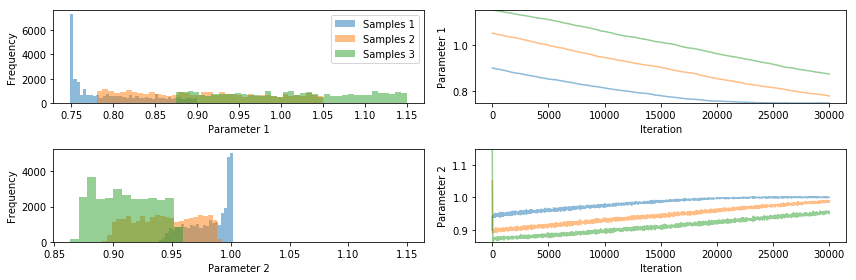

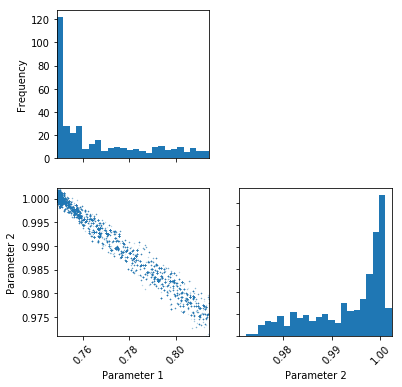

In [53]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05, #1.1
    np.array(start_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 1e-6

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
metropolis_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(metropolis_chains)

# Discard warm up
metropolis_chains_thinned = metropolis_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(metropolis_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(metropolis_chains_thinned[0])

# Show graphs
plt.show()